# A - Intro

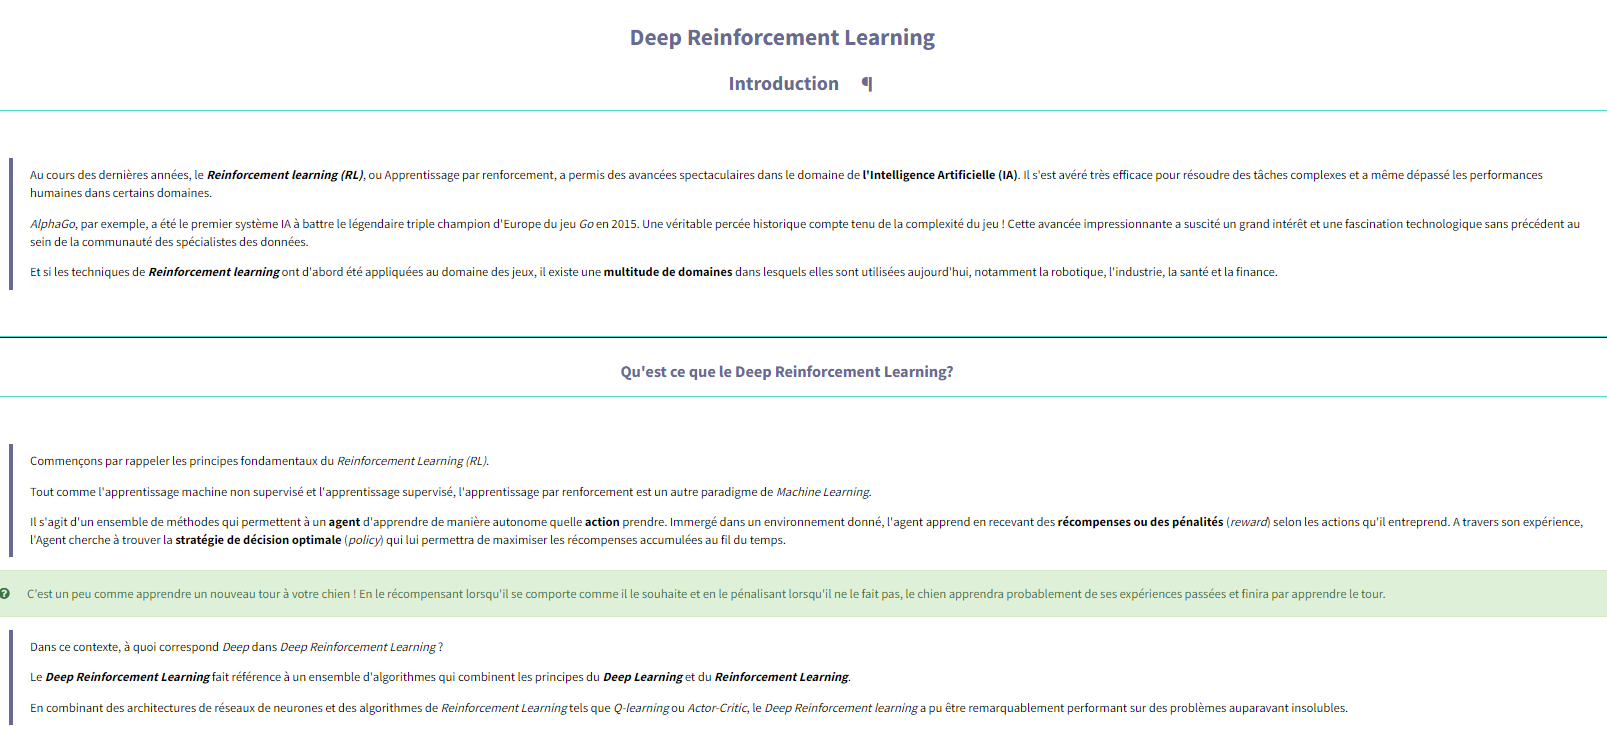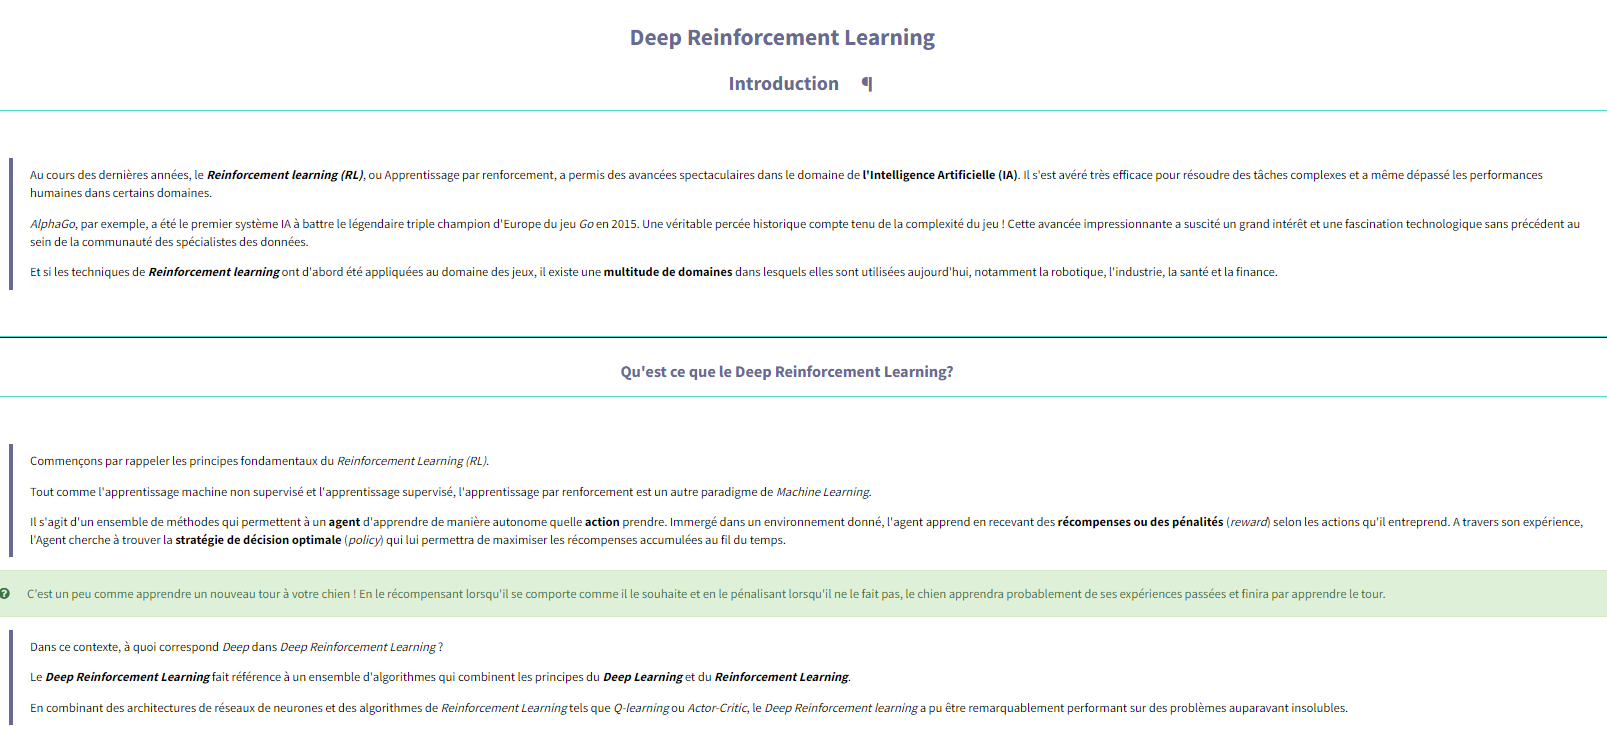

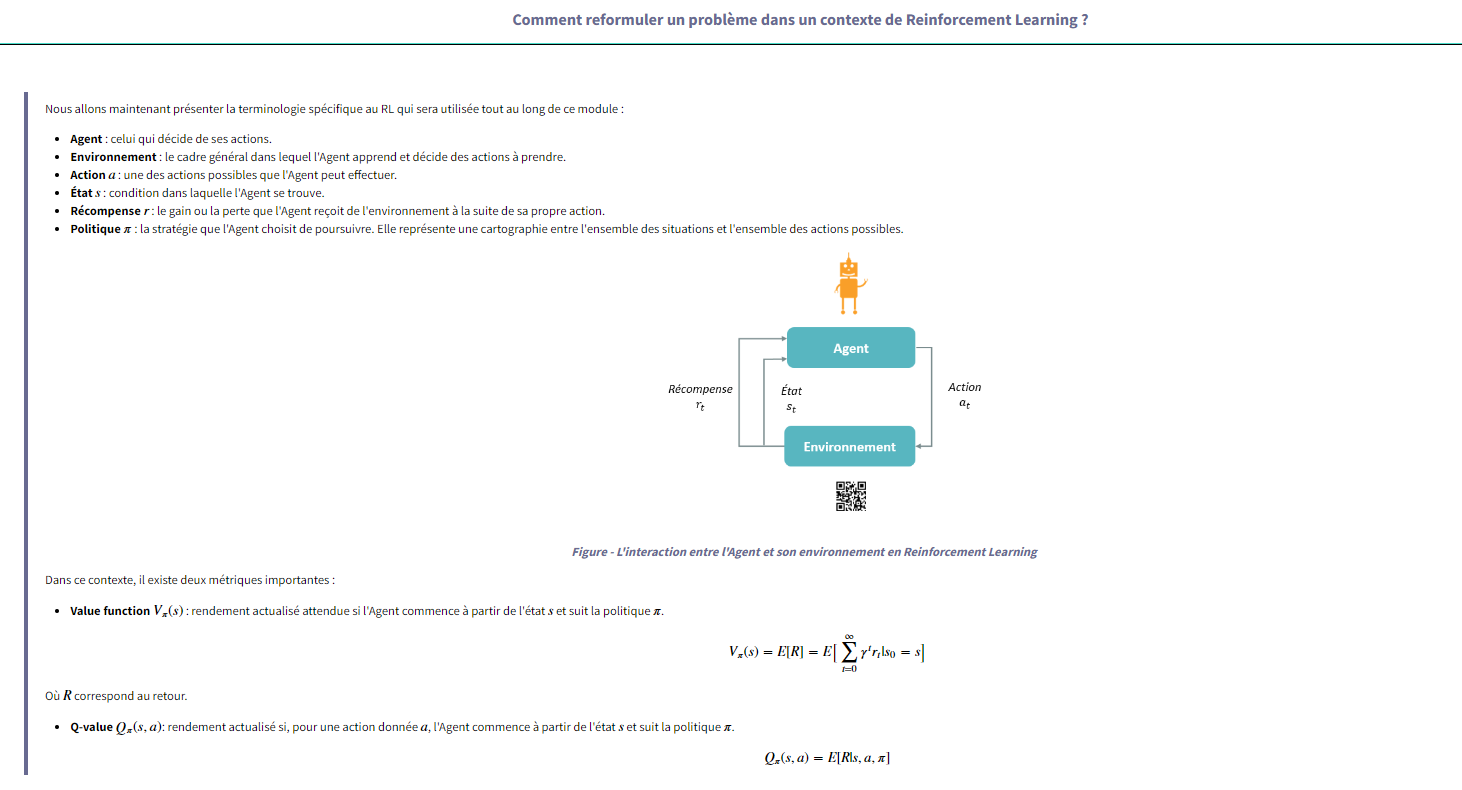

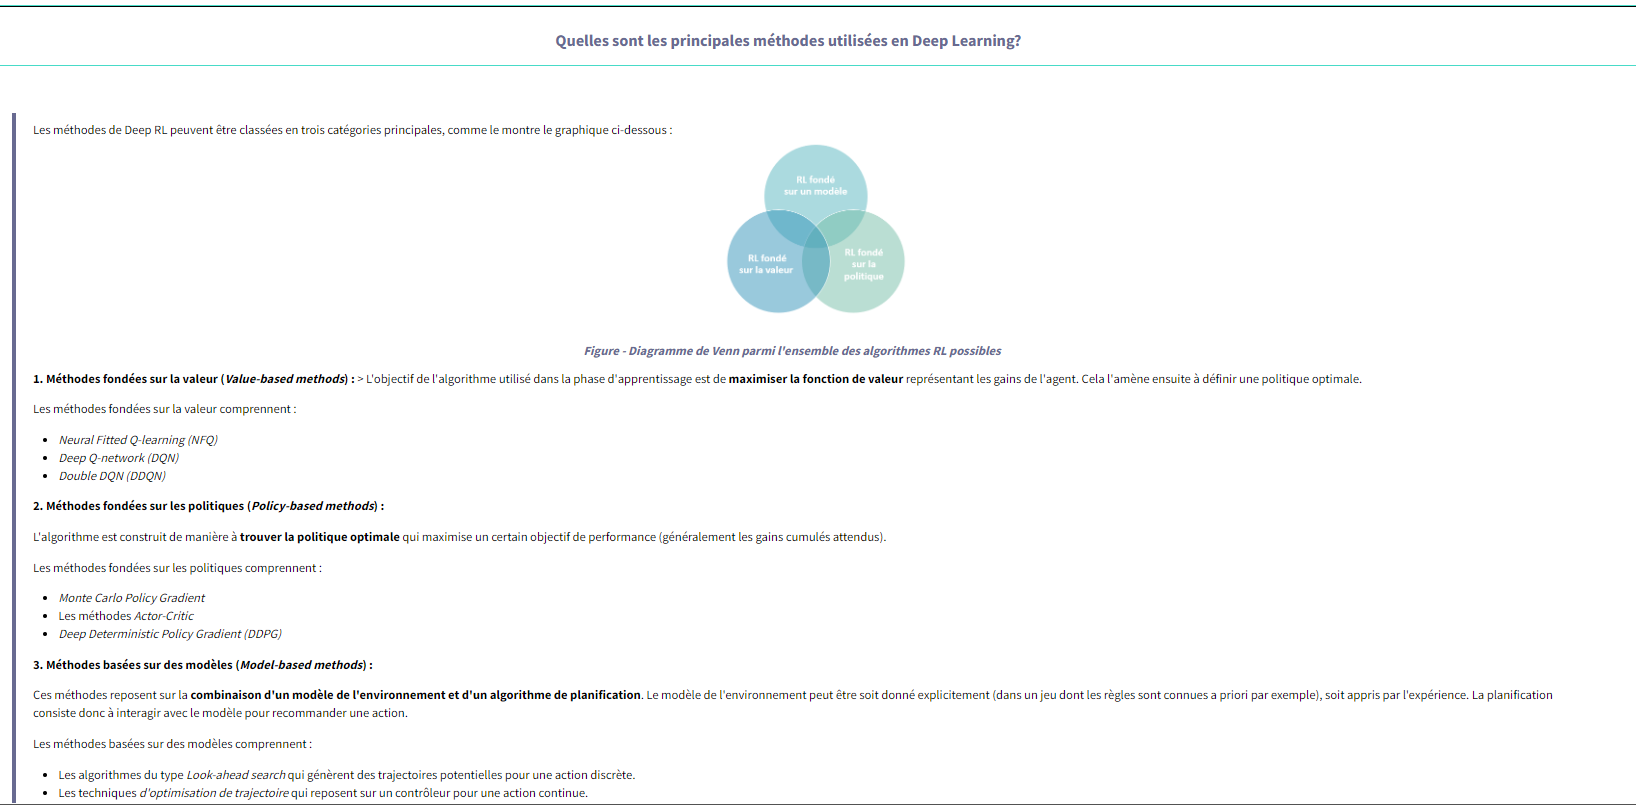

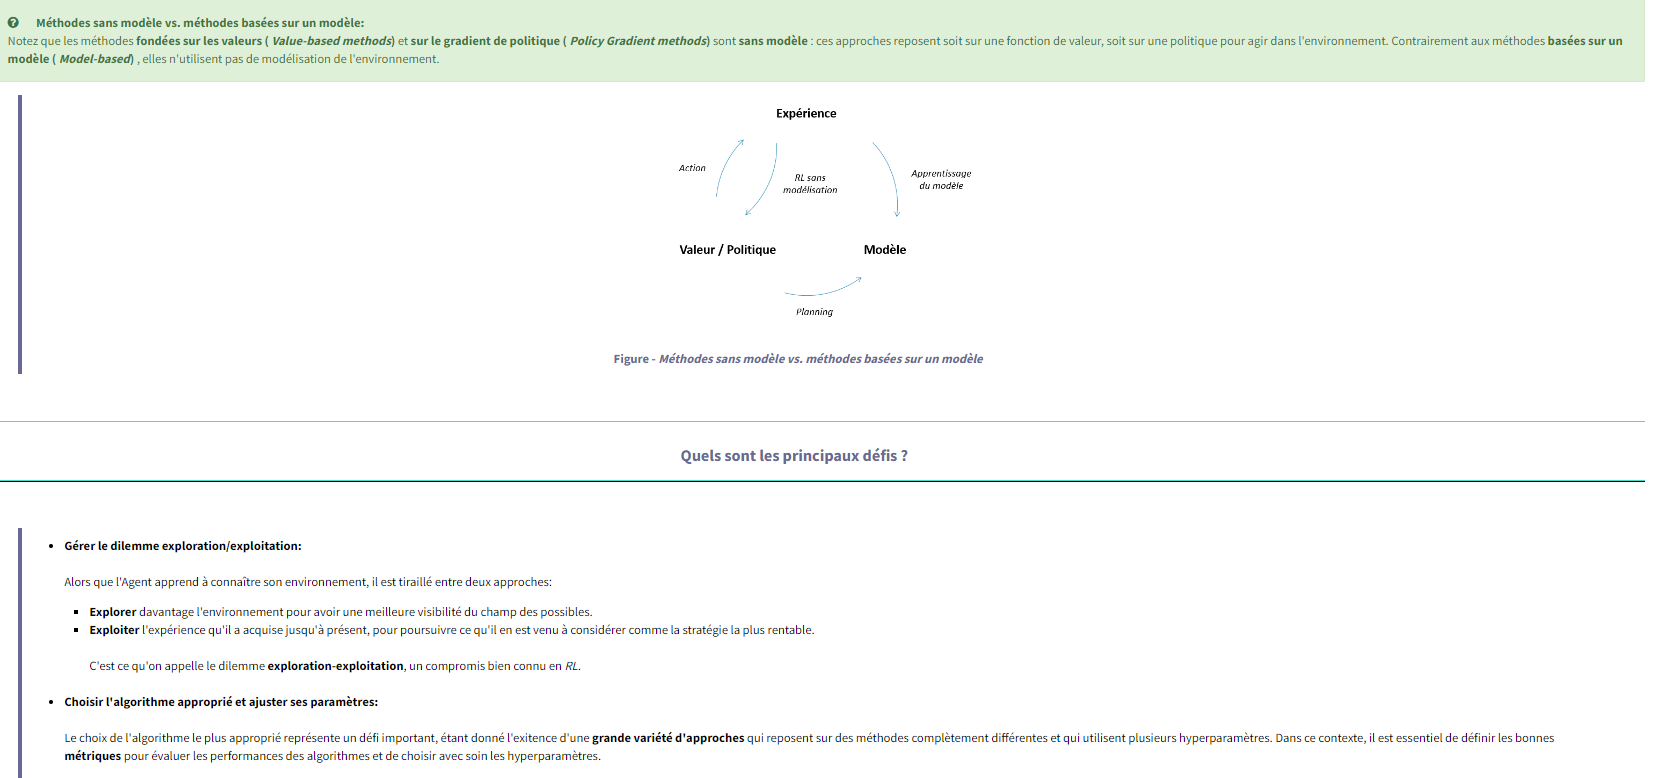

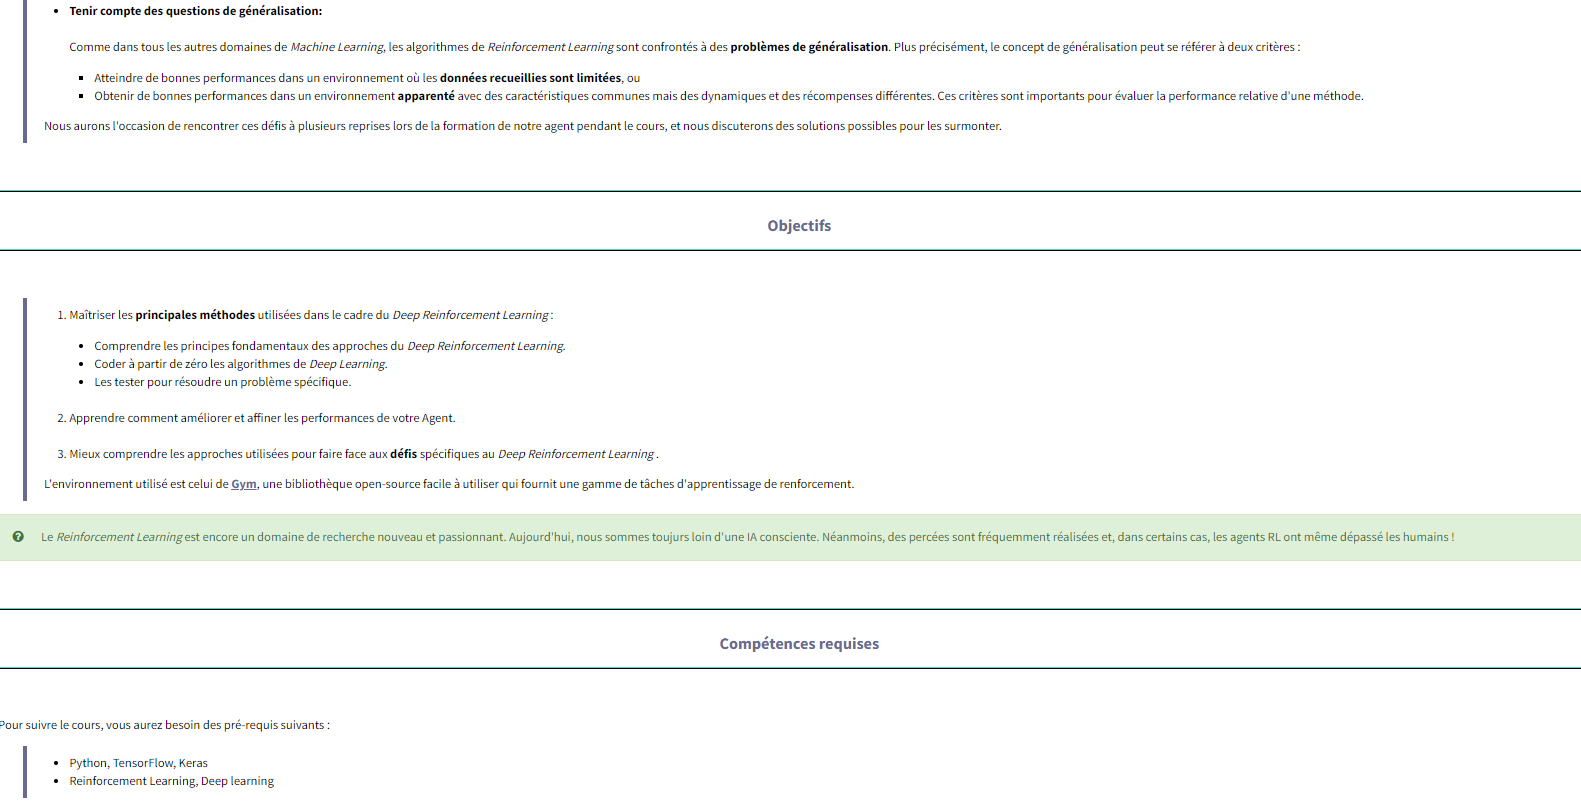

# B - Deep Q Learning - Partie 1

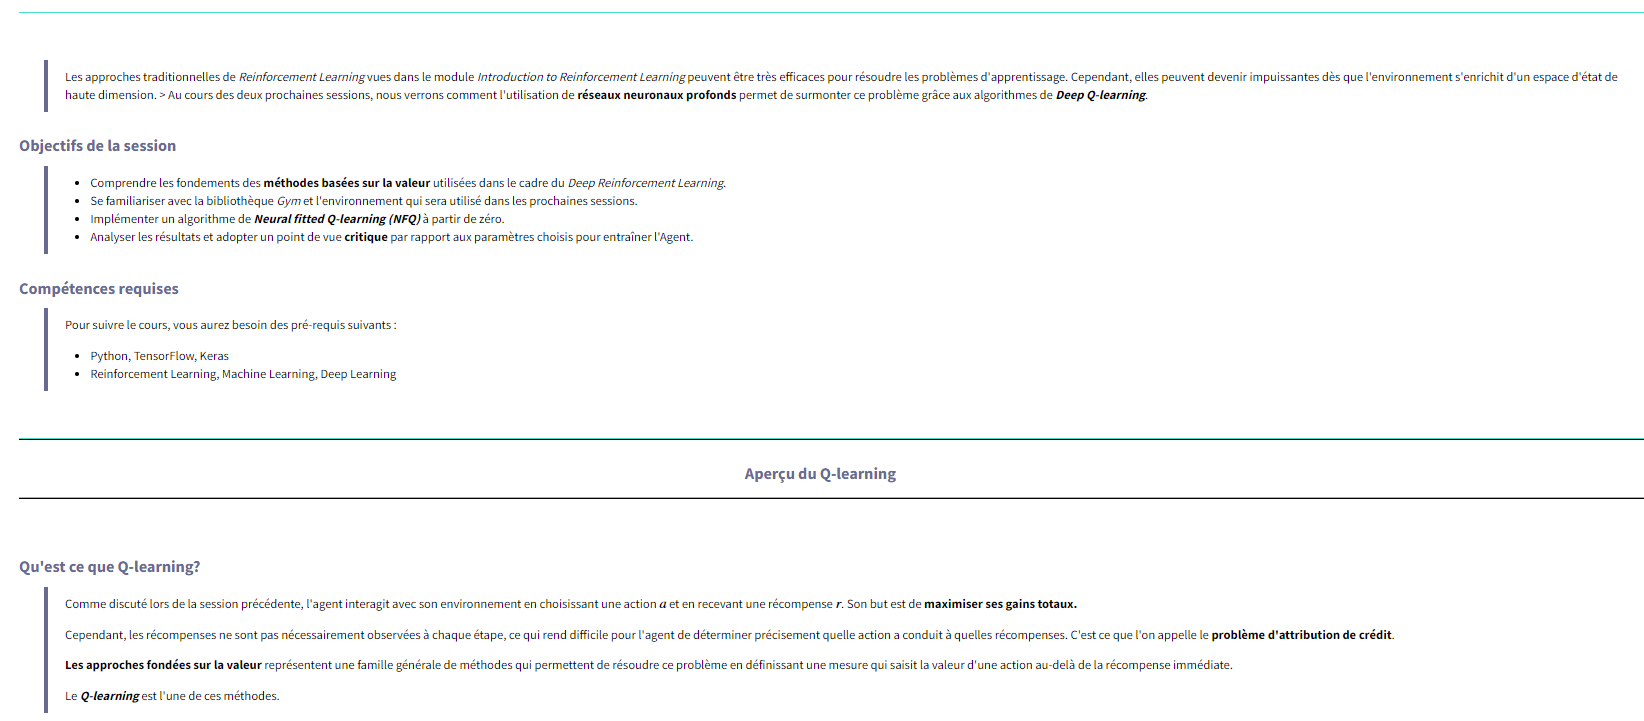

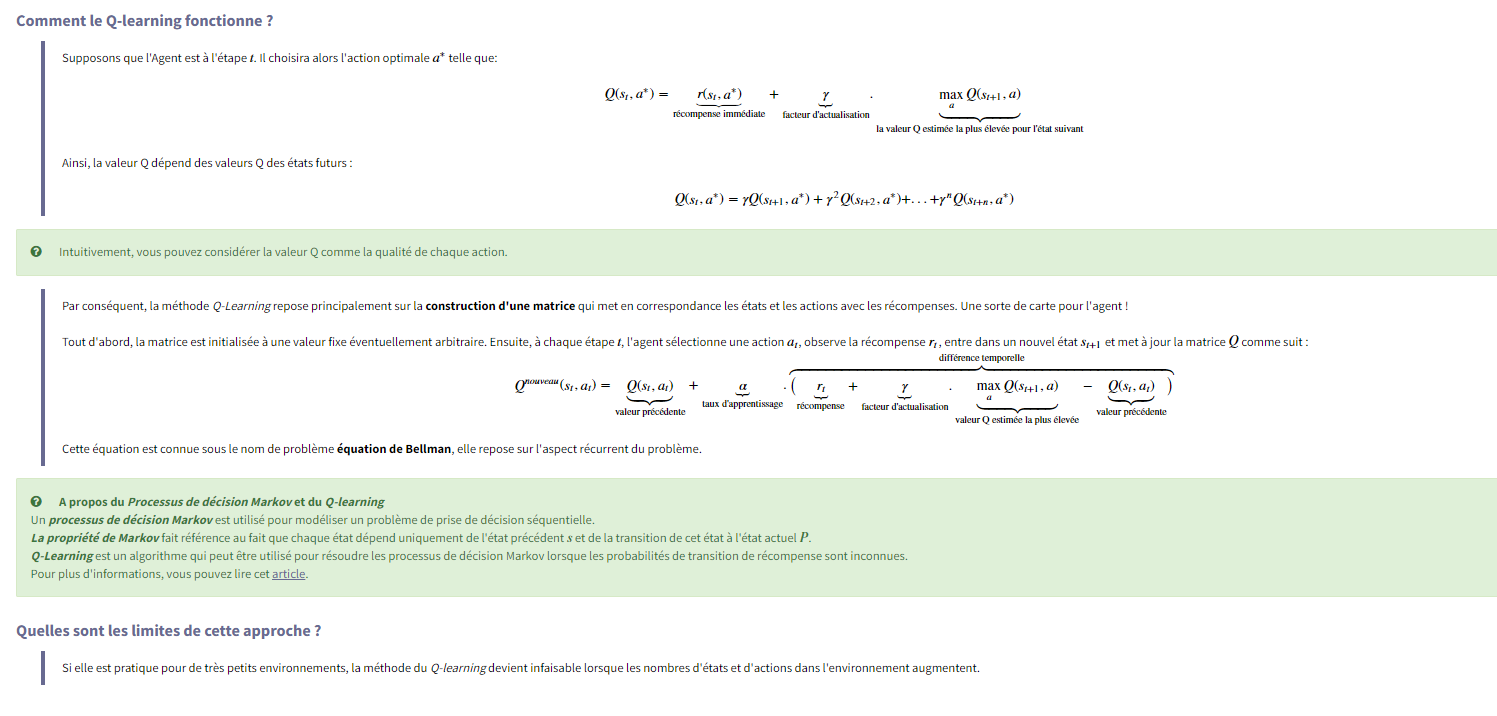

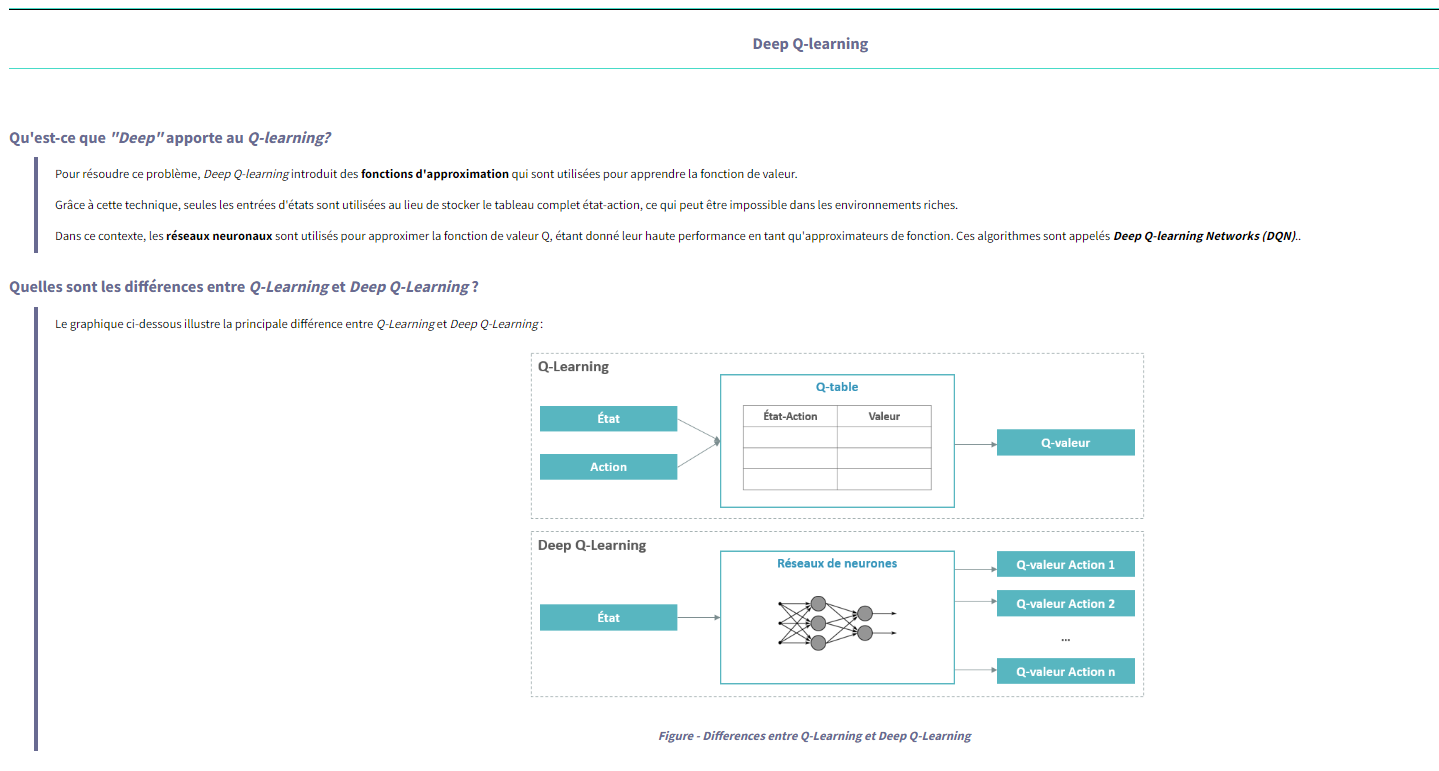

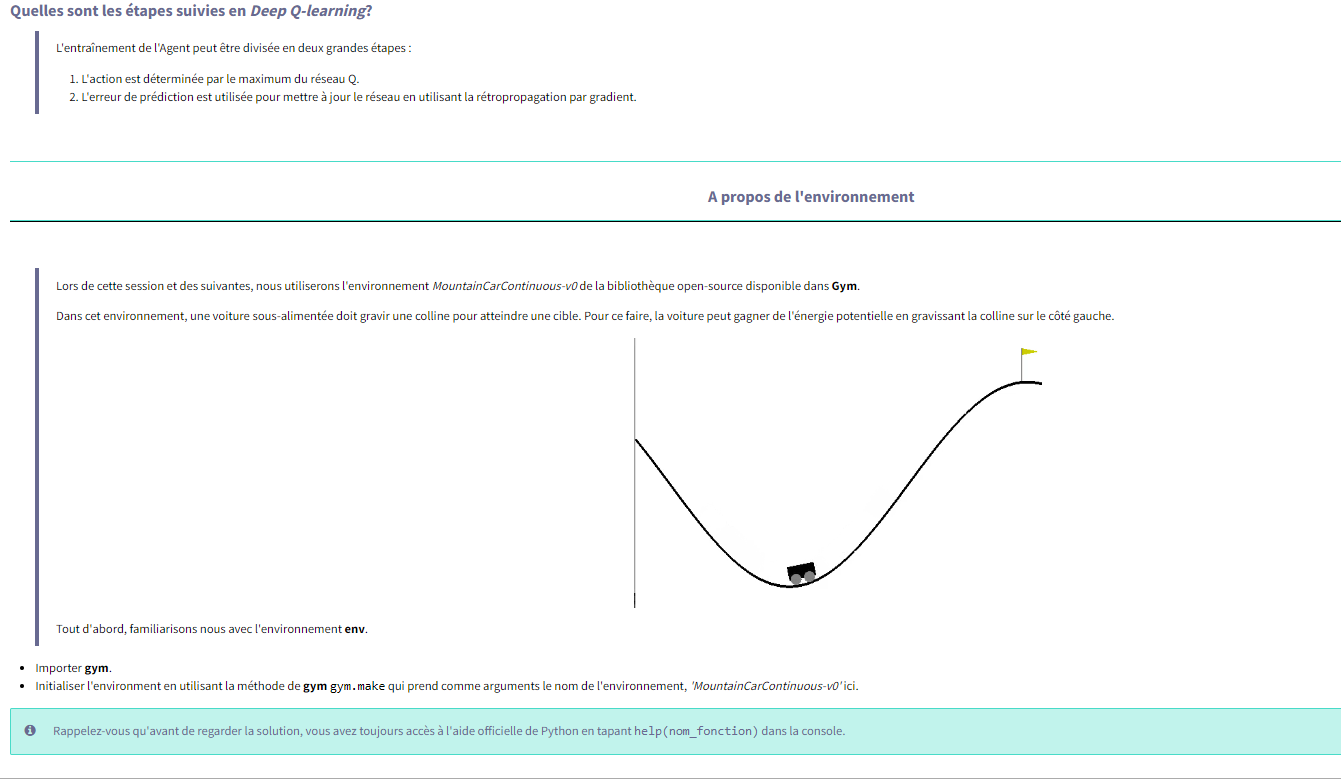

In [ ]:
""" on utilise keras => env bases ??? ou bien se placer dans l'environnement deep-learning voir GPU....

conda install -c conda-forge gym  => env (bases) insconsistant avec bp de packages => 


"""

In [1]:
import gym
environment_name = 'MountainCarContinuous-v0'
env = gym.make(environment_name)

ModuleNotFoundError: No module named 'gym'

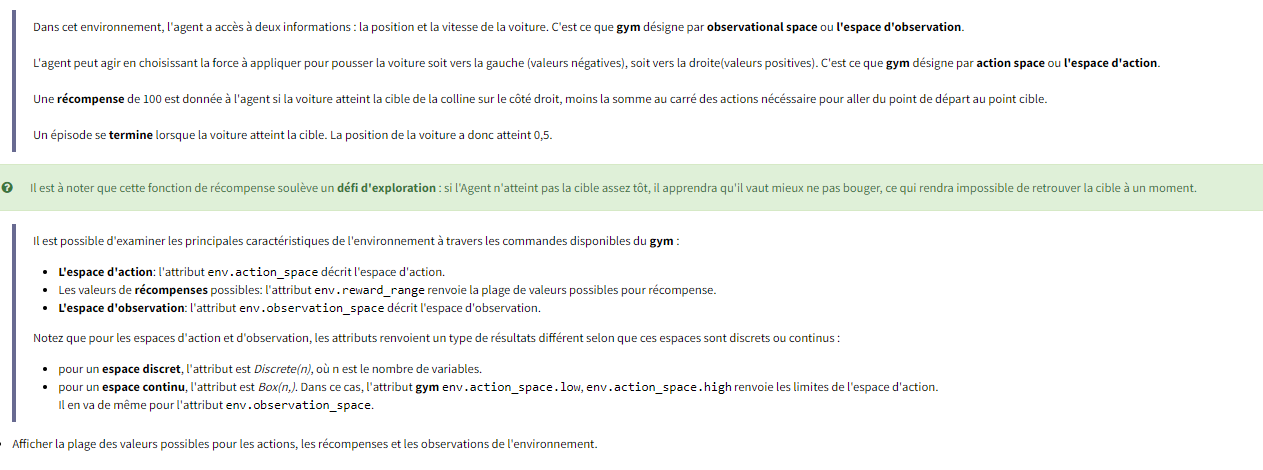

In [ ]:
print('Espace d\'action: (%.3f to %.3f)'%(env.action_space.low, env.action_space.high))
print('Récompenses: %s'%(str(env.reward_range)))
print('Nombre d\'observation par état: %i'%(env.observation_space.shape[0]))

for i in range(env.observation_space.shape[0]):
    print('Observation %i: (%.3f to %.3f)'%
          (i,env.observation_space.low[i], env.observation_space.high[i]))

In [ ]:
"""
Espace d'action: (-1.000 to 1.000)
Récompenses: (-inf, inf)
Nombre d'observation par état: 2
Observation 0: (-1.200 to 0.600)
Observation 1: (-0.070 to 0.070)
"""

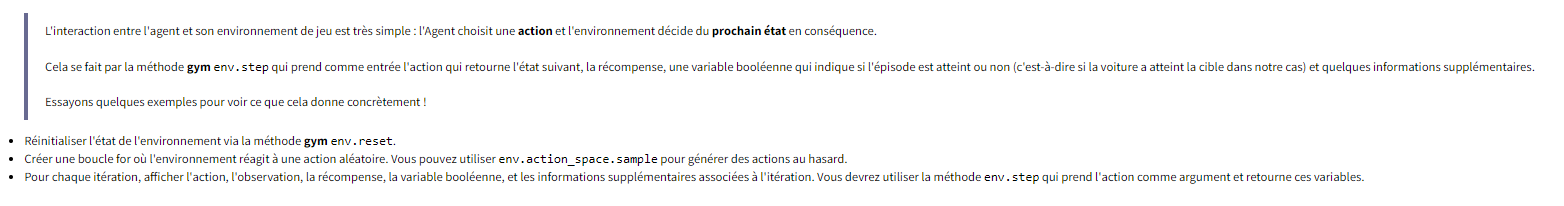

In [ ]:
env.reset()
for _ in range(5):
    observation, reward, done, info = env.step(action=env.action_space.sample())
    print("action: %.3f"%(env.action_space.sample()[0])) # action
    print("observation: [%.3f,%.3f]"%(observation[0],observation[1]))
    print("reward: %.3f"%(reward)) # récompense
    print("done:", done) # statut
    print("info", info) # infos additionnelles 
    print()

In [ ]:
"""
action: 0.299
observation: [-0.582,0.002]
reward: -0.055
done: False
info {}

action: 0.606
observation: [-0.582,0.001]
reward: -0.090
done: False
info {}

action: 0.263
observation: [-0.580,0.001]
reward: -0.010
done: False
info {}

action: -0.689
observation: [-0.579,0.001]
reward: -0.045
done: False
info {}

action: 0.511
observation: [-0.579,0.001]
reward: -0.030
done: False
info {}
"""

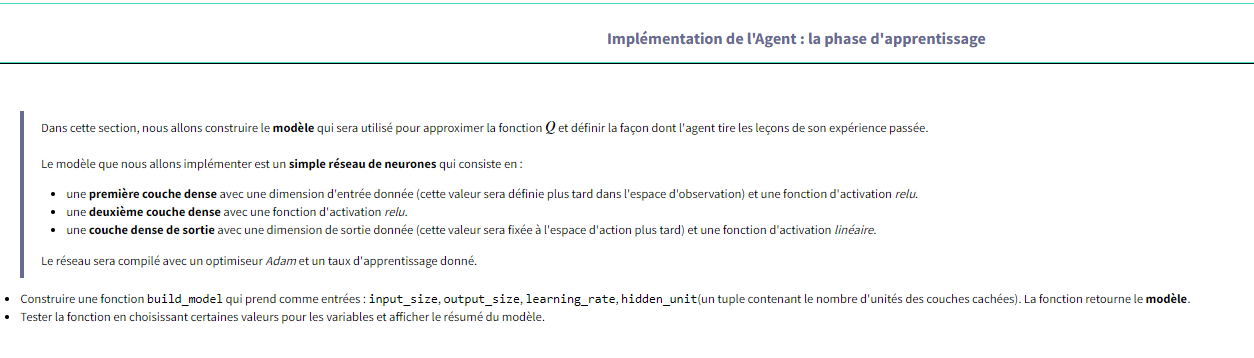

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Flatten 
from keras.optimizers import Adam 

import numpy as np

def build_model(input_size, output_size, learning_rate, hidden_unit):
    model = Sequential()
    model.add(Dense(units=hidden_unit[0], activation='relu', input_shape=(input_size, )))
    model.add(Dense(units=hidden_unit[1], activation='relu'))
    model.add(Dense(units=output_size, activation='linear'))
    model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
    return model

model = build_model(2, 1, 0.01, (10,10))
model.summary()

In [ ]:
"""
Using TensorFlow backend.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
=================================================================
Total params: 151
Trainable params: 151
Non-trainable params: 0
"""

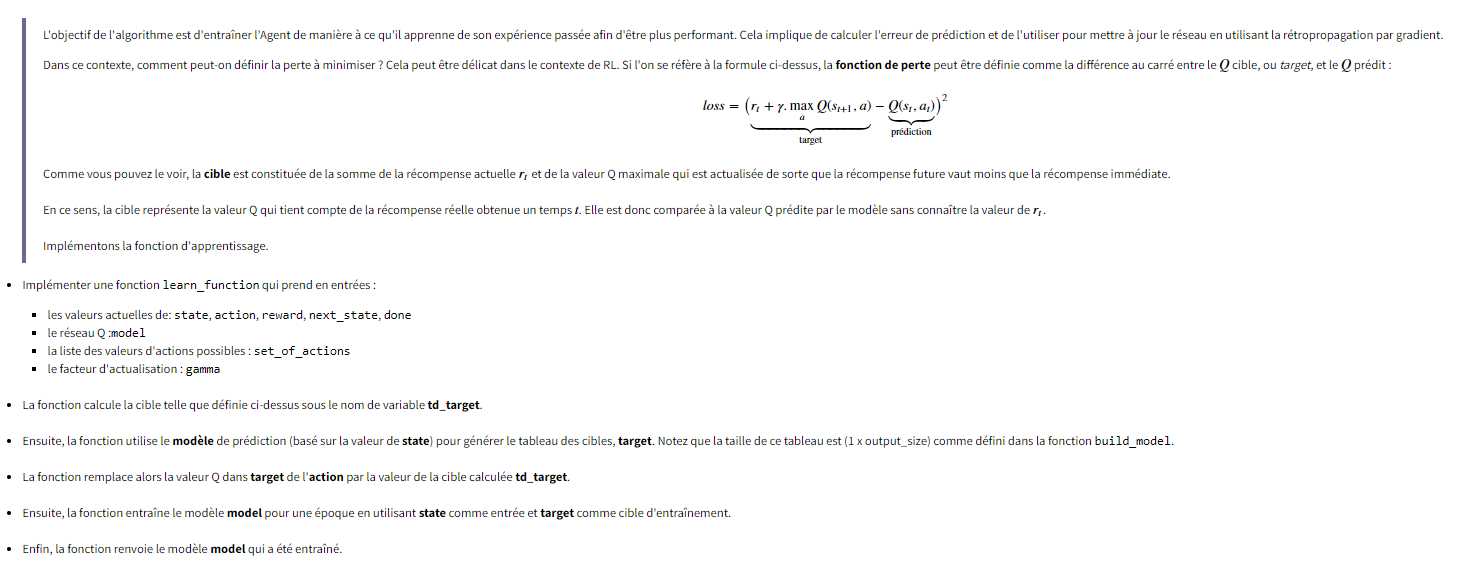

In [ ]:
def learn_function(state, action, reward, next_state, done,
                   model, set_of_actions, gamma):
    # si le prochain état est l'état final
    td_target = reward
    # si le prochain état n'est pas l'état final
    if not done:
        # la valeur Q actualisée du prochain état est ajouté
        td_target = reward + gamma * np.max(model.predict(next_state))
    target = model.predict(state)
    # la valeur Q de l'action est remplacée par la bonne valeur dans target
    i=list(set_of_actions).index(action)
    target[:, i] = td_target
    # entraînement du modèle
    model.fit(x=state, y=target, epochs=1, verbose=0)
    return model

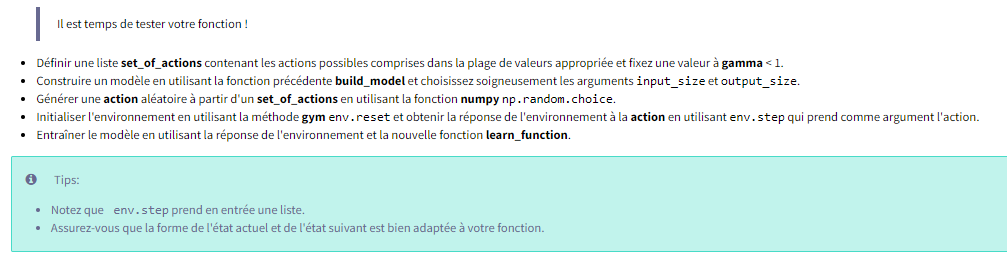

In [ ]:
set_of_actions = [-1,-0.5,0,0.5,1]
gamma = 0.95

# Construction du modèle
n_observation = env.observation_space.shape[0] # nombre d'observation par état 
n_action = len(set_of_actions) # nombre d'action
model = build_model(n_observation, n_action, 0.01, (10,10))

# Initialisation de l'environnement 
state = env.reset()

# Génération d'une action aléatoirement 
action = np.random.choice(set_of_actions)

# Obtention de la réponse de l'environnement
next_state, reward, done, info = env.step([action])

# Reshaping des variables states et next_states
next_state = next_state.reshape(1, n_observation)
state = state.reshape(1, n_observation)

# Entrainement du modèle
model = learn_function(state, action, reward, next_state, done,
                   model, set_of_actions, gamma)

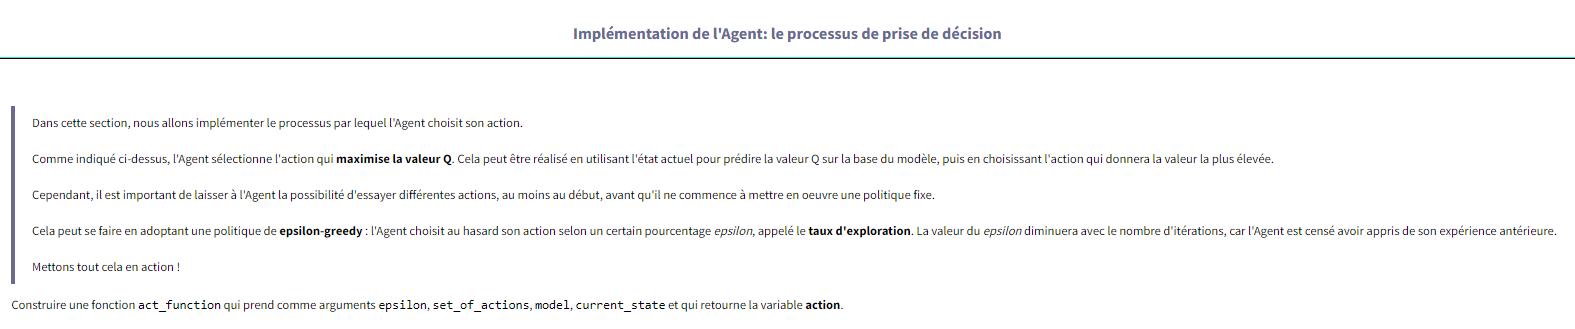

In [ ]:
def act_function(model, current_state, set_of_actions, epsilon):
    # action selon une politique epsilon-greedily
    if np.random.uniform() < epsilon:
        # action aléatoire
        action = np.random.choice(set_of_actions)
    else:
        # choix de la meilleure action à prendre selon le modèle
        q_values = model.predict(current_state)[0]
        action = set_of_actions[np.argmax(q_values)]
    return action

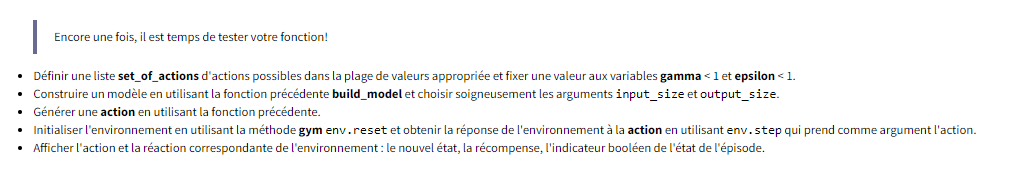

In [ ]:
set_of_actions = [-1,-0.5,0,0.5,1]
gamma = 0.95
epsilon = 0.5

# Construction d'un modèle
n_observation = env.observation_space.shape[0] # nombre d'observations
n_action = len(set_of_actions) # nombre d'action
model = build_model(n_observation, n_action, 0.01, (10,10))

# Initialisation de l'environnement 
current_state = env.reset()
current_state = current_state.reshape(1, n_observation)

# Génération d'une action aléatoirement
action = act_function(model, current_state, set_of_actions, epsilon)

# Obtention de la réponse de l'environnement
next_state, reward, done, info = env.step([action])

print("action: %.3f"%(action)) # action
print("observation: [%.3f,%.3f]"%(next_state[0],next_state[1]))
print("récompense: %.3f"%(reward)) # récompense
print("done:", done) # statut

In [ ]:
"""
action: -0.500
observation: [-0.424,-0.001]
récompense: -0.025
done: False
"""

Maintenant que nous avons toutes les fonctions dont nous avons besoin, nous pouvons tout rassembler et construire notre DQN_Online_Agent. Nous sommes sur la dernière ligne droite !

Compléter les parties manquantes de la classe DQN_Online_Agent par le code approprié.

In [ ]:
class DQN_Online_Agent:
    def __init__(self, state_size,action_range, learning_rate = 0.01, gamma=0.95, 
                 epsilon = 1, epsilon_min = 0.01, epsilon_decay = 0.995, 
                 hidden_unit= (200,200), action_step=200):
      
        self.state_size = state_size # nombre d'observation
        
        # Discrétisation de l'espace d'action
        self.action_size = action_step # nombre d'actions possibles
        self.set_of_actions = np.linspace(action_range[0],action_range[1],self.action_size) 
        # Paramètres 
        self.gamma = gamma    # facteur d'actualisation
        self.epsilon = epsilon  # taux d'exploration
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate

        # Modèle d'apprentissage
        self.model = build_model(input_size=self.state_size, output_size=self.action_size,
                                  learning_rate=self.learning_rate, hidden_unit=hidden_unit)
        
        # Variables internes
        self.current_state = None # état
        self.current_action = None # action
        
    def observe(self, obs, reward,done):
        # apprentissage à chaque étape
        obs = obs.reshape(1,self.state_size)
        self.model = learn_function(self.current_state, self.current_action, reward, obs, done, 
                                    self.model, self.set_of_actions, self.gamma)
        # mise à jour de l'action actuelle
        self.current_state = obs   

    def act(self):
        action = act_function(self.model, self.current_state, self.set_of_actions, self.epsilon)
        # mise à jour de l'action actuelle
        self.current_action = action
        return [action]

    def reset(self, initial_state):
        # initialisation du premier état
        self.current_state = initial_state.reshape(1, self.state_size)
        self.current_action = None
        # diminution d'epsilon pour réduire l'exploration
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return

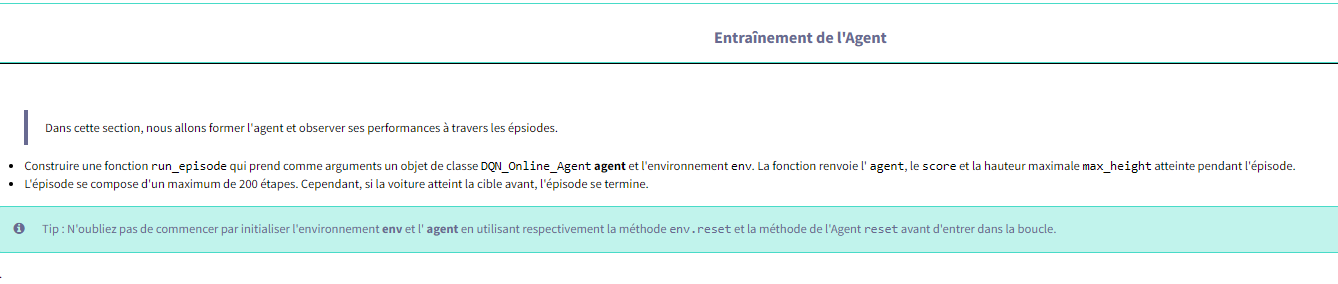

In [ ]:
def run_episode(agent,env, parameters):
    
    # initialisation de l'environnement et de l'Agent
    initial_state = env.reset()
    agent.reset(initial_state)

    score = 0 # score de l'épisode
    max_height = -1000 # hauteur maximale atteinte durant l'épisode 
    
    for i in range(200):
      
        # l'Agent choisit une action
        action = agent.act()
        # l'environnement réagit en conséquence  
        next_state, reward, done, _ = env.step(action=action) 
        # mise à jour de la hauteur maximale
        max_height = max(max_height, next_state[0])
        # l'Agent observe le nouvel état et sa récompense
        agent.observe(next_state, reward, done)

        score += reward # mise à jour du score
 
        # si l'Agent atteint la cible, l'épisode finit plus tôt
        if done:
            break
      
    return agent, score, max_height

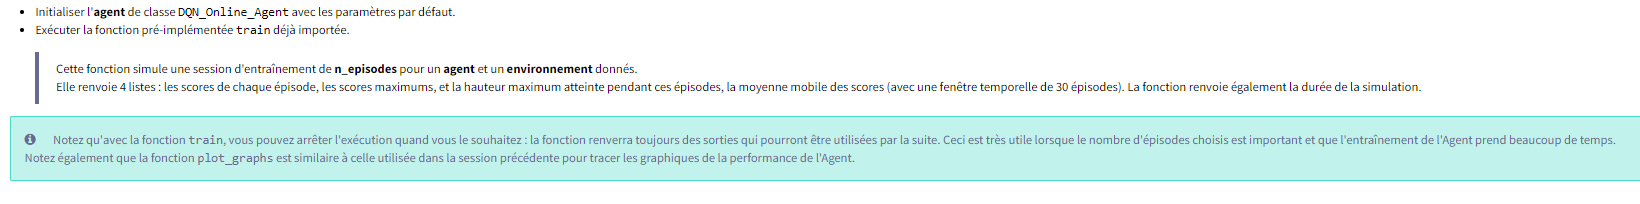

In [ ]:
from utils import train

env = gym.make('MountainCarContinuous-v0')
env.seed(2)

agent = DQN_Online_Agent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                         learning_rate = 0.01, gamma=0.95, epsilon = 1, epsilon_min = 0.01, 
                         epsilon_decay = 0.995, hidden_unit= (64,64))

scores, max_scores, max_heights, moving_average, delta_t=train(agent,env, run_episode = run_episode, n_episodes=1000,
                            verbose=True,erase=True)

In [ ]:
"""
Time elapsed :496.37s
"""

Observer graphiquement l'évolution des scores maximums et la hauteur maximale atteinte pendant les épisodes ainsi que la moyenne mobile des scores.

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(16, 8))
plt.plot(scores, alpha=.5, label='score')
plt.plot(max_scores, alpha=.5, label='max score')
plt.plot(moving_average, alpha=.5, label='moving average')
plt.ylabel("score")
plt.xlabel("iteration")
plt.title("Learning curve")
plt.legend()
plt.show()

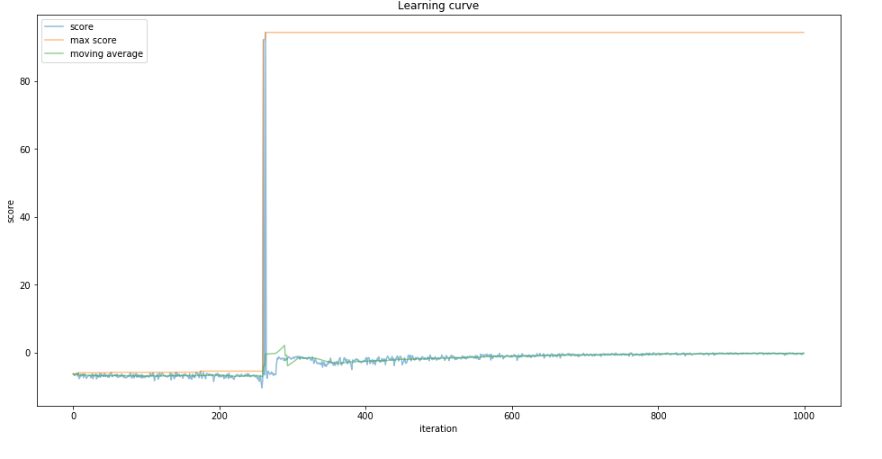

Observer graphiquement l'évolution de la hauteur maximale atteinte par la voiture au cours des épisodes et la comparer avec la hauteur cible.

In [ ]:
n = len(max_heights)

plt.figure(figsize=(16, 8))
plt.plot(max_heights, alpha=.5, label=' max car position')
plt.plot([0.5]*(n), alpha=.5, color = 'red', linestyle='dashed', label='flag position')
plt.ylabel("height")
plt.xlabel("iteration")
plt.title("Maximum height reached by the car")
plt.ylim(-1,1)
plt.legend()
plt.show()

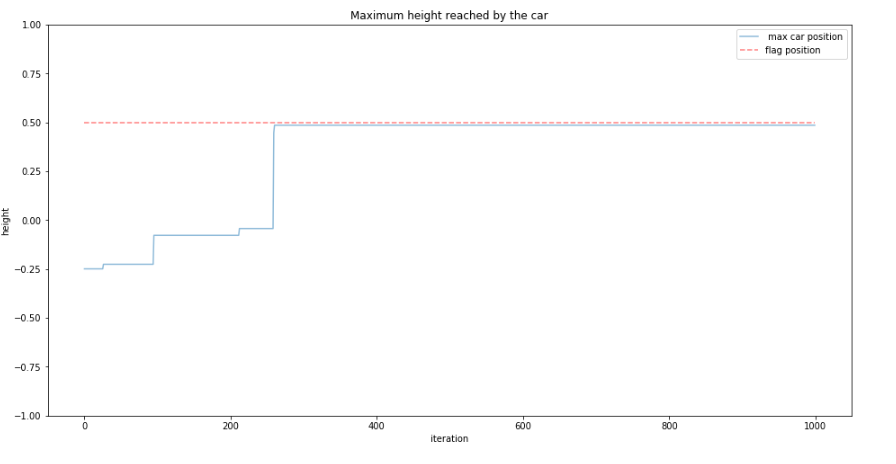

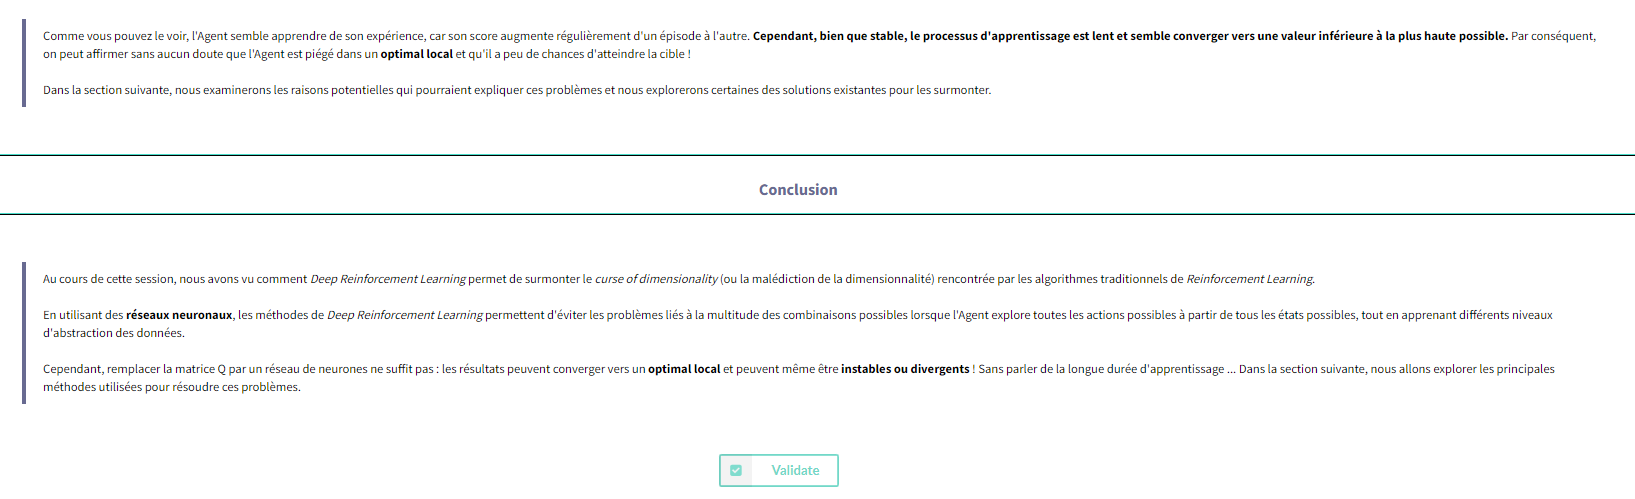

# C - Deep Q Learning - Partie 2

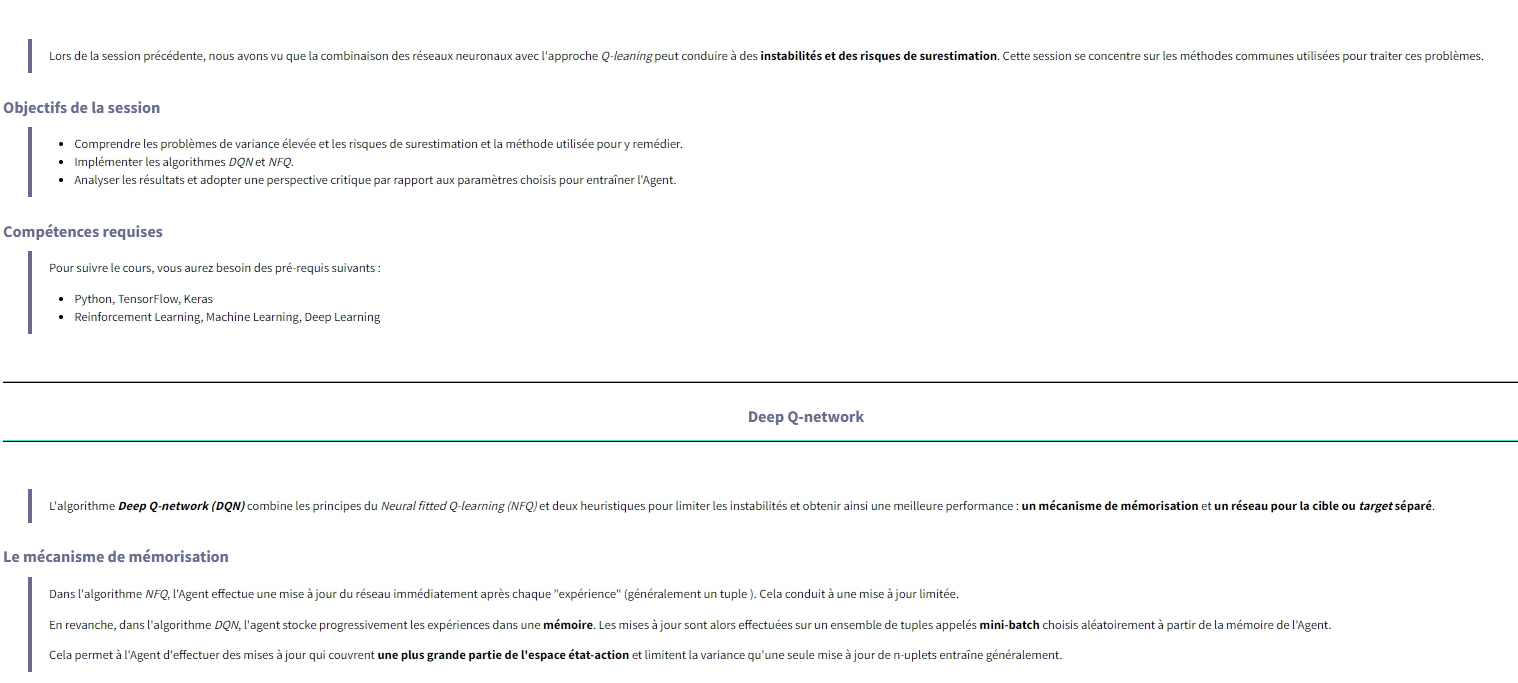

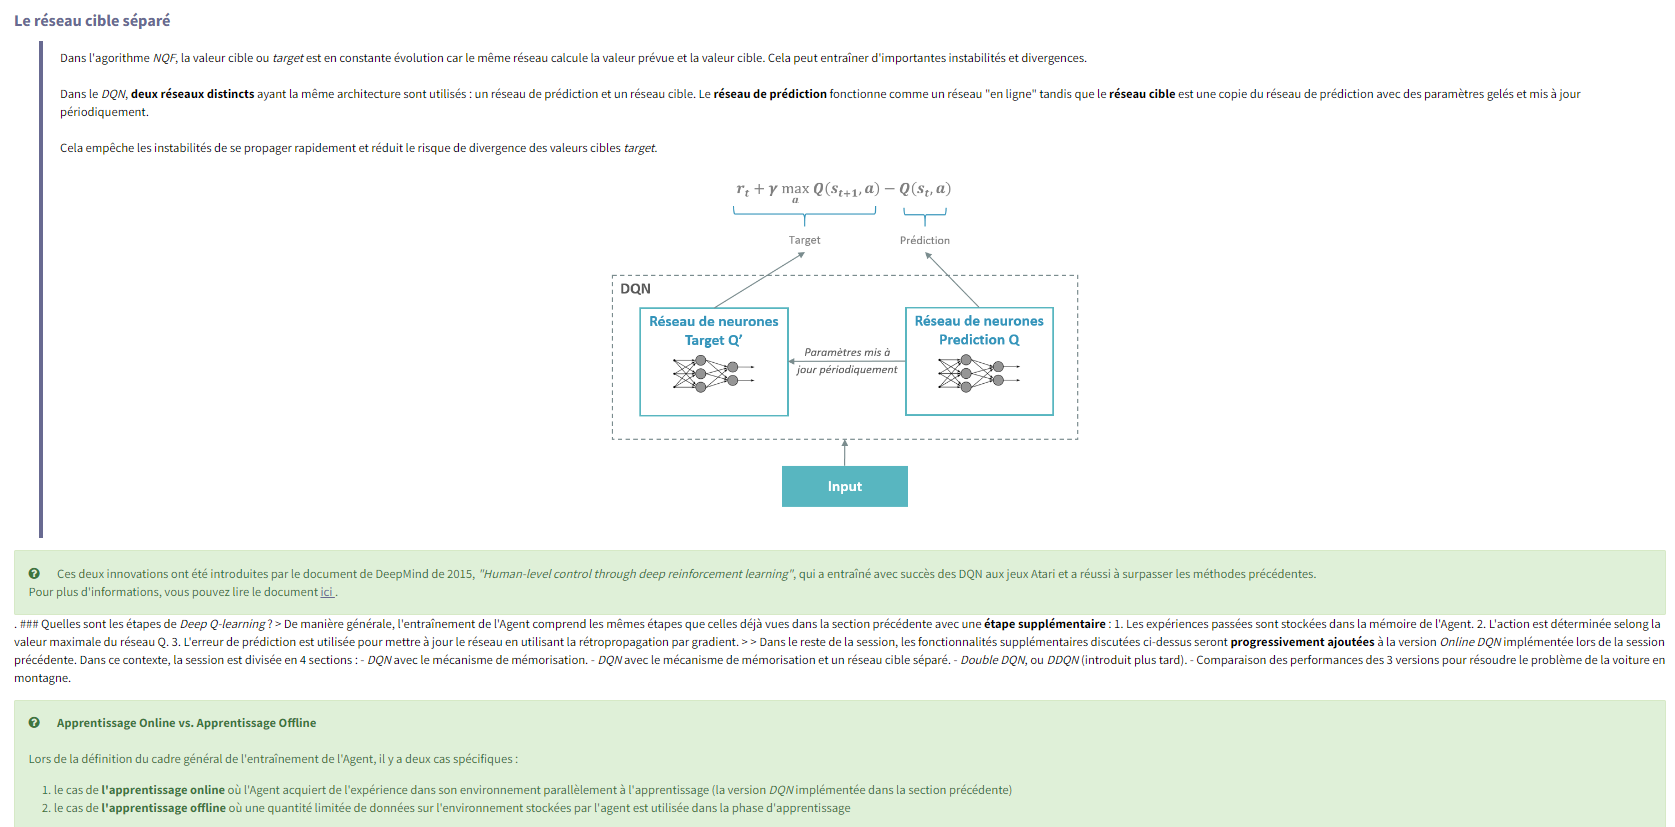

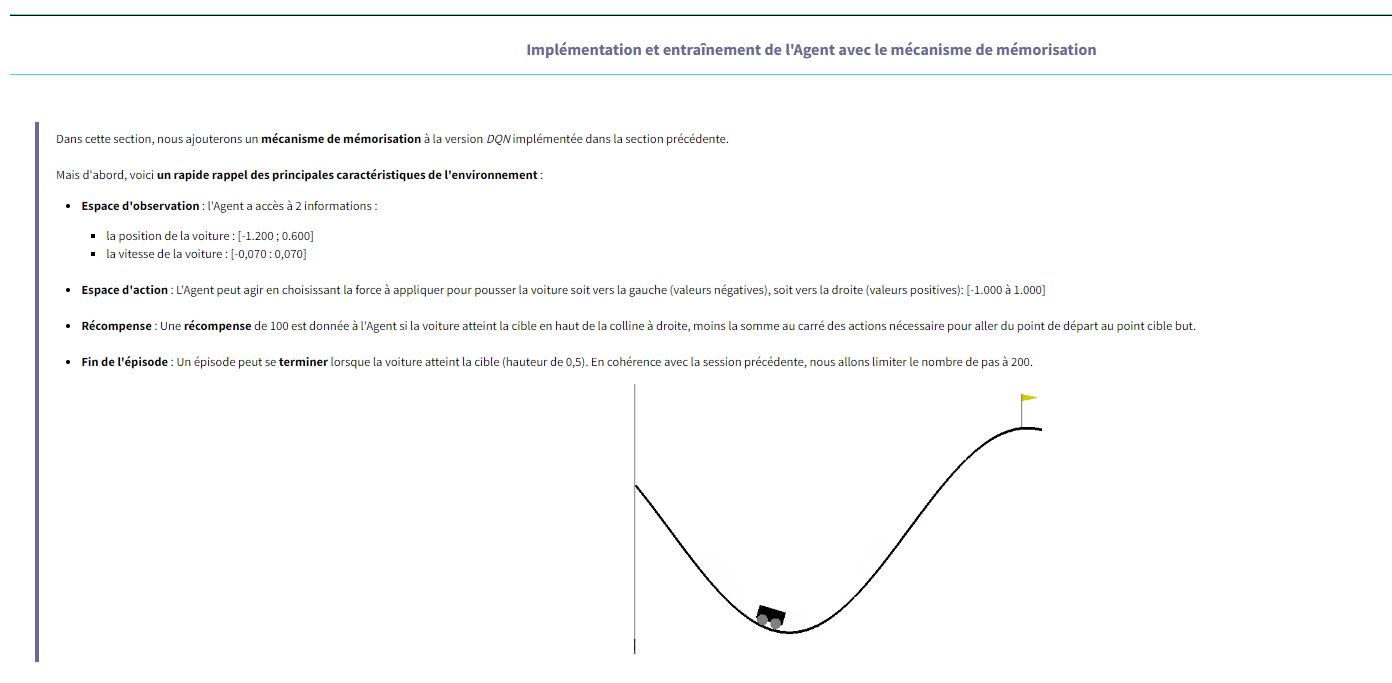

In [ ]:
def learn_function(state, action, reward, next_state, done,
                   model, set_of_actions, gamma):
    
    # si le prochain état est l'état final
    td_target = reward
    
    if not done:
        # si le prochain état n'est pas l'état final
        td_target = reward + gamma * np.max(model.predict(next_state))
    
    target = model.predict(state)
    # la valeur Q de l'action est remplacée par la bonne valeur dans target
    i=list(set_of_actions).index(action)
    target[:, i] = td_target
    
    # entraînement du modèle
    model.fit(x=state, y=target, epochs=1, verbose=0)
    
    return model

Construire la fonction learn_with_memory_function qui prend en entrées le modèle de l'Agent model, sa mémoire memory, l'ensemble des actions possible de l'environnement set_of_actions, le facteur d'actualisation gammaand, la taille du batch utilisée pour la mise à jour du réseau Q batch_size.

La fonction renvoie le modèle model une fois qu'il a été entraîné à l'aide du mini-batch et en une seule epoch.

In [ ]:
import random 
import numpy as np

def learn_with_memory_function(model, memory, set_of_actions, gamma, batch_size):
    
    # taille du batch
    batch_size = min(batch_size, len(memory))

    # échantillonnage des expériences
    batch = random.sample(memory, batch_size)

    # construction de la liste des targets
    states, targets= [],[]
    
    for state, action, reward, next_state, done in batch:
        # si l'état suivant est final
        td_target = reward
        if not done:
            # si l'état suivant n'est pas final
            td_target = reward + gamma * np.max(model.predict(next_state))
        target = model.predict(state)
        
        i=list(set_of_actions).index(action)
        target[:, i] = td_target
        
        states.append(state)
        targets.append(target)

    # entraînement de modèle
    states = np.vstack(states)
    targets = np.vstack(targets)
    model.fit(state, target, epochs=1, verbose=0)
    
    return model

Intégrons cette fonction à la classe DQNAgent_with_Memory.

Compléter les parties manquantes de la classe DQNAgent_with_Memory par le code approprié.

In [ ]:
from collections import deque
from agents import build_model, act_function

class DQNAgent_with_Memory:
    def __init__(self, state_size,action_range, learning_rate = 0.01, gamma=0.95, 
                 epsilon = 1, epsilon_min = 0.01, epsilon_decay = 0.995, 
                 hidden_unit= (64,64), batch_size=100, memory_size=200, action_step=200):
      
        self.state_size = state_size # nombre d'observations
        
        # Discrétisation de l'espace d'action
        self.action_size = action_step # nombre d'actions possibles
        self.set_of_actions = np.linspace(action_range[0],action_range[1],self.action_size)
        
        # Parameters 
        self.gamma = gamma    # facteur d'actualisation
        self.epsilon = epsilon  # taux d'exploration
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Modèle d'apprentissage
        self.model = build_model(input_size=self.state_size, output_size=self.action_size,
                                  learning_rate=self.learning_rate,hidden_unit=hidden_unit)
        
        # Variables internes
        self.current_state = None
        self.current_action = None
        
        # initialisation de la mémoire en utilisant la fonction 'deque' de python
        # et en limitant la taille de la mémoire à 'memory_size'
        self.memory = deque(maxlen=memory_size)
        
    def observe(self, obs, reward,done):
        # ajout de l'observation à la mémoire
        obs=obs.reshape(1,self.state_size)
        self.memory.append((self.current_state, self.current_action, reward, obs, done))
        # mise à jour 
        self.current_state = obs

    def act(self):
        action = act_function(self.model, self.current_state, self.set_of_actions, self.epsilon)
        # mise à jour de l'action actuelle
        self.current_action = action
        return [action]

    def reset(self, initial_state):
        # apprentissage à chaque étape
        if len(self.memory) >0 :
            self.model = learn_with_memory_function(self.model, self.memory, self.set_of_actions, 
                                                self.gamma, self.batch_size)

        # initialisation du premier état
        self.current_state = initial_state.reshape(1, self.state_size)
        self.current_action = None

        # diminution d'epsilon pour réduire l'exploration
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return
    
""" Using TensorFlow backend. """    

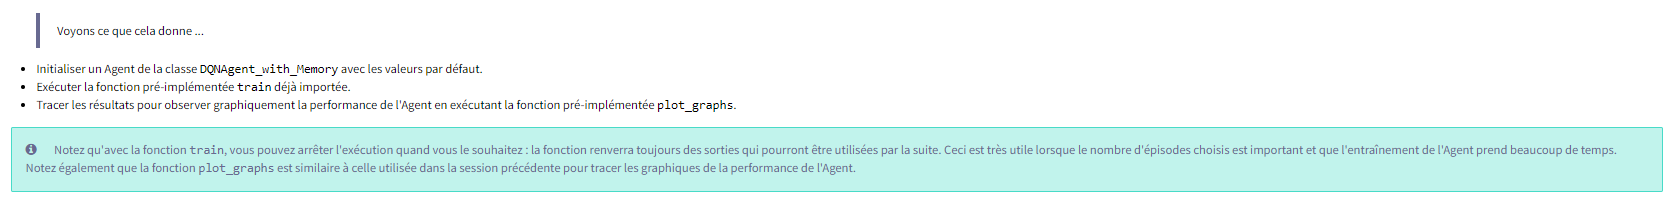

In [ ]:
import gym
from utils import train, plot_graphs

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = DQNAgent_with_Memory(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                  learning_rate = 0.01, gamma=0.95, epsilon = 1, epsilon_min = 0.01, 
                  epsilon_decay = 0.995, hidden_unit= (64,64), batch_size = 100, memory_size=200)

# Entraînement de l'Agent
scores_1, max_scores_1, max_heights_1, moving_average_1, delta_t_1=train(agent,env,n_episodes=700,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_1, max_scores_1, max_heights_1, moving_average_1)

"""  
episode 306/700:	score:	-1.883568596752605....

Time elapsed :106.68s
<Figure size 1600x800 with 1 Axes>  mais on ne voit pas les figures !!!
<Figure size 1600x800 with 1 Axes>
"""

Est-ce qu'on obtient de meilleurs résultats avec le mécanisme de mémoire ?

Importer la classe DQN_Online_Agent de agent.
Initialiser un agent à partir de cette classe avec les valeurs par défaut.
Exécuter les fonctions pré-implémentées train et plot_graphs. Observer les résultats.

In [ ]:
import gym
from utils import train, plot_graphs
from agents import DQN_Online_Agent

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = DQN_Online_Agent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                         learning_rate = 0.01, gamma=0.95, epsilon = 1, epsilon_min = 0.01, 
                         epsilon_decay = 0.995, hidden_unit= (64,64))

# Entraînement de l'Agent
scores_0, max_scores_0, max_heights_0, moving_average_0, delta_t_0=train(agent,env,n_episodes=700,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_0, max_scores_0, max_heights_0, moving_average_0)

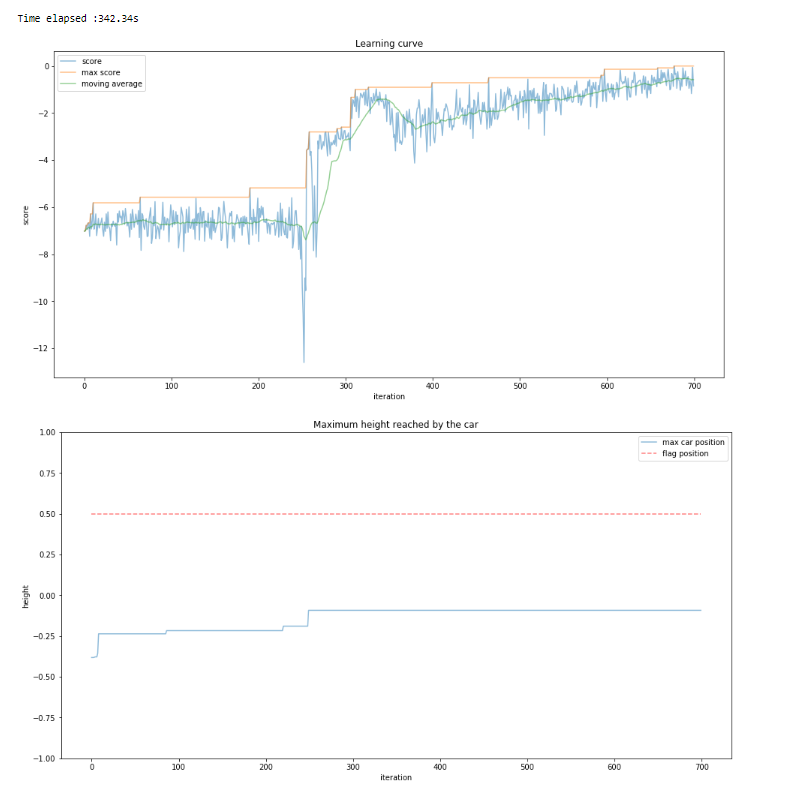

Comparer les performances des deux Agents en faisant tourner la cellule ci-dessous.
Qu'observez-vous ?

In [ ]:
print("Temps d'entraînement pour DQN_OnlineAgent :%.3f"%(delta_t_0))
print("Temps d'entraînement pour DQN with Memory Replay :%.3f"%(delta_t_1))

plot_graphs([scores_0, scores_1], [max_scores_0, max_scores_1], 
            [max_heights_0, max_heights_1], [moving_average_0, moving_average_1],
            n_agents = 2, names = ["DQN Online","DQN with Memory Replay"])

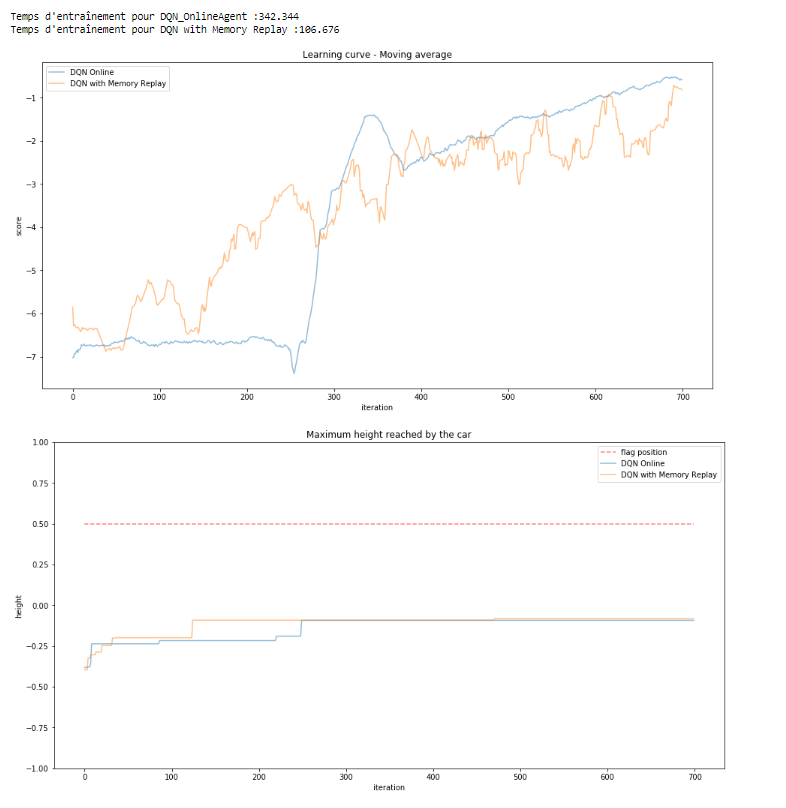

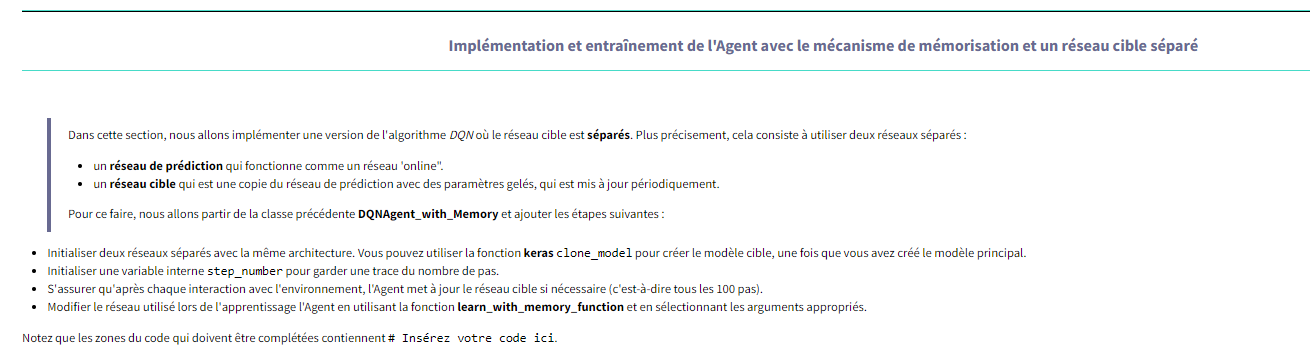

In [ ]:
from keras.models import clone_model
from agents import build_model, act_function

class DQNAgent:
    def __init__(self, state_size,action_range, learning_rate = 0.01, gamma=0.95, 
                 epsilon = 1, epsilon_min = 0.01, epsilon_decay = 0.995, 
                 hidden_unit= (64,64), batch_size=100,memory_size=200, action_step=200):
      
        self.state_size = state_size # nombre d'observations
        
        # Discrétisation de l'espace d'action
        self.action_size = action_step # nombre d'actions possibles
        self.set_of_actions = np.linspace(action_range[0],action_range[1],self.action_size)
        
        # Paramètres 
        self.gamma = gamma    # facteur d'actualisation
        self.epsilon = epsilon  # taux d'exploration
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Modèle d'apprentissage
        # initialisation de deux réseaux en utilisant la fonction keras 'clone_model'
        self.model = build_model(input_size=self.state_size, output_size=self.action_size,
                                  learning_rate=self.learning_rate, hidden_unit=hidden_unit)
          
        self.target_model = clone_model(self.model) # réseau cible
        
        # Variables internes
        self.current_state = None
        self.current_action = None
        self.memory = deque(maxlen=memory_size) # memoire
        
        # initialisation d'un compteur pour le nombre de pas
        self.step_number=0
        
    def observe(self, obs, reward,done): 
        
        # ajout de l'expérience à la mémoire
        obs = obs.reshape(1,self.state_size)
        self.memory.append((self.current_state, self.current_action, reward, obs, done))
        
        # mise à jour de l'observation
        self.current_state = obs
        
        # mise à jour du réseau target tout les 100 étapes
        self.step_number +=1
        if self.step_number % 100 ==0:
            self.target_model = clone_model(self.model)
        return

    def act(self):
        action = act_function(self.model, self.current_state, self.set_of_actions, self.epsilon)
        
        # mise à jour de l'action actuelle
        self.current_action = action
        return [action]

    def reset(self, initial_state):
        # apprentissage à chaque étape
        
        if len(self.memory) >0 :
            self.model = learn_with_memory_function(self.model, self.memory, self.set_of_actions, 
                                                self.gamma, self.batch_size)

        # initialisation du premier état
        self.current_state = initial_state.reshape(1, self.state_size)
        self.current_action = None

        # diminution d'epsilon pour réduire l'exploration
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return

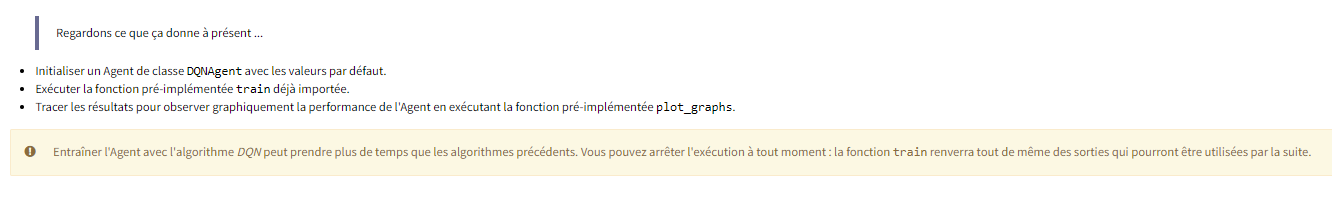

In [ ]:
import gym
from utils import train, plot_graphs

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = DQNAgent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                  learning_rate = 0.01, gamma=0.95, epsilon = 1, epsilon_min = 0.01, 
                  epsilon_decay = 0.995, hidden_unit= (64,64), batch_size=100, memory_size=200)

# Entraînement de l'Agent
scores_2, max_scores_2, max_heights_2, moving_average_2, delta_t_2=train(agent,env,n_episodes=700,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_2, max_scores_2, max_heights_2, moving_average_2)

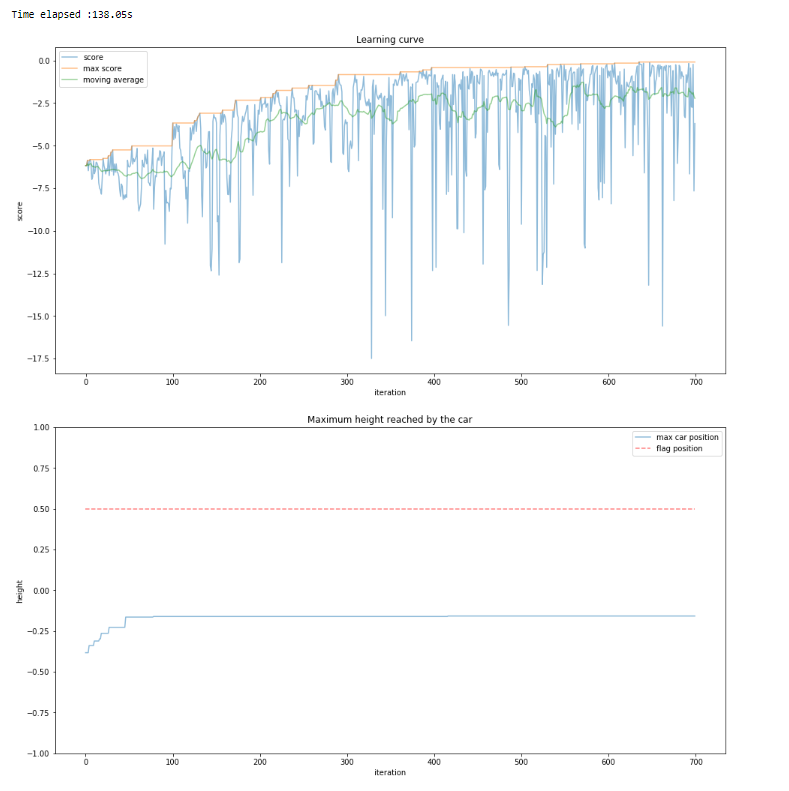

Encore une fois, comparons les performances des nouveaux Agents par rapport aux autres versions.

Exécution de la cellule ci-dessous.
Qu'observez-vous ?

In [ ]:
# Comparaison des durées de simulation
print("Temps d'entraînement pour DQN_OnlineAgent :%.3f"%(delta_t_0))
print("Temps d'entraînement pour DQN avec mémoire :%.3f"%(delta_t_1))
print("Temps d'entraînement pour DQN avec mémoire et réseaux séparés :%.3f"%(delta_t_2))

# Comparaison des performances des agents
plot_graphs([scores_0, scores_1, scores_2], 
            [max_scores_0, max_scores_1, max_scores_2], 
            [max_heights_0, max_heights_1, max_heights_2], 
            [moving_average_0, moving_average_1, moving_average_2],
            n_agents = 3, 
            names = ["DQN Online","DQN avec mémoire", "DQN avec mémoire et réseaux séparés"])

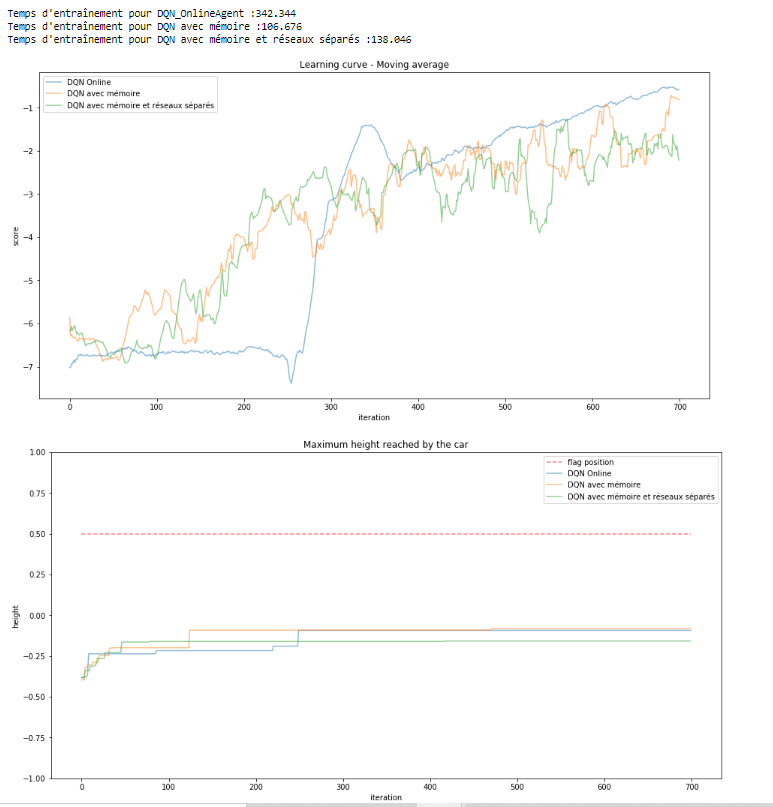

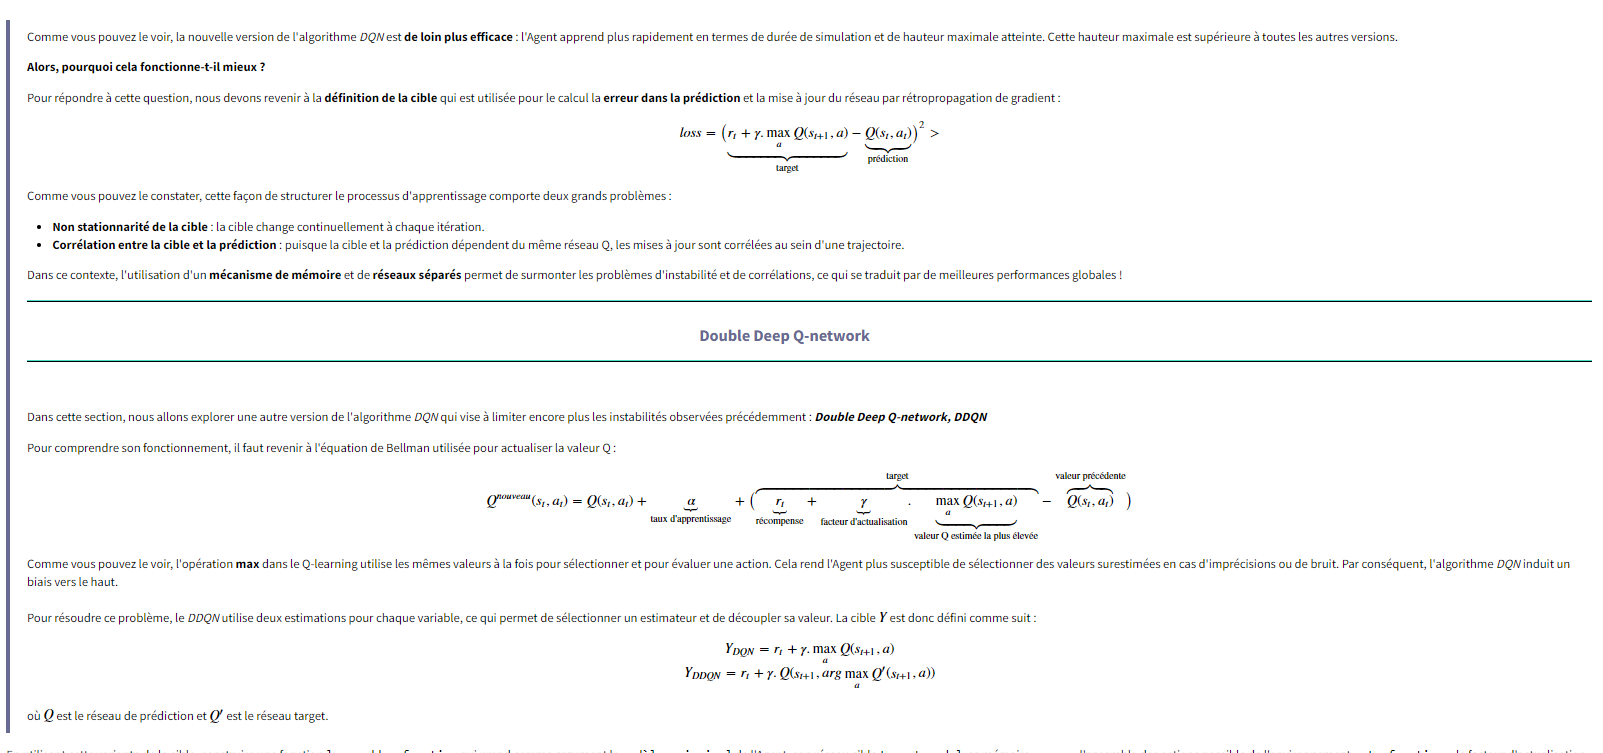

En utilisant cette variante de la cible, construire une fonction learn_ddqn_function qui prend comme argument le modèle_principal de l'Agent, son réseau cible target_model, sa mémoire memory, l'ensemble des actions possible de l'environnement set_of_actions, le facteur d'actualisation gammaet, la taille du batch utilisée pour mettre à jour la batch_size du réseau Q.

La fonction renvoie model une fois que le modèle a entraîné le mini-batch et avec une seule epoch.

In [ ]:
def learn_ddqn_function(main_model, target_model, memory, set_of_actions, gamma, batch_size):
    
    # taille du batch
    batch_size = min(batch_size, len(memory))

    # échantillonage des expériences
    batch = random.sample(memory, batch_size)

    # calcul de la liste target
    states, targets= [],[]

    for state, action, reward, next_state, done in batch:
        # si le prochain état est l'état final
        td_target = reward
        if not done:
            # si le prochain état n'est pas l'état final
            td_target = reward + gamma * np.max(target_model.predict(next_state))
        target = main_model.predict(state)
        # la valeur Q de l'action est remplacée par la bonne valeur dans target
        i=list(set_of_actions).index(action)
        target[:, i] = td_target
        
        states.append(state)
        targets.append(target)

    # entraînement du modèle
    states = np.vstack(states)
    targets = np.vstack(targets)
    main_model.fit(state, target, epochs=1, verbose=0)
    
    return main_model

In [ ]:
implémenter la classe DDQNAgent qui intègre la nouvelle fonction learn_ddqn_function en exécutant le code ci-dessous.

In [ ]:
from keras.models import clone_model
from agents import build_model, act_function

class DDQNAgent:
    def __init__(self, state_size,action_range, learning_rate = 0.01, gamma=0.95, 
                 epsilon = 1, epsilon_min = 0.01, epsilon_decay = 0.995, 
                 hidden_unit= (64,64), batch_size=100,memory_size=200, action_step=200):
      
        self.state_size = state_size # nombre d'observations
        
        # Discrétisation de l'espace d'action
        self.action_size = action_step # nombre d'actions possibles
        self.set_of_actions = np.linspace(action_range[0],action_range[1],self.action_size)
        
        # Paramètres 
        self.gamma = gamma    # facteur d'actualisation
        self.epsilon = epsilon  # taux d'exploration
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Modèles d'apprentissage
        self.model = build_model(input_size=self.state_size, output_size=self.action_size,
                                  learning_rate=self.learning_rate, hidden_unit=hidden_unit)
        self.target_model = clone_model(self.model) # target model
        
        # Variables internes
        self.current_state = None
        self.current_action = None
        self.memory = deque(maxlen=memory_size) # memory
        
        # définition d'un compteur de pas
        self.step_number=0
        
    def observe(self, obs, reward,done):
        
        # mise à jour de la mémoire 
        obs = obs.reshape(1,self.state_size)
        self.memory.append((self.current_state, self.current_action, reward, obs, done))
        
        # mise à jour de l'observation
        self.current_state = obs
        
        # mise à jour du réseau cible tout les 100 pas
        self.step_number +=1
        if self.step_number % 100 ==0:
            self.target_model = clone_model(self.model)
        return

    def act(self):
        action = act_function(self.model, self.current_state, self.set_of_actions, self.epsilon)
        # mise à jour de l'action
        self.current_action = action
        return [action]

    def reset(self, initial_state):
        # apprentissage à chaque étape
        if len(self.memory) >0 :
            self.model = learn_ddqn_function(self.model, self.target_model, self.memory, self.set_of_actions, 
                                                self.gamma, self.batch_size)

        # initialisation du premier état 
        self.current_state = initial_state.reshape(1, self.state_size)
        self.current_action = None

        # diminution d'epsilon pour réduire l'exploration
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return

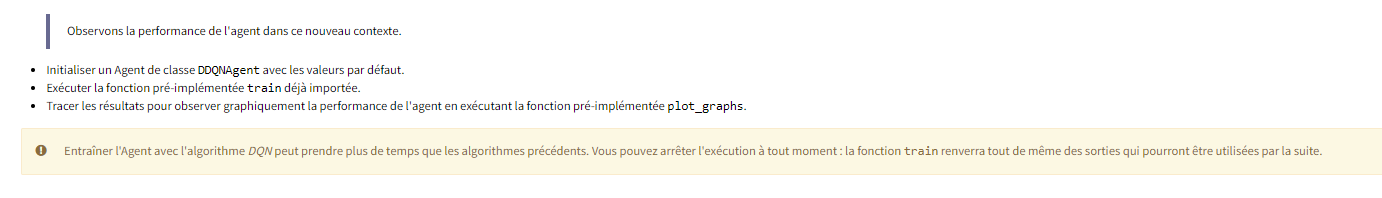

In [ ]:
import gym
from utils import train, plot_graphs

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = DDQNAgent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                  learning_rate = 0.01, gamma=0.95, epsilon = 1, epsilon_min = 0.01, 
                  epsilon_decay = 0.995, hidden_unit= (64,64), batch_size=100, memory_size=200)

# Entraînement de l'Agent
scores_3, max_scores_3, max_heights_3, moving_average_3, delta_t_3=train(agent,env,n_episodes=700,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_3, max_scores_3, max_heights_3, moving_average_3)

# -> episode 392/700:	score:	-3.033236534430944

""" kernel planté..."""

Nous voilà enfin : l'ultime comparaison !

Faites tourner la cellule ci-dessous.
Qu'observez-vous ?

In [ ]:
# Comparaison des durées de simulation
print("Temps d'entraînement pour DQN_OnlineAgent :%.3f"%(delta_t_0))
print("Temps d'entraînement pour DQN avec mémoire :%.3f"%(delta_t_1))
print("Temps d'entraînement pour DQN avec mémoire et réseaux séparés :%.3f"%(delta_t_2))
print("Temps d'entraînement pour DDQN :%.3f"%(delta_t_3))

# Comparaison des performances des agents
plot_graphs([scores_0, scores_1, scores_2, scores_3], 
            [max_scores_0, max_scores_1, max_scores_2, max_scores_3], 
            [max_heights_0, max_heights_1, max_heights_2, max_heights_3], 
            [moving_average_0, moving_average_1, moving_average_2, moving_average_3],
            n_agents = 4, 
            names = ["DQN Online","DQN avec mémoire", "DQN avec mémoire et réseaux séparés","DDQN"])

In [ ]:
""" a voir output ..."""

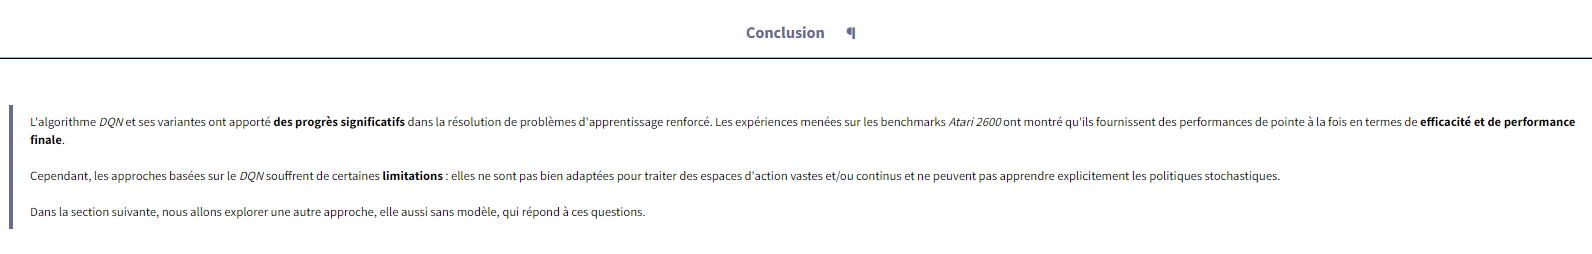

# D - Policy Gradient - Partie 1 

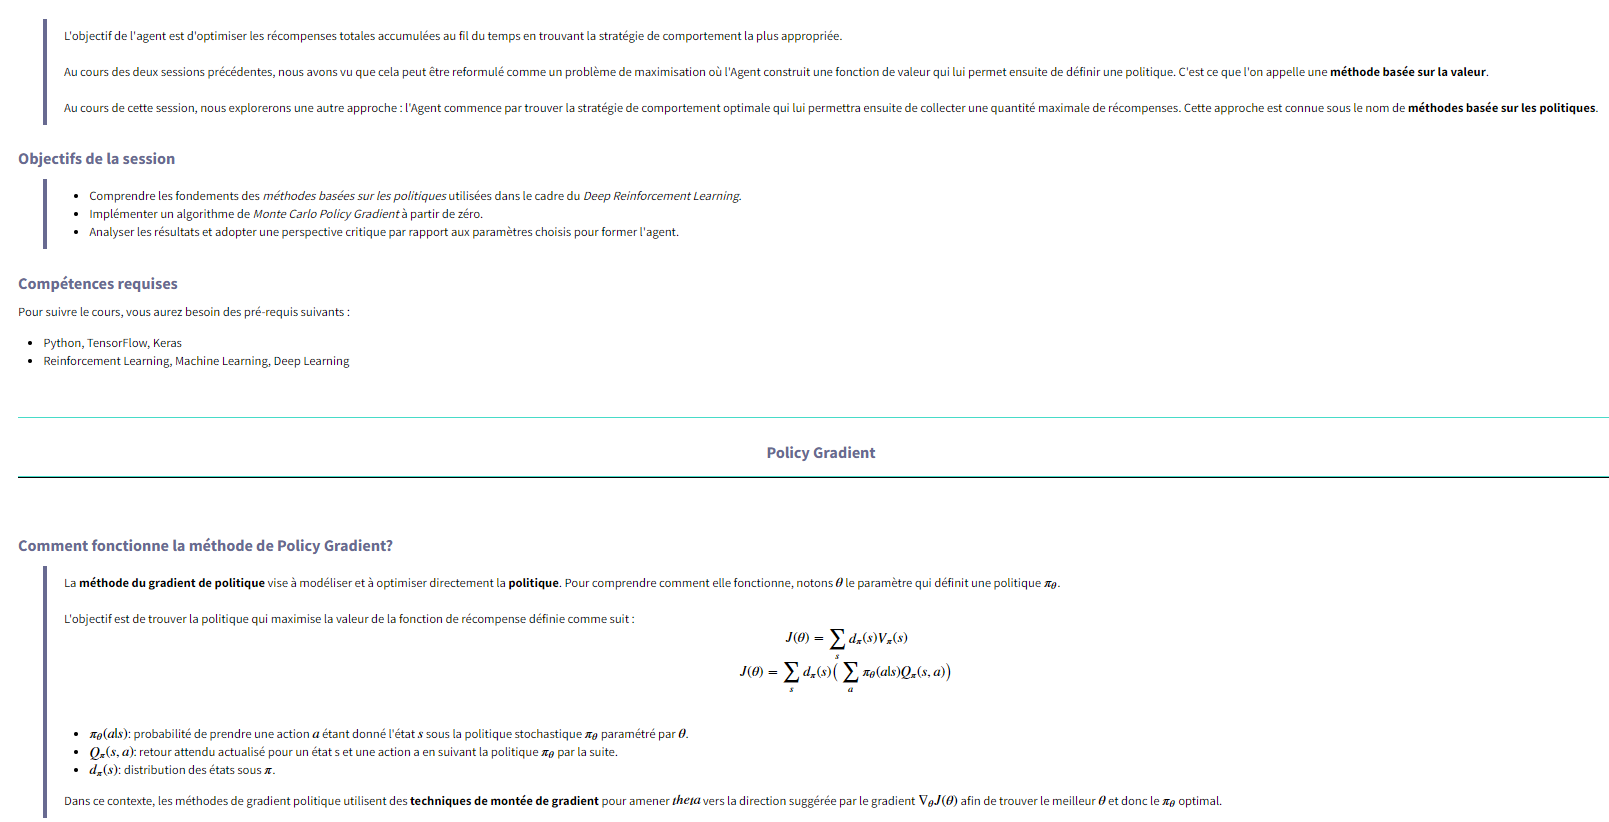

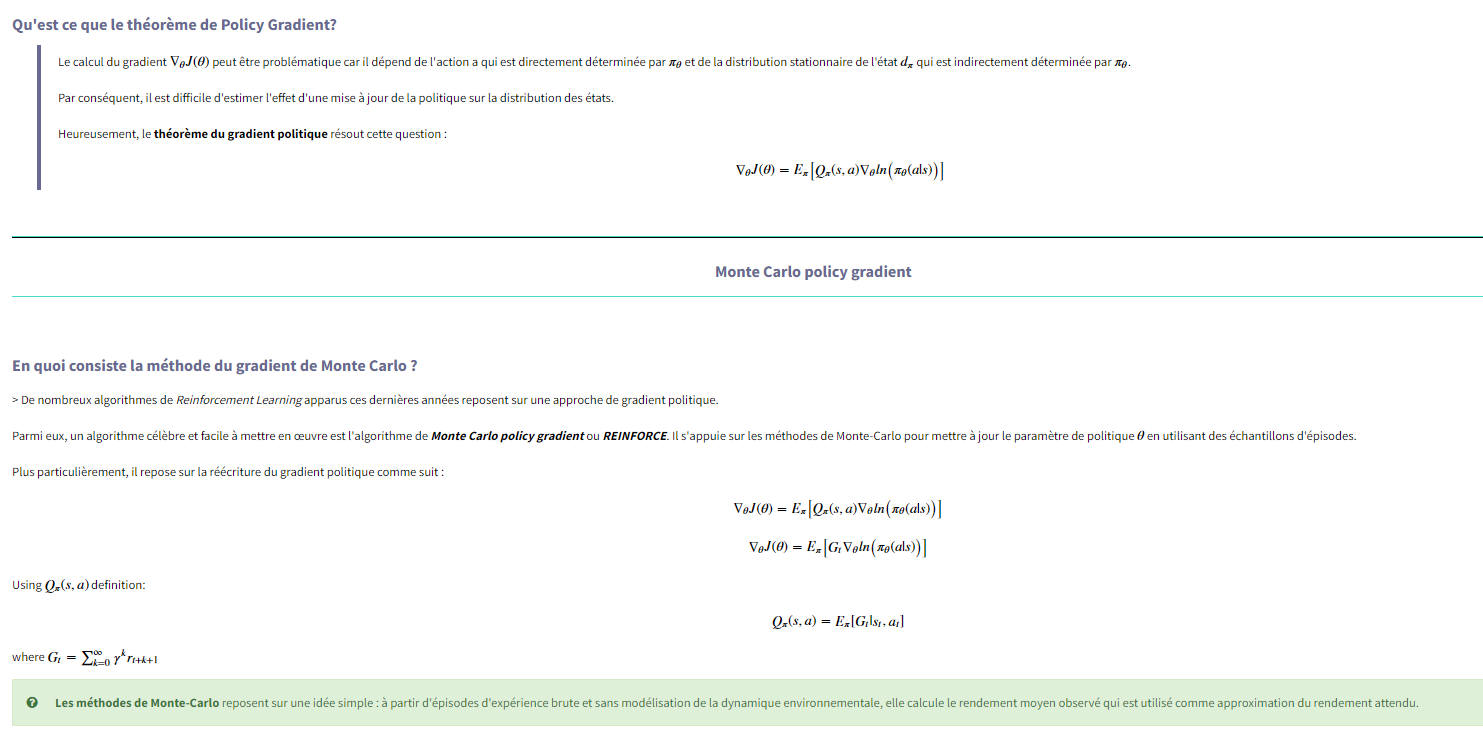

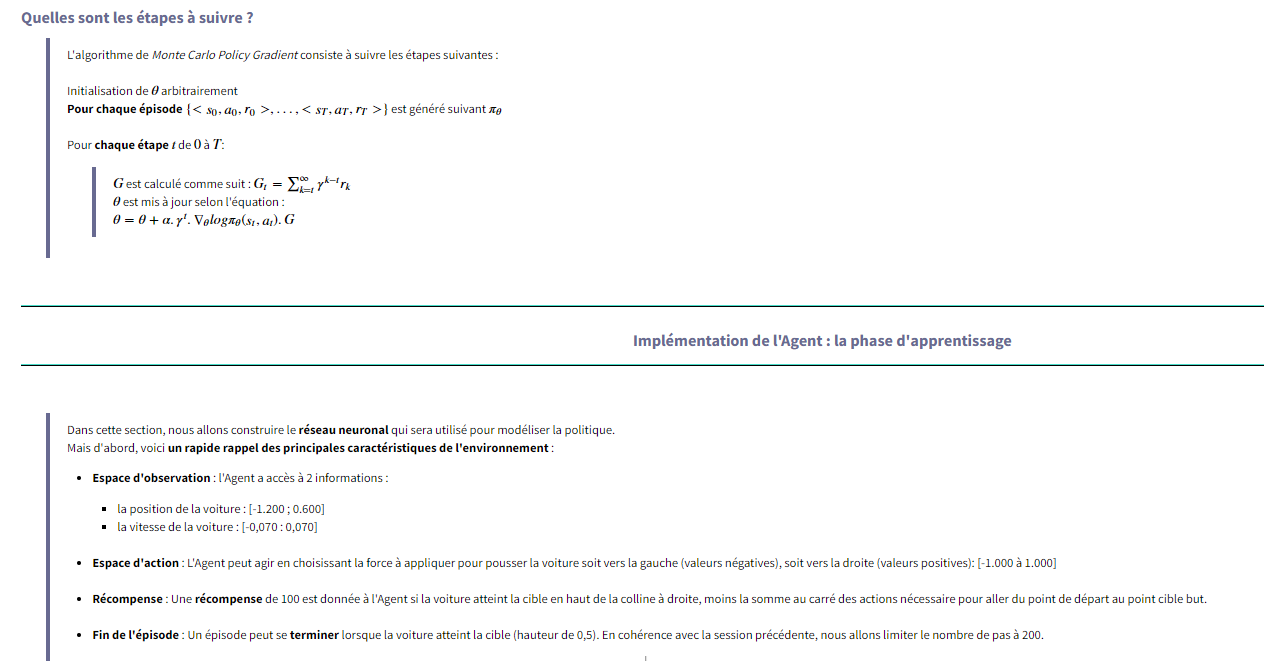

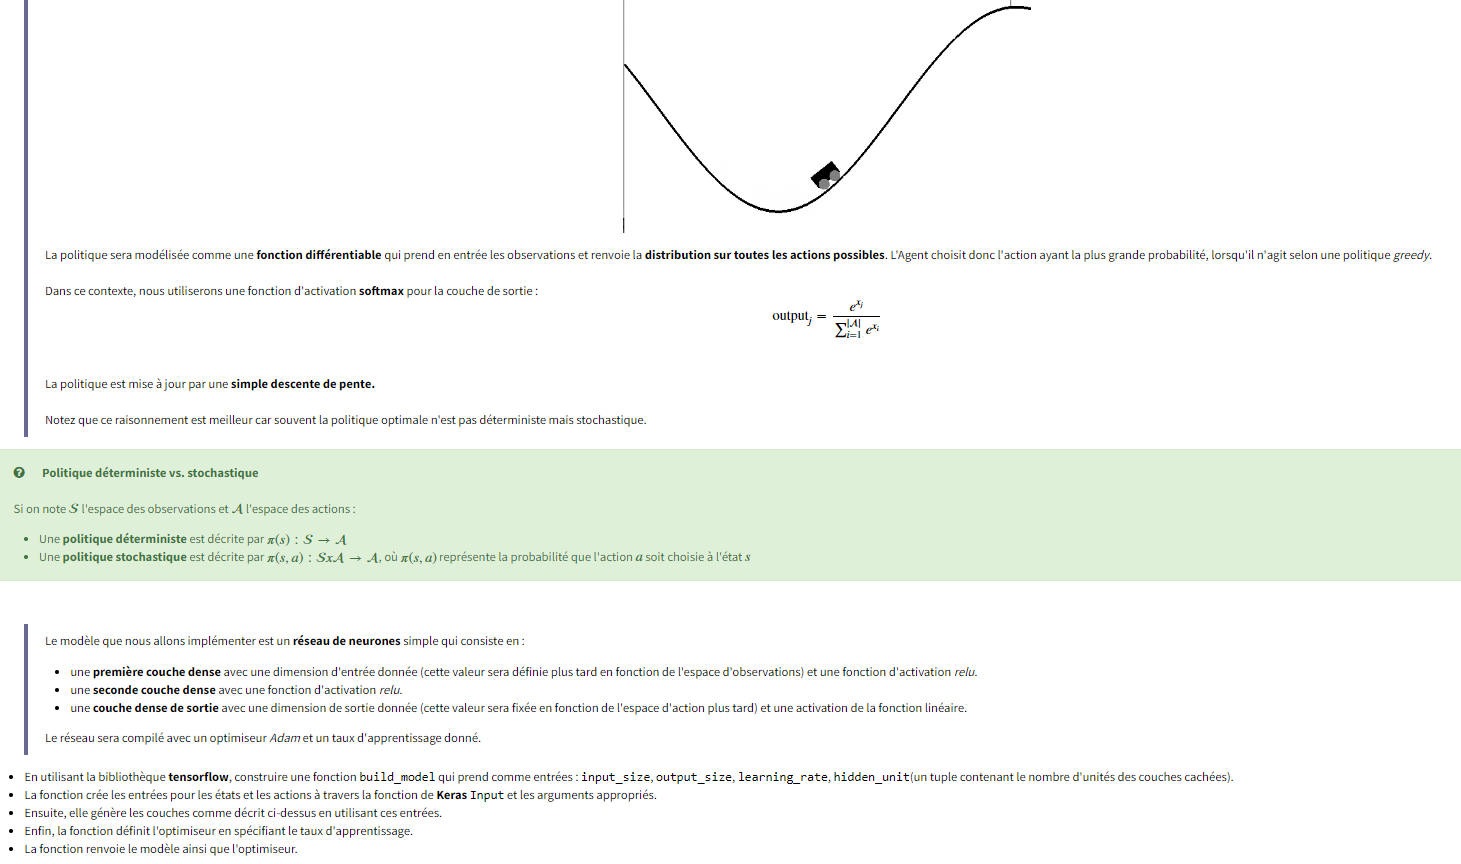

Tester la fonction en choisissant quelques valeurs pour les variables.

In [2]:
import tensorflow as tf
from tensorflow.keras import Input, Model, layers, optimizers

def build_model(input_size, output_size, hidden_units, learning_rate):

    # création des inputs pour les états et actions
    states_input = Input(shape=[input_size], dtype=tf.float64)
    actions_input = Input(shape=[output_size], dtype=tf.float64)

    # création des couches
    first_layer = layers.Dense(units=hidden_units[0], activation='relu')(states_input)
    second_layer = layers.Dense(units=hidden_units[1], activation='relu')(first_layer)
    output_layer = layers.Dense(units=output_size, activation=None)(second_layer)
    model = Model(inputs = states_input , outputs = output_layer)
  
    # définition de l'optimiseur 
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    return model, optimizer

# changement de toutes les couches pour avoir dtype float64 par défaut
tf.keras.backend.set_floatx('float64')
# test de la fonction avec quelques variables données
model, opt = build_model(2, 5, (10,10), 0.01)

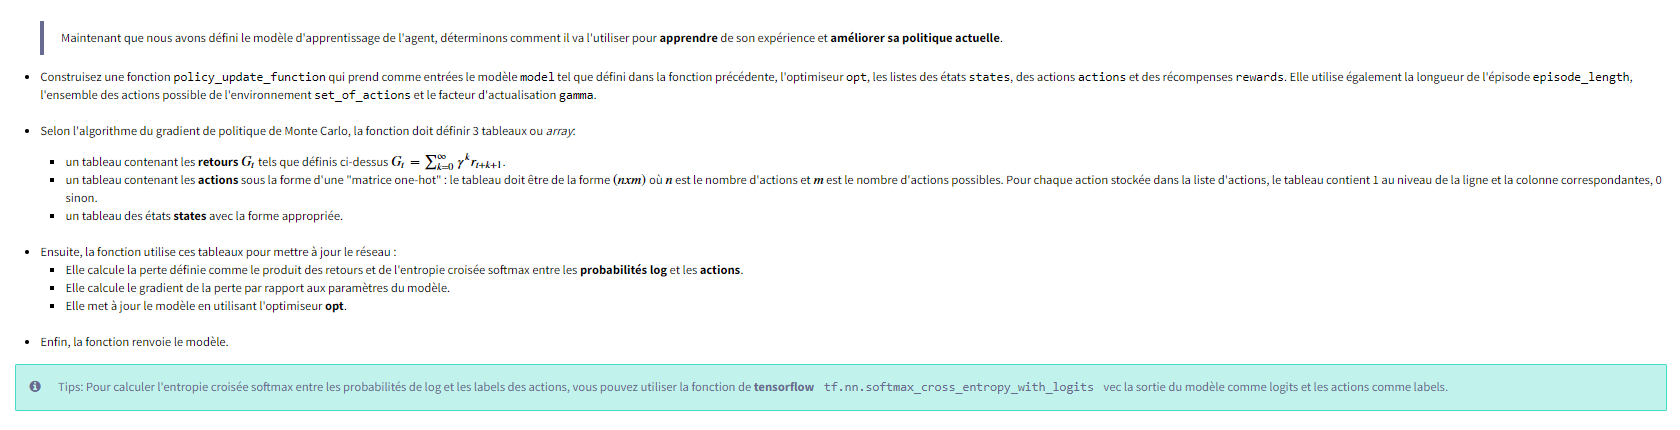

In [3]:
def policy_update_function(model, opt, states, actions, rewards, episode_length, 
                           set_of_actions, gamma):
    
    # nombre d'actions possibles
    action_size = len(set_of_actions) 
    # nombre d'observations par état
    state_size = states[0].shape[1]
    
    # création du tableau pour les retours
    gammas_exp = [i for i in range(episode_length)]
    gammas = np.power(gamma, gammas_exp)
    returns_ = [np.dot(rewards[i:], gammas[:episode_length-i]) for i in range(episode_length)]
    returns_ = np.array(returns_).reshape(-1,1) # reshaping the array
   
    # création du tableau pour les actions
    actions_ = np.zeros(shape=(episode_length, action_size))
    for index, act in enumerate(actions):
        j = list(set_of_actions).index(act)
        actions_[index, j] = 1
    
    # reshaping du tableau des états
    states_ = np.array(states).reshape(-1, state_size)
        
    # gradient descent 
    with tf.GradientTape() as tape:
        theta = model.trainable_variables
        log_prob = model(states_)
        log_prob = tf.nn.softmax_cross_entropy_with_logits(labels=actions_, logits=log_prob)
        loss = tf.reduce_mean(tf.multiply(log_prob, returns_))
    grads = tape.gradient(loss,theta)
    
    # mise à jour du modèle
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return model

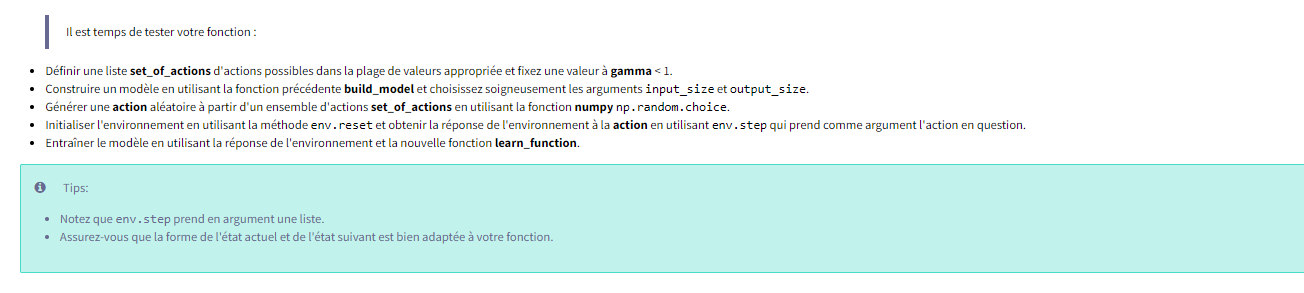

In [4]:
import numpy as np
import gym 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

set_of_actions = [-1,-0.5,0,0.5,1]
gamma = 0.95
episode_length = 1

# Construction du modèle
n_observation = env.observation_space.shape[0] # nombre de variables number of variables in the obervation space 
n_action = len(set_of_actions) # number of action
model, opt = build_model(n_observation, n_action, (10,10),0.01)

# Initialisation de l'environnement 
state = env.reset()

# Génération d'une action aléatoirement 
action = np.random.choice(set_of_actions)

# Obtention de la réponse de l'environnement
next_state, reward, done, info = env.step([action])

# Reshaping des variables states et next_states
next_state = next_state.reshape(1, n_observation)
state = state.reshape(1, n_observation)

# Entrainement du modèle
model= policy_update_function(model, opt, [state], [action], [reward], episode_length, 
                           set_of_actions, gamma)

ModuleNotFoundError: No module named 'gym'

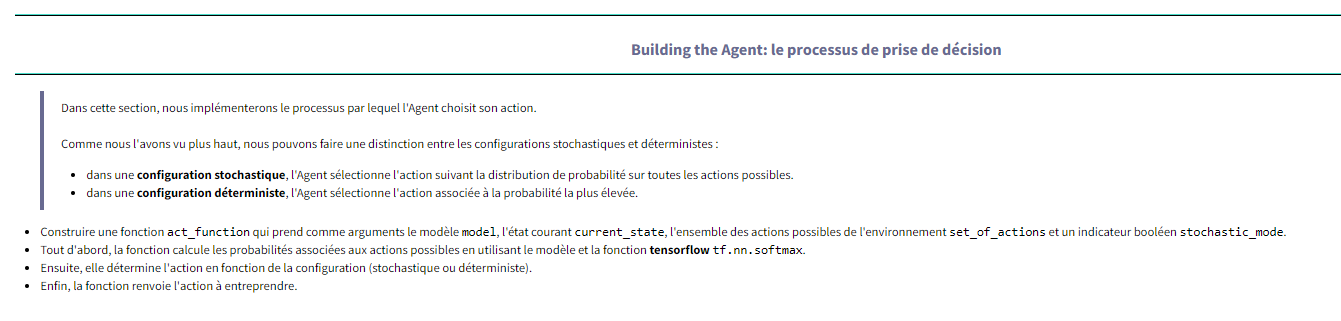

In [ ]:
def act_function(model, current_state, set_of_actions, stochastic_mode):

    # calcul des probabilités
    probabilities = model(current_state)
    probabilities = tf.nn.softmax(probabilities).numpy()[0]
    
    # pour une configuration stochastique
    if stochastic_mode:
        action = np.random.choice(set_of_actions, p=probabilities)
    
    # pour une configuration déterministe
    else:  
        action = set_of_actions[int(np.argmax(probabilities))]
    
    return action

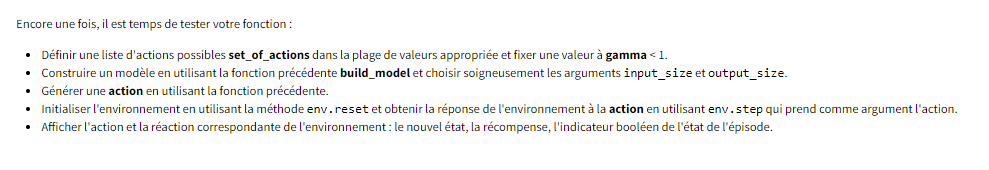

In [ ]:
import gym 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

set_of_actions = [-1,-0.5,0,0.5,1]
gamma = 0.95
episode_length = 1

# Construction du modèle
n_observation = env.observation_space.shape[0] # number of variables in the obervation space 
n_action = len(set_of_actions) # number of action
model, train = build_model(n_observation, n_action, (10,10),0.01)

# Initialisation de l'environnement 
current_state = env.reset()
current_state = current_state.reshape(1, n_observation)

# Génération d'une action aléatoire
action = act_function(model, current_state, set_of_actions, True)

# Obtention de la réponse de l'environnement
next_state, reward, done, info = env.step([action])

print("action: %.3f"%(action)) # action
print("observation: [%.3f,%.3f]"%(next_state[0],next_state[1]))
print("reward: %.3f"%(reward)) # récompense
print("done:", done) # statut du jeu


In [ ]:
"""
action: 1.000
observation: [-0.430,0.001]
reward: -0.100
done: False
"""

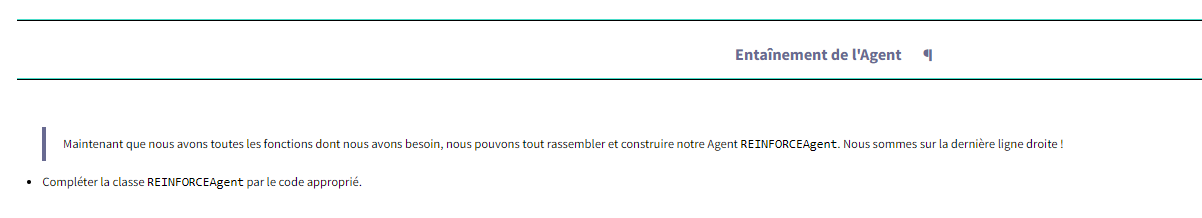

In [ ]:
class REINFORCEAgent:
    def __init__(self, state_size, action_range, hidden_units = (64,64), learning_rate = 0.01, 
                 stochastic_mode = True, gamma=0.95, action_step=200):
        self.state_size = state_size # size of observations
        
        # Discrétisation de l'espace des actions
        self.action_size = action_step # nombre d'actions possibles
        self.set_of_actions = np.linspace(action_range[0],action_range[1],self.action_size)

        # Paramètres
        self.gamma = gamma    # facteur d'actualisation
        self.learning_rate = learning_rate  # taux d'exploration
        self.stochastic_mode = stochastic_mode
        
        # Modèle d'apprentissage
        self.model, self.opt = build_model(self.state_size, self.action_size, 
                                 hidden_units, self.learning_rate)

        # Variables internes
        self.current_state = None
        self.episode_number, self.episode_length = 0, 0
        self.actions, self.states, self.rewards, self.scores = [],[],[],[] 

    def act(self):  
        # action à prendre
        action = act_function(self.model, self.current_state, self.set_of_actions, self.stochastic_mode)
        
        # conservation de l'action
        self.actions.append(action)
        return [action]

    def observe(self, obs, reward, done):
        self.states.append(self.current_state)
        self.episode_length += 1
        self.rewards.append(reward)
        self.current_state = obs.reshape(1, -1)
        return

    def reset(self, initial_obs):
        self.current_state = initial_obs.reshape(1, -1)
        self.episode_number += 1
        
        if self.episode_number > 1:
            self.scores.append(sum(self.rewards))
            
            self.model = policy_update_function(self.model, self.opt, self.states, self.actions, 
                                                self.rewards, self.episode_length, self.set_of_actions,
                                                self.gamma)
            
            self.states, self.actions, self.rewards = [], [], []
            self.episode_length = 0
            return

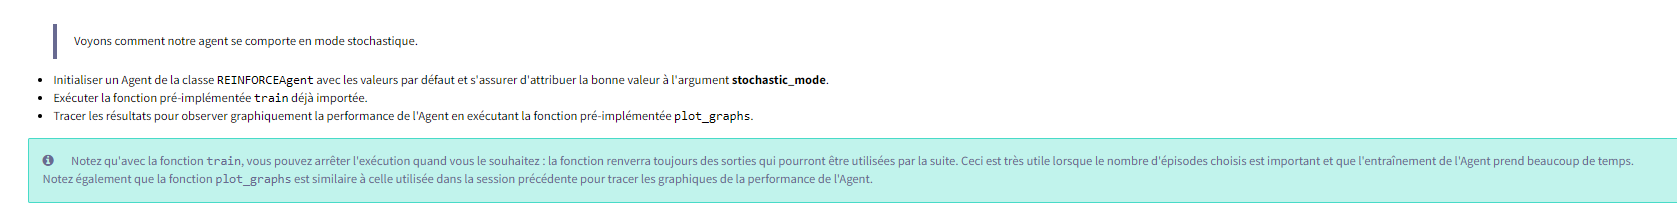

In [ ]:
import gym
import numpy as np
from utils import train, plot_graphs

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = REINFORCEAgent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                       hidden_units = (64,64), learning_rate = 0.01, gamma=0.95, stochastic_mode = True)

# Entraînement de l'Agent
scores_0, max_scores_0, max_heights_0, moving_average_0, delta_t_0=train(agent,env,n_episodes=500,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_0, max_scores_0, max_heights_0, moving_average_0)

In [ ]:
"""
Time elapsed :115.88s
<Figure size 1600x800 with 1 Axes>
<Figure size 1600x800 with 1 Axes>
"""

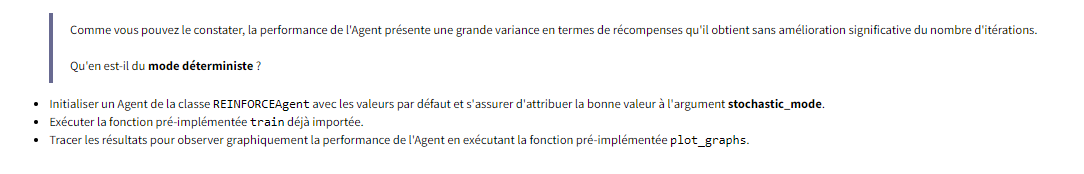

In [ ]:
import gym
import numpy as np
from utils import train, plot_graphs

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = REINFORCEAgent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                       hidden_units = (64,64), learning_rate = 0.01, gamma=0.95, stochastic_mode = False)

# Entraînement de l'Agent
scores_1, max_scores_1, max_heights_1, moving_average_1, delta_t_1=train(agent,env,n_episodes=500,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_1, max_scores_1, max_heights_1, moving_average_1)

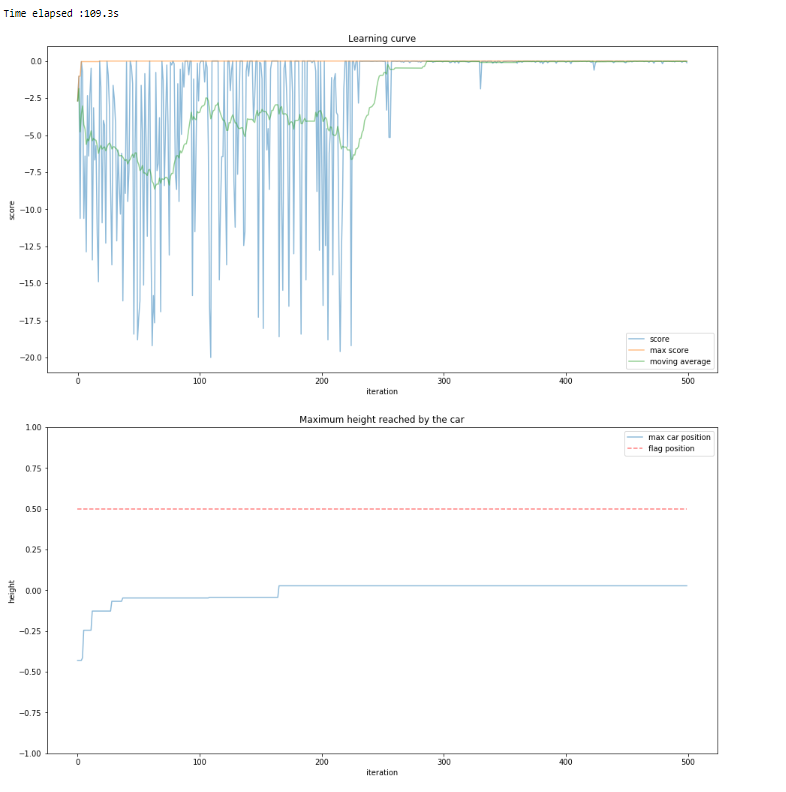

Le mode déterministe semble plus adapté. Comparons les résultats des deux agents.

Passez la cellule ci-dessous.

In [ ]:
print("Temps d'entraînement avec le mode stochatistique :%.3f"%(delta_t_0))
print("Temps d'entraînement avec le mode déterministe :%.3f"%(delta_t_1))

plot_graphs([scores_0, scores_1], [max_scores_0, max_scores_1], 
            [max_heights_0, max_heights_1], [moving_average_0, moving_average_1],
            n_agents = 2, names = ["mode stochatistique","mode déterministe"])

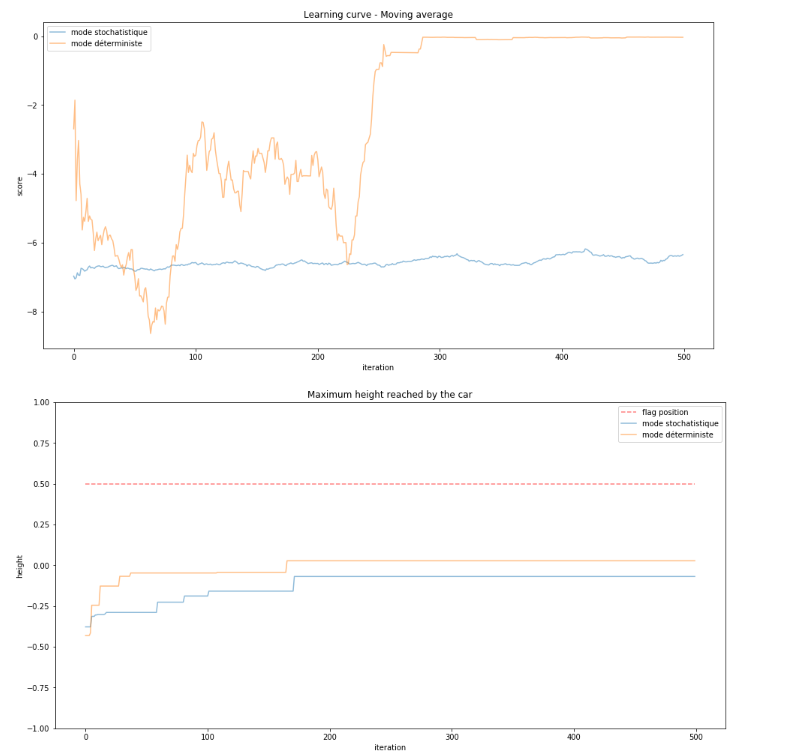

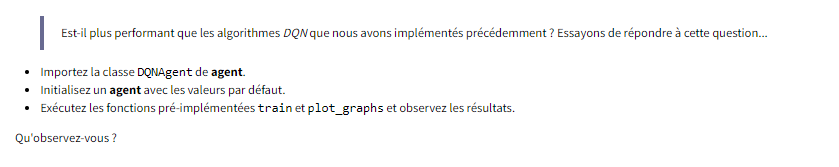

In [ ]:
import gym
from utils import train, plot_graphs
from agents import DQNAgent

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = DQNAgent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                  learning_rate = 0.01, gamma=0.95, epsilon = 1, epsilon_min = 0.01, 
                  epsilon_decay = 0.995, hidden_unit= (64,64), batch_size = 100, memory_size=200)

# Entraînement de l'Agent
scores_2, max_scores_2, max_heights_2, moving_average_2, delta_t_2=train(agent,env,n_episodes=500,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_2, max_scores_2, max_heights_2, moving_average_2)

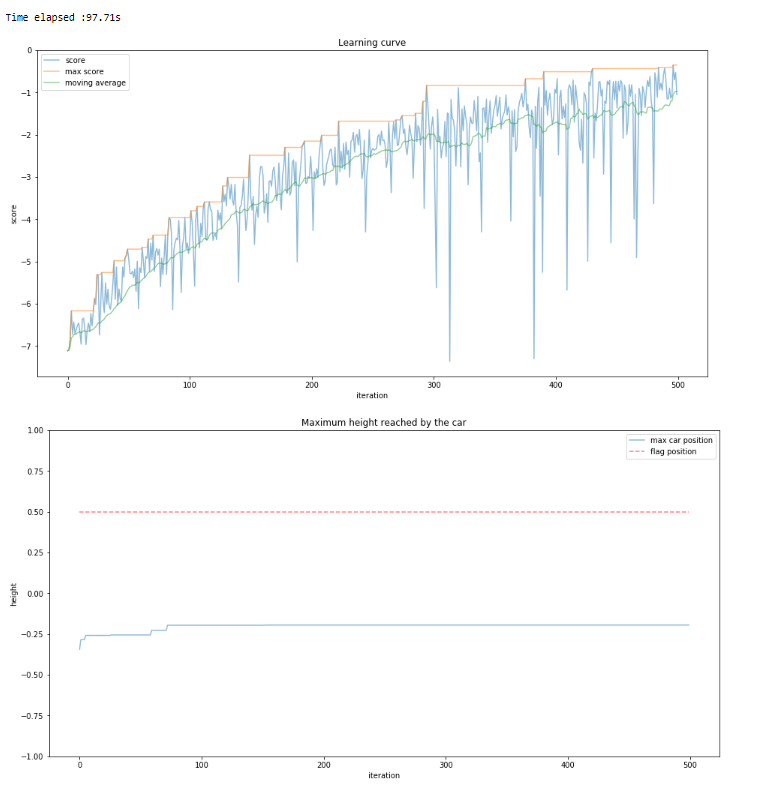

Compare the performance of the three agents by running the cell below.
What do you observe ?

In [ ]:
# Comparaison des durées de simulation
print("Temps d'entraînement pour REINFORCE - stochastique :%.3f"%(delta_t_0))
print("Temps d'entraînement pour REINFORCE - déterministe :%.3f"%(delta_t_1))
print("Temps d'entraînement pour DQN:%.3f"%(delta_t_2))

# Comparaison des performances des agents
plot_graphs([scores_0, scores_1, scores_2], 
            [max_scores_0, max_scores_1, max_scores_2], 
            [max_heights_0, max_heights_1, max_heights_2], 
            [moving_average_0, moving_average_1, moving_average_2],
            n_agents = 3, 
            names = ["REINFORCE - stochastique","REINFORCE - déterministe", "DQN"])

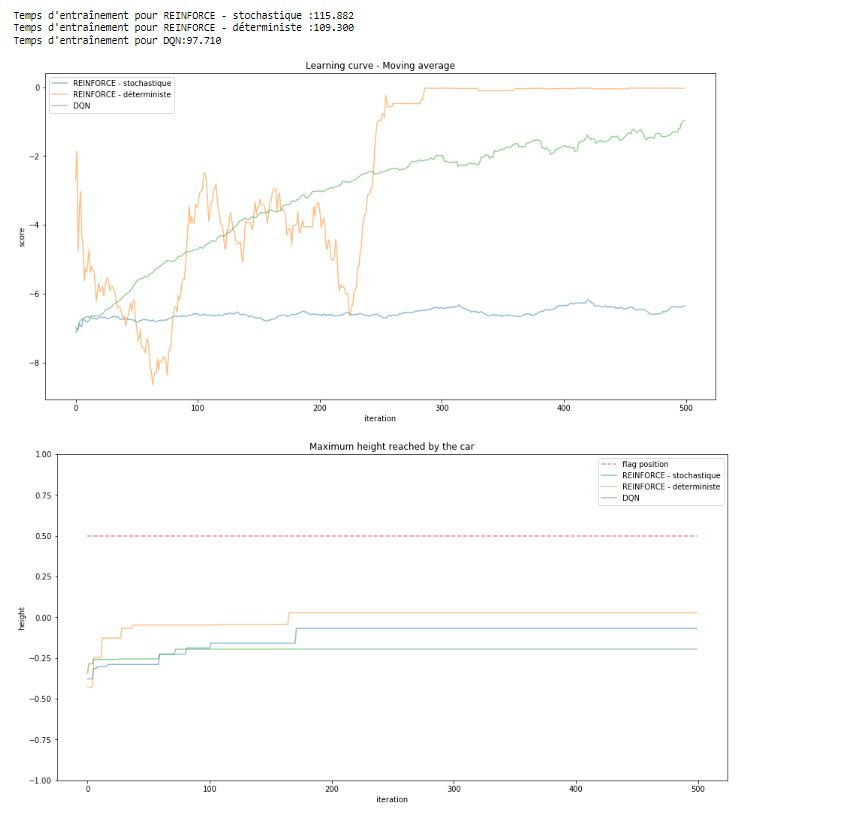

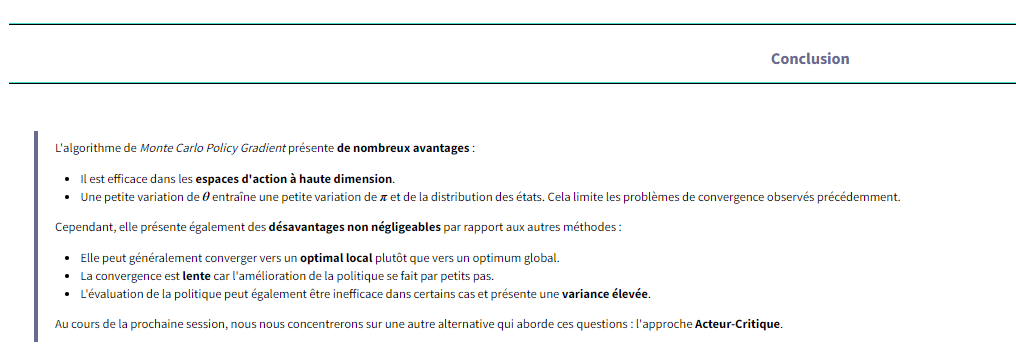

# E - Policy Gradient - Partie 2

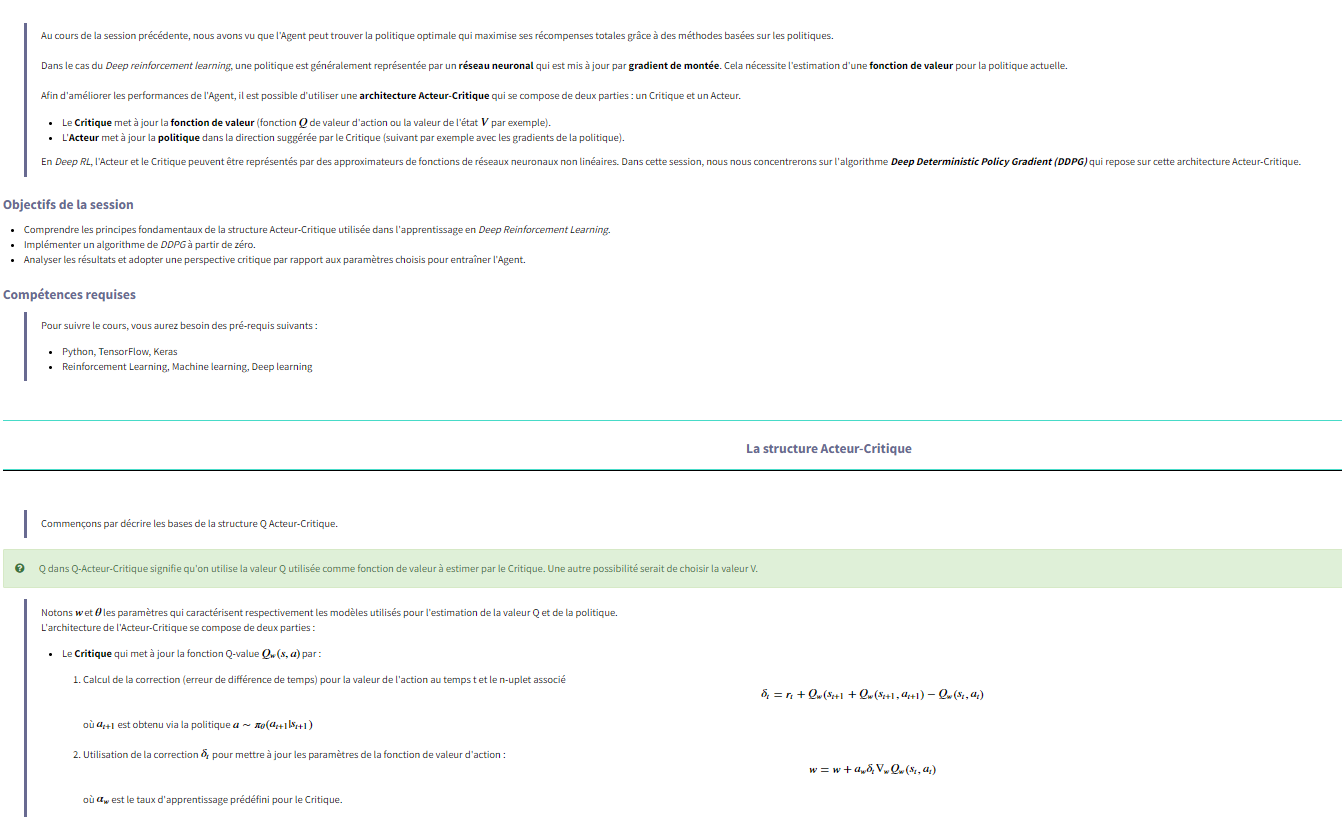

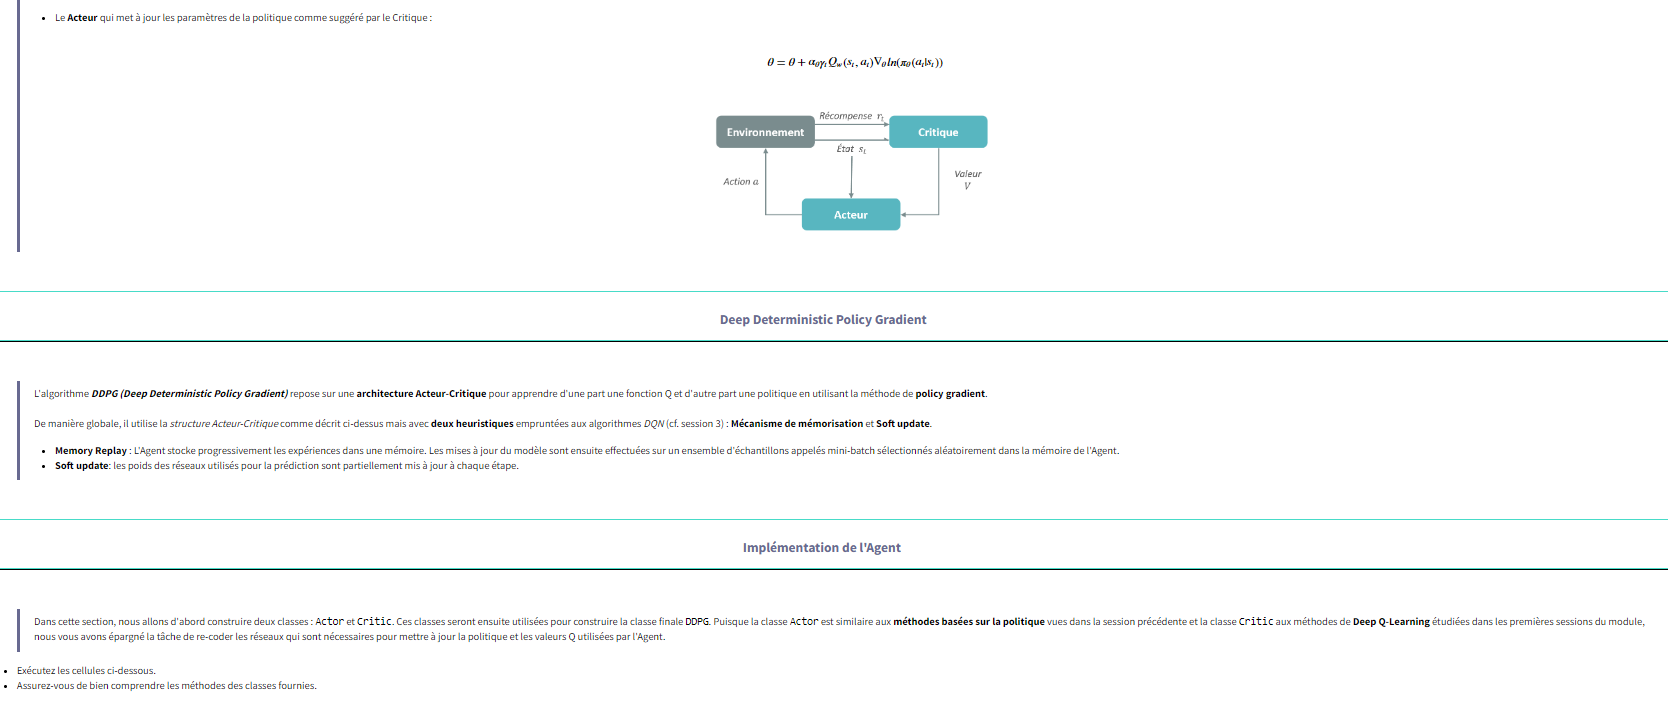

In [ ]:
import tensorflow as tf
from keras.layers import merge
from keras.models import Sequential, Model
from tensorflow.keras import Input, Model, layers, optimizers
tf.keras.backend.set_floatx('float64')

def build_model_actor(input_size, output_size, hidden_unit):
        # Création des inputs et couches
        input_layer = Input(shape=[input_size])
        layer = layers.Dense(hidden_unit[0], activation='relu')(input_layer)
        layer = layers.Dense(hidden_unit[1], activation='tanh')(layer)
        output_layer = layers.Dense(output_size, activation='tanh')(layer)
        # Définition du modèle
        model = Model(inputs=input_layer, outputs=output_layer)
        return model

class Actor:
    def __init__(self, state_size, action_size,
                 learning_rate, batch_size, tau, hidden_unit):
        
        self.state_size = state_size # taille des observations

        # Paramètres de l'environnement
        self.action_size = action_size # nombre d'actions possibles actions
        self.state_size=state_size # nombre d'observations
        
        # Paramètres 
        self.learning_rate = learning_rate  # taux d'apprentissage
        self.batch_size = batch_size # mémoire
        self.tau = tau  # taux de mise à jour de la target
        self.hidden_unit = hidden_unit # mdoèle
        
        # Création du modèle principal et du modèle cible
        self.model = build_model_actor(self.state_size, self.action_size, self.hidden_unit)

        # Définition de la fonction d'optimisation
        self.opt = optimizers.Adam(self.learning_rate)
    
    def train(self, states, action_gradients):
        # Calcul de graident
        with tf.GradientTape() as tape:
            actions = self.model(states)
            theta = self.model.trainable_variables
        grads = tape.gradient(actions, theta,  output_gradients = - action_gradients)
        # Mise à jour du modèle
        self.opt.apply_gradients(zip(grads, self.model.trainable_weights))
        

executer

In [ ]:
def build_model_critic(state_size, action_size, hidden_unit,learning_rate): 
        # Création des inputs
        state_input_layer = Input(shape=[state_size])
        action_input_layer = Input(shape=[action_size])
        # Création des couches
        s_layer = layers.Dense(hidden_unit[0], activation='relu')(state_input_layer)
        a_layer = layers.Dense(hidden_unit[0], activation='tanh')(action_input_layer)
        hidden = layers.Dense(hidden_unit[1], activation='linear')(s_layer)
        hidden = layers.add([hidden, a_layer])
        hidden = layers.Dense(hidden_unit[1], activation='relu')(hidden)
        output_layer = layers.Dense(1, activation='tanh')(hidden)
        # Définition du modèle
        model = Model(inputs=[state_input_layer, action_input_layer],
                       outputs=output_layer)
        return model

class Critic:
    def __init__(self, state_size, action_size,
                 learning_rate, batch_size, tau, hidden_unit):
        
        # Paramètres de l'environnement
        self.action_size = action_size # nombre d'actions possibles actions
        self.state_size=state_size # nombre d'observations
        
        # Parameters
        self.learning_rate = learning_rate  # learning rate
        self.batch_size = batch_size # memory
        self.tau = tau # target update
        self.hidden_unit = hidden_unit # model

        # Création du modèle principal et du modèle cible
        self.model = build_model_critic(self.state_size, self.action_size, 
                                        self.hidden_unit,self.learning_rate)
        self.target_model = build_model_critic(self.state_size, self.action_size, 
                               self.hidden_unit,self.learning_rate)
        
        # Définition de la fonction d'optimisation
        self.opt=optimizers.Adam(lr=learning_rate)

    def get_gradients(self, states, actions):
        # Renvoie le gradient par rapport aux actions
        with tf.GradientTape() as tape:
            tape.watch(actions)
            output = self.model([states, actions])
        action_gradients = tape.gradient(output, actions)
        return action_gradients

    def train(self, states, actions, q_targets):
        # Calcul du gradient
        with tf.GradientTape() as tape:
            output = self.model ([states,actions])
            loss = tf.keras.losses.MSE(output,q_targets)
        grads = tape.gradient(loss, self.model.trainable_weights)
        # Mise à jour du gradient
        self.opt.apply_gradients(zip(grads, self.model.trainable_weights))

    def train_target_model(self):
        self.target_model = train_target_model(self.model,self.target_model,self.tau)

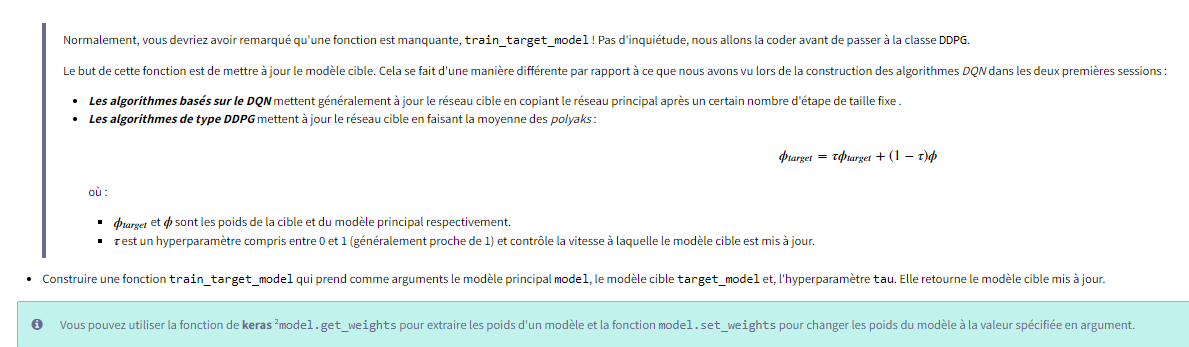

In [ ]:
def train_target_model(model,target_model,tau):
    
    # Poids du modèle principal
    main_weights = model.get_weights()
    # poids du modèle cible
    target_weights = target_model.get_weights()
    
    # Calcul des nouveaux poids du modèle cible
    target_weights = [tau * main_weight + (1 - tau) * target_weight 
                      for main_weight, target_weight in
                      zip(main_weights, target_weights)]
    
    # Mise à jour des poids des modèles cibles
    target_model.set_weights(target_weights)
    
    # Renvoi du modèle cible
    return target_model

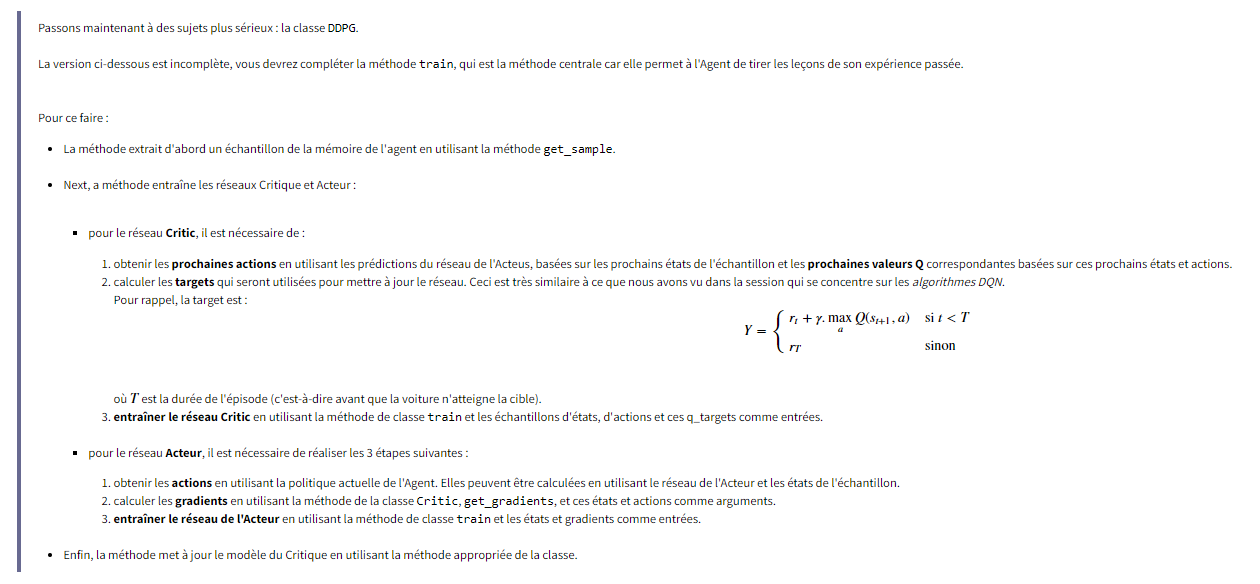

In [ ]:
from collections import deque
import random

class DDPG:
    def __init__(self, state_size, action_size, actor_hidden_unit=(300, 300),
                 actor_learning_rate=0.0001, critic_hidden_unit=(300, 300),
                 critic_learning_rate=0.001, batch_size=64, gamma=0.95,
                 memory_size=10000, tau=0.001, action_step = 1):

        # Paramètres de l'environnement
        self.action_size = action_size # nombre d'actions possibles
        self.state_size = state_size # nombre d'observation
        
        # Paramètres
        self.gamma = gamma # discount rate
        self.batch_size = batch_size # batch size
        self.memory_size = memory_size # memory

        # Defintion de l'Acteur et du Critique
        self.actor = Actor(state_size=state_size, action_size=self.action_size,
                            hidden_unit=actor_hidden_unit,
                            learning_rate=actor_learning_rate,
                            batch_size=batch_size, tau=tau)

        self.critic = Critic(state_size=state_size, action_size=self.action_size,
                              hidden_unit=critic_hidden_unit,
                              learning_rate=critic_learning_rate,
                              batch_size=batch_size, tau=tau)
        
        # Variables internes
        self.current_state = None
        self.current_action = None
        self.memory = deque(maxlen=memory_size)

        return

    def act(self):
        self.current_action = self.actor.model.predict(self.current_state)[0][0]
        return [self.current_action]

    def train(self):
        if len(self.memory) > self.batch_size:
            
           # Obtenir un échantillon aléatoire de la mémoire de l'Agent
            states, actions, rewards, done, next_states = self.get_sample()
            
            # Entraîner le Critique
            
            # 1. obtenir les prochaines actions en fonction des prévisions de l'Acteur
            next_states = np.asarray(next_states).reshape(-1,self.state_size)
            next_actions = self.actor.model(next_states)
            
            next_q_values = self.critic.target_model([next_states,next_actions])
            
            # 2. entraîner le réseau du Critique
            q_targets=[]
            for reward, next_q_value, this_done in zip(rewards, next_q_values, done):
                if this_done:
                    q_target = rewards
                else: 
                    q_target = reward + self.gamma * (next_q_value)
                q_targets.append(q_target)
            actions = np.asarray(actions).reshape(-1,1)
            q_targets = np.asarray(q_targets).reshape(-1,1)
            
            # 3. mettre à jour le réseau du Critique
            self.critic.train(states, actions, q_targets)

            # Entraîner l'Acteur
            # 1. obtenir les actions basées sur les prédictions de l'Acteur
            action_for_gradients = self.actor.model(states)
            # 2. calculer les gradients à l'aide du réseau Critic
            gradients = self.critic.get_gradients(states, action_for_gradients)
            # 3. mettre à jour le réseau de l'Acteur
            self.actor.train(states, gradients)
            
            # Mettre à jour les modèles cibles pour suivre lentement les modèles principaux
            self.critic.train_target_model()

    def get_sample(self):
        
        # échantillon aléatoire de la mémoire
        sample = random.sample(self.memory, self.batch_size)
        states, actions, rewards, done, next_states = map(list, zip(*sample))
        
        # transformation des listes en tableaux
        states=np.asarray(states).reshape(-1,self.state_size)
        actions=np.asarray(actions).reshape(-1,1)
        rewards=np.asarray(rewards).reshape(-1,1)
        next_states=np.asarray(next_states).reshape(-1,self.state_size)
        
        return states, actions, rewards, done, next_states 

    def observe(self, obs, reward, done):
        # sauvegarde de l'expérience dans la mémoire
        obs = np.reshape(obs,(1,self.state_size))
        self.memory.append((self.current_state, self.current_action, reward, done, obs))
        self.current_state = obs
        # libération d'espace pour de nouvelles expériences
        if len(self.memory) > self.memory_size:
            self.memory.popleft() 
        # entraînement du modèle
        self.train()
        
    def reset(self,initial_state):
        # initialisation du premier état 
        self.current_state = initial_state.reshape(1, self.state_size)
        self.current_action = None
        return

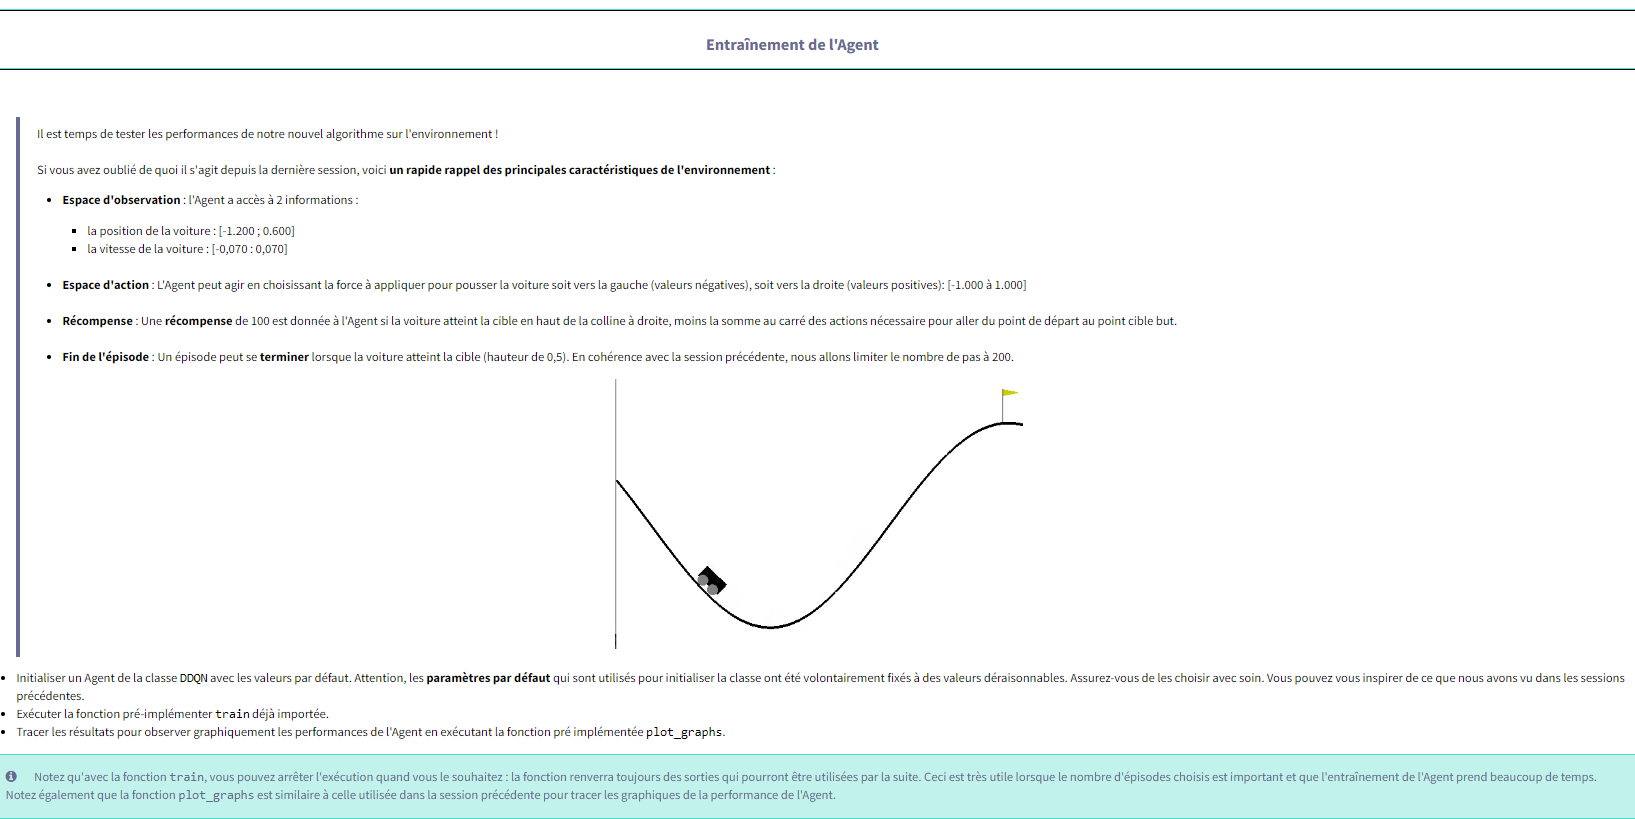

In [ ]:
import gym
import numpy as np
from utils import train, plot_graphs
import matplotlib.pyplot as plt

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = DDPG(state_size=env.observation_space.shape[0],action_size = 1 ,
             actor_hidden_unit=(10, 10), actor_learning_rate=0.01, 
             critic_hidden_unit=(10, 10), critic_learning_rate=0.01, 
             batch_size=100, gamma=0.95, memory_size=200, tau=0.01)


# Entraînement de l'Agent
scores_0, max_scores_0, max_heights_0, moving_average_0, delta_t_0=train(agent,env, n_episodes=400,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_0, max_scores_0, max_heights_0, moving_average_0)

In [ ]:
"""

"""

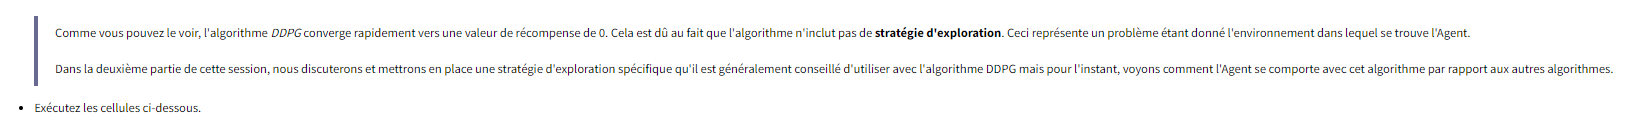

In [ ]:
import gym
from utils import train, plot_graphs
from agents import DQNAgent

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = DQNAgent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                  learning_rate = 0.01, gamma=0.95, epsilon = 1, epsilon_min = 0.01, 
                  epsilon_decay = 0.995, hidden_unit= (64,64), batch_size=100, memory_size=200)

# Entraînement de l'Agent
scores_1, max_scores_1, max_heights_1, moving_average_1, delta_t_1=train(agent,env,n_episodes=400,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_1, max_scores_1, max_heights_1, moving_average_1)

In [ ]:
import gym
import numpy as np
from utils import train, plot_graphs
from agents import REINFORCEAgent

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

# Initialisation de l'Agent
agent = REINFORCEAgent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                       hidden_units = (64,64), learning_rate = 0.01, gamma=0.95, stochastic_mode = False)

# Entraînement de l'Agent
scores_2, max_scores_2, max_heights_2, moving_average_2, delta_t_2=train(agent,env,n_episodes=400,
                            verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_2, max_scores_2, max_heights_2, moving_average_2)

In [ ]:
# Comparaison des durées de simulation
print("Temps d'entraînement pour DDPG :%.3f"%(delta_t_0))
print("Temps d'entraînement pour DQN :%.3f"%(delta_t_1))
print("Temps d'entraînement pour REINFORCE:%.3f"%(delta_t_2))

# Comparaison des performances des agents
plot_graphs([scores_0, scores_1, scores_2], 
            [max_scores_0, max_scores_1, max_scores_2], 
            [max_heights_0, max_heights_1, max_heights_2], 
            [moving_average_0, moving_average_1, moving_average_2],
            n_agents = 3, 
            names = ["DDPG","DQN","REINFORCE"])

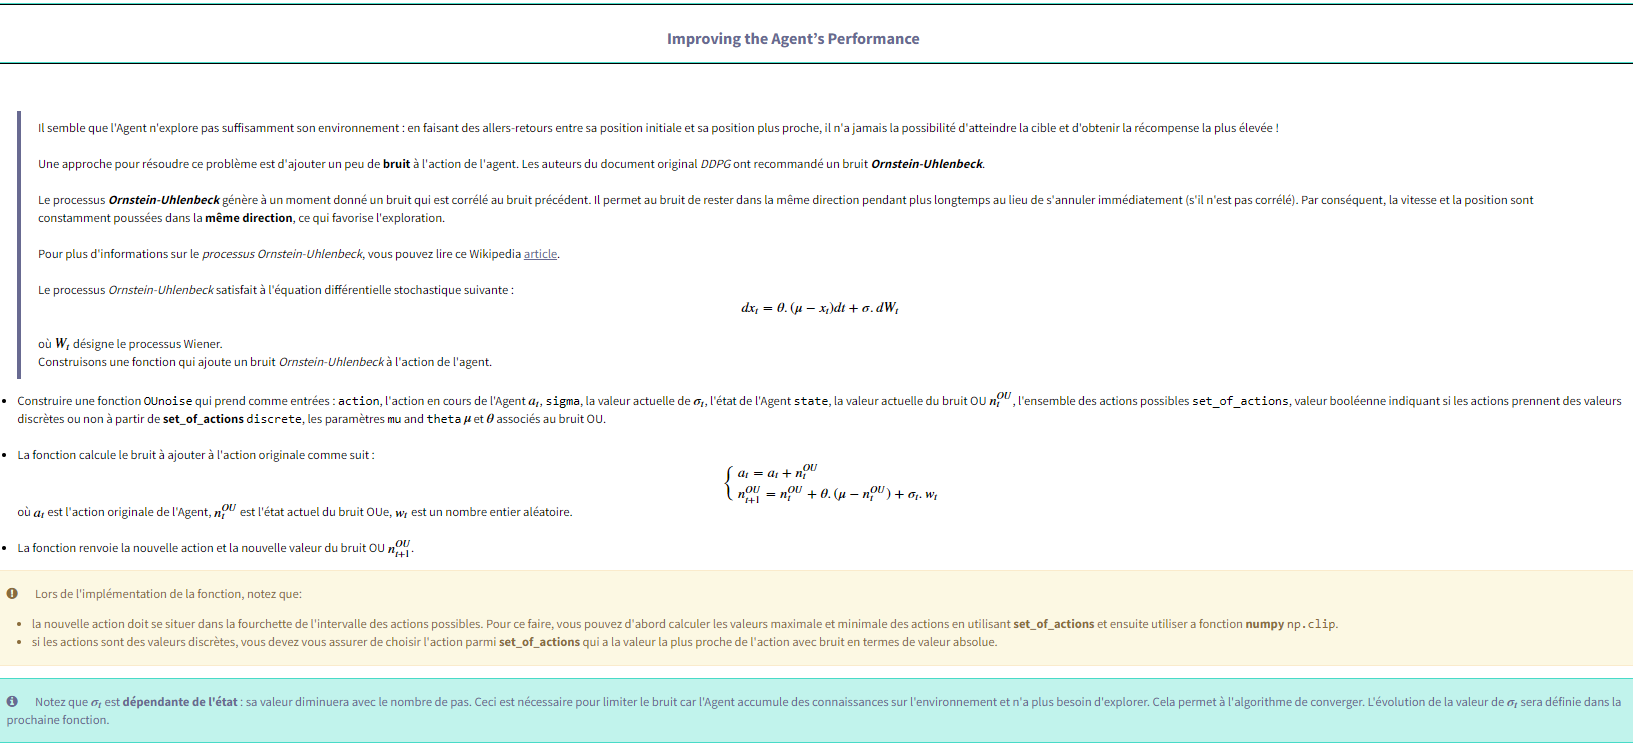

In [ ]:
def OUnoise(action, sigma, state, set_of_actions, discrete, mu, theta):
    
    # Valeur minimale et maximale possible des actions
    low, high = min(set_of_actions), max(set_of_actions)
    
    x = state # état actuel du bruit OU
    dx = theta * (mu - x) + sigma * np.random.randn(len(x)) # changement à ajouter au bruit OU
    OU_state = x + dx # nouvel état du bruit OU
    
    # si les actions sont des valeurs discrètes
    if discrete:
        d = [abs(np.clip(action + OU_state, low, high)[0] - a) for a in set_of_actions]
        action_OUnoise = set_of_actions[np.argmin(d)]
    
    # si les actions sont des valeurs continues
    else: 
        action_OUnoise = np.clip(action + OU_state, low, high)[0]

    return action_OUnoise, OU_state

Maintenant que nous avons implémenté la fonction qui va générer le bruit, il nous reste à l'intégrer au processus utilisé pour exécuter un épisode. Pour vous aider, nous avons copié dans la cellule ci-dessous la fonction initiale que nous avons implémentée lors de la première session.

In [ ]:
def run_episode(agent,env, parameters):
    
    # initialisation de l'environnement et de l'agent
    initial_state = env.reset()
    agent.reset(initial_state)

    score = 0 # score de l'épisode
    max_height = -1000 # hauteur maximale pendant l'épisode
  
    for i in range(200):
      
        # l'Agent choisit une action
        action = agent.act()
        # l'environnement réagit en conséquence 
        next_state, reward, done, _ = env.step(action=action) 
        # mise à jour de la hauteur maximale
        max_height = max(max_height, next_state[0])
        # l'Agent observe la réponse
        agent.observe(next_state, reward, done)
      
        score += reward # mise a jour du score
        states.append(next_state) # mise à jour de l'état
      
        # si l'agent atteint la cible, l'épisode se termine prématurément
        if done:
            break
      
    return agent, score, max_height

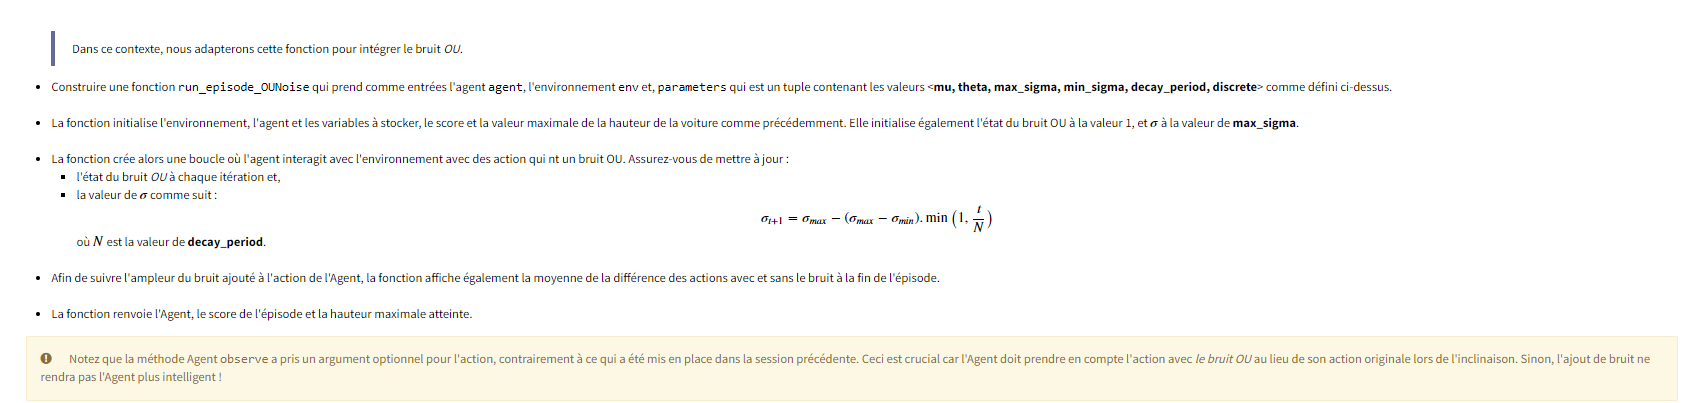

In [ ]:
def run_episode_OUNoise(agent,env, parameters = (0,0.15,0.1,0,100000,True)):
     
    # initialisation de l'environnement et de l'agent
    initial_state = env.reset()
    agent.reset(initial_state)
    
    score = 0 # score de l'épisode
    max_height = -1000 # hauteur maximale pendant l'épisode
    
    # initialisation des paramétreurs liés au bruit OU
    mu, theta, max_sigma, min_sigma, decay_period, discrete = parameters
    set_of_actions = agent.set_of_actions if discrete else [env.action_space.low[0], env.action_space.high[0]]
    sigma = max_sigma
    action_dim = env.action_space.shape[0]
    state = np.ones(action_dim) * mu
    
    # liste de la différence des actions de l'agent 
    # avant et après l'ajout de bruit
    difference = []

    for i in range(200):
        # l'Agent choisit une action
        action = agent.act()
        # Le bruit OU est ajouté à son action et le tableau d'état est mis à jour
        action_OUnoise, state = OUnoise(action[0], sigma, state, set_of_actions, 
                                        discrete, mu, theta)
        # l'environnement réagit en conséquence 
        next_state, reward, done, _ = env.step(action=[action_OUnoise]) 
        # la hauteur maximale est mise à jour
        max_height = max(max_height, next_state[0])
        # l'Agent observe la réponse
        agent.observe(next_state, reward, done, action_OUnoise)
        # la valeur de sigma est mise à jour
        sigma = max_sigma - (max_sigma - min_sigma) * min(1.0, i / decay_period)
        # le score est mis à jour
        score += reward 
        # si l'Agent atteint la cible, l'épisode se termine prématurément
        if done:
            break
        # la différence est stockée dans la liste
        difference.append(action[0]-action_OUnoise)
    # pour suivre l'évolution de la situation
    print(np.mean(difference)) 
    
    return agent, score, max_height

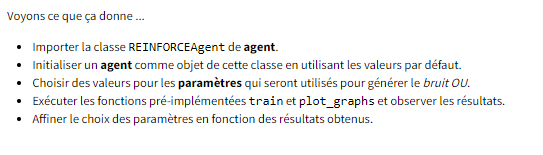

In [ ]:
import gym
import numpy as np
from utils import train, plot_graphs
from agents import REINFORCEAgent

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

parameters = (0,0.2,0.4,0.3,100000, True)
# mu, theta, max_sigma, min_sigma, decay_period, discrete

# Initialisation de l'Agent
agent = REINFORCEAgent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                       hidden_units = (64,64), learning_rate = 0.01, gamma=0.95)

# Entraînement de l'Agent
scores_3, max_scores_3, max_heights_3, moving_average_3, delta_t_3=train(agent,env, run_episode_OUNoise, parameters = parameters,
                            n_episodes=400, verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_3, max_scores_3, max_heights_3, moving_average_3)

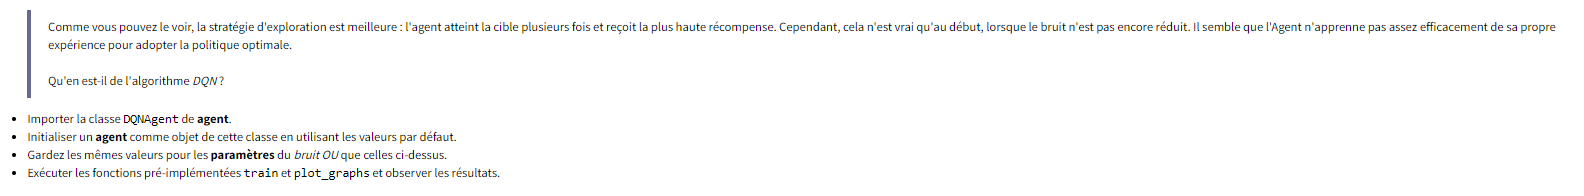

In [ ]:
import gym
import numpy as np
from utils import train, plot_graphs
from agents import DQNAgent

# Initialisation de l'environnement 
env = gym.make('MountainCarContinuous-v0')
env.seed(2)

parameters = (0,0.2,0.4,0.3,100000,True)
# mu, theta, max_sigma, min_sigma, decay_period, discrete

# Initialisation de l'Agent
agent = DQNAgent(state_size = env.observation_space.shape[0], action_range=(env.action_space.low[0],env.action_space.high[0]),
                  learning_rate = 0.01, gamma=0.95, epsilon = 1, epsilon_min = 0.01, 
                  epsilon_decay = 0.995, hidden_unit= (64,64), batch_size= 100, memory_size=200)

# Entraînement de l'Agent
scores_4, max_scores_4, max_heights_4, moving_average_4, delta_t_4=train(agent,env, run_episode_OUNoise, parameters = parameters,
                            n_episodes=400, verbose=True,erase=True)

# Affichage des graphes
plot_graphs(scores_4, max_scores_4, max_heights_4, moving_average_4)

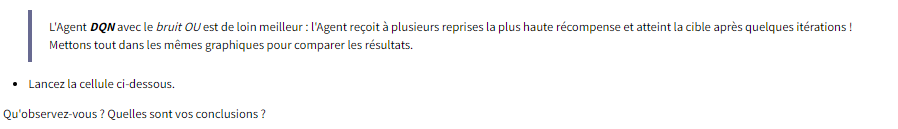

In [ ]:
# Comparaison des durées de simulation
print("Temps d'entraînement avec DQN :%.3f"%(delta_t_4))
print("Temps d'entraînement avec REINFORCE:%.3f"%(delta_t_3))

# Comparaison des performances des agents
plot_graphs([scores_3, scores_4], 
            [max_scores_3, max_scores_4], 
            [max_heights_3, max_heights_4], 
            [moving_average_3, moving_average_4],
            n_agents = 2, 
            names = ["REINFORCE","DQN"])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(scores_3, alpha=.5, label='REINFORCE')
plt.plot(scores_4, alpha=.5, label='DQN')
plt.ylabel("score")
plt.xlabel("iteration")
plt.title("Learning curve")
plt.legend()
plt.show()

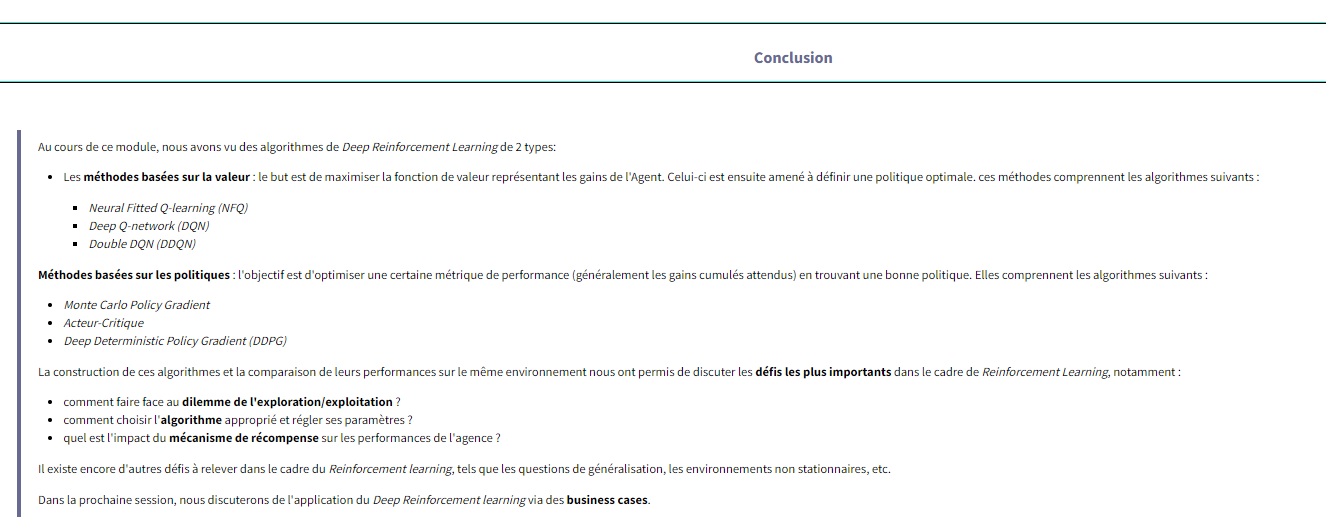

# F - Application à des Business Cases

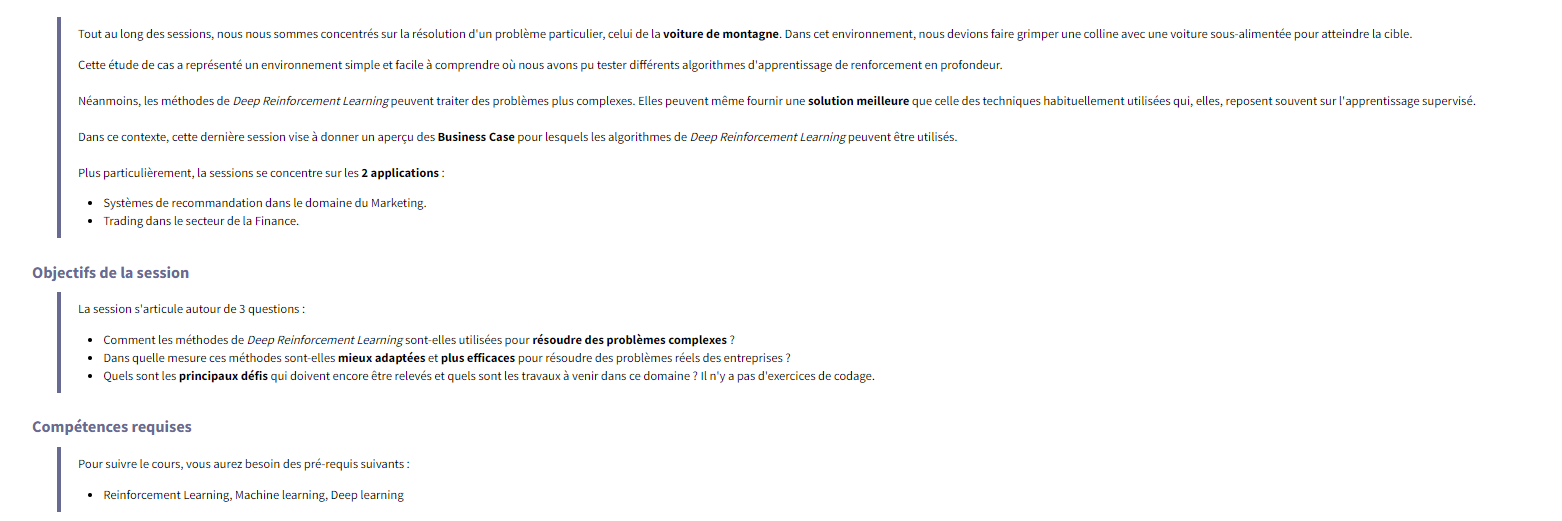

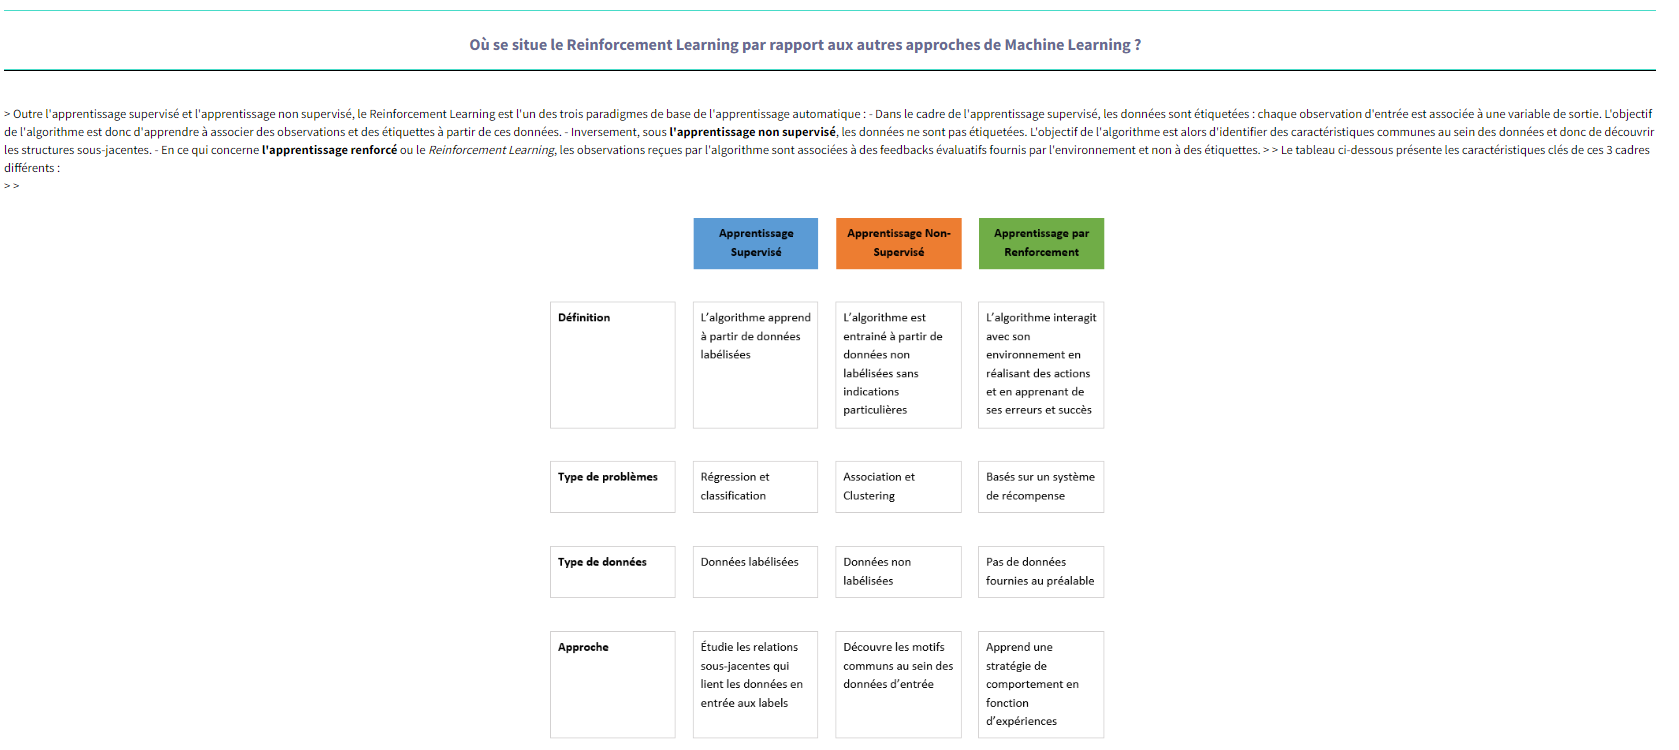

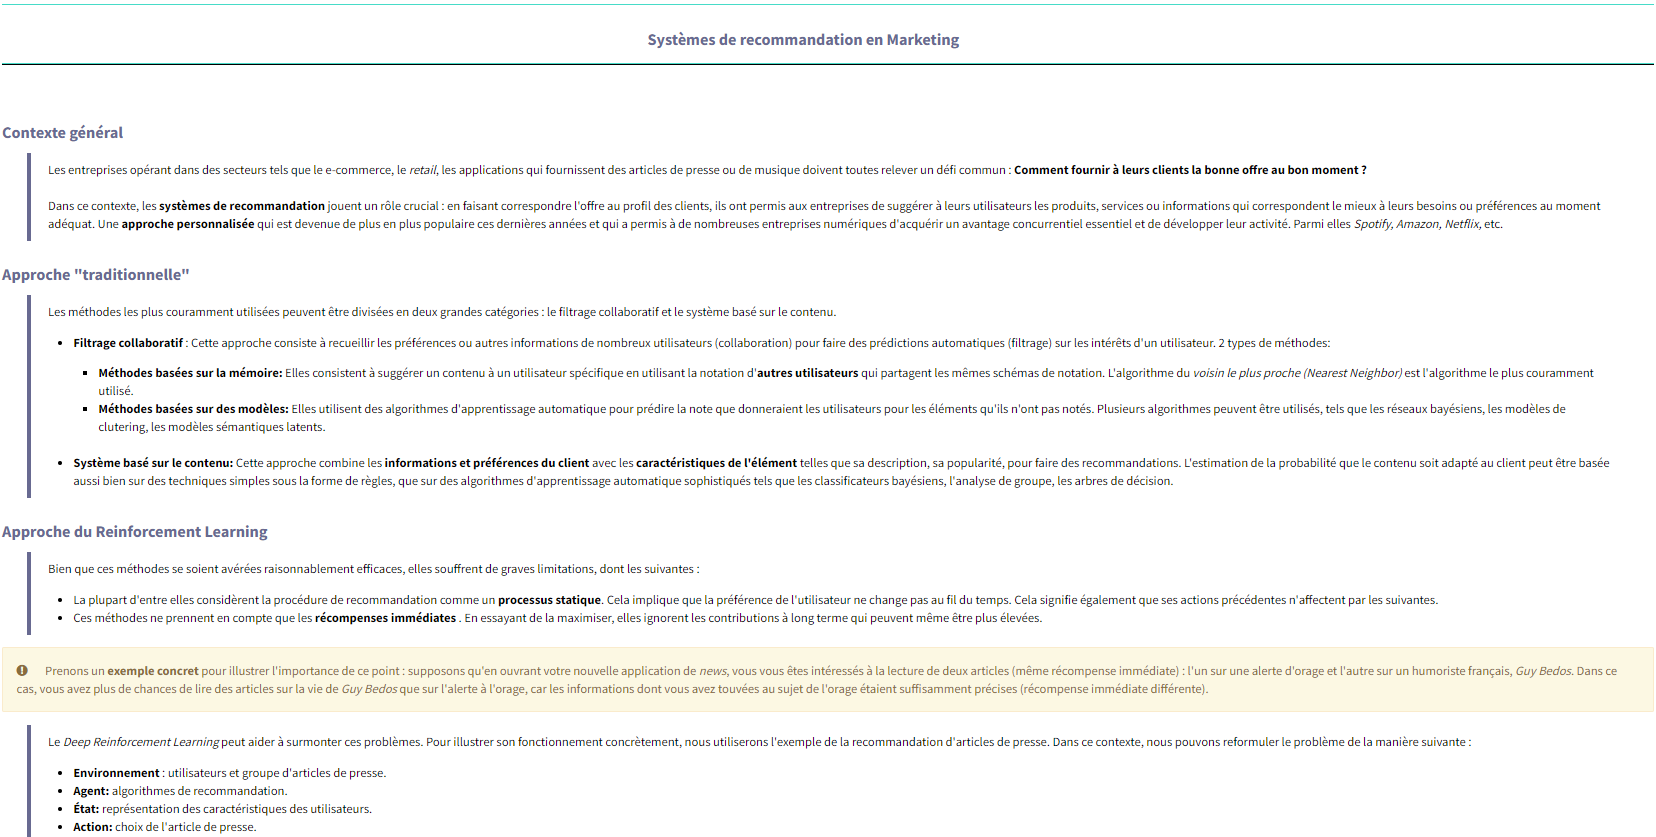

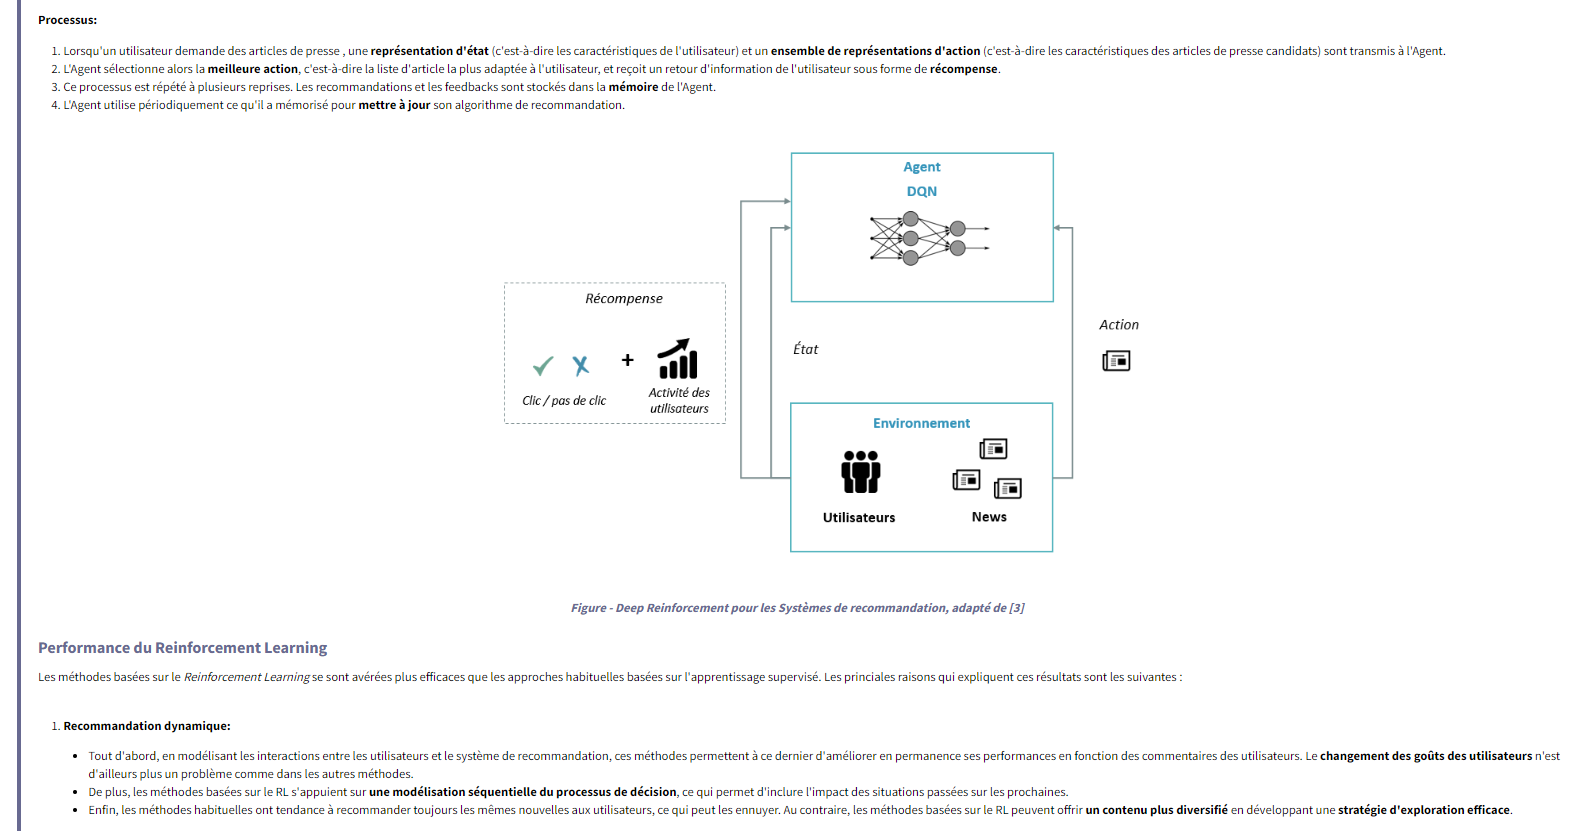

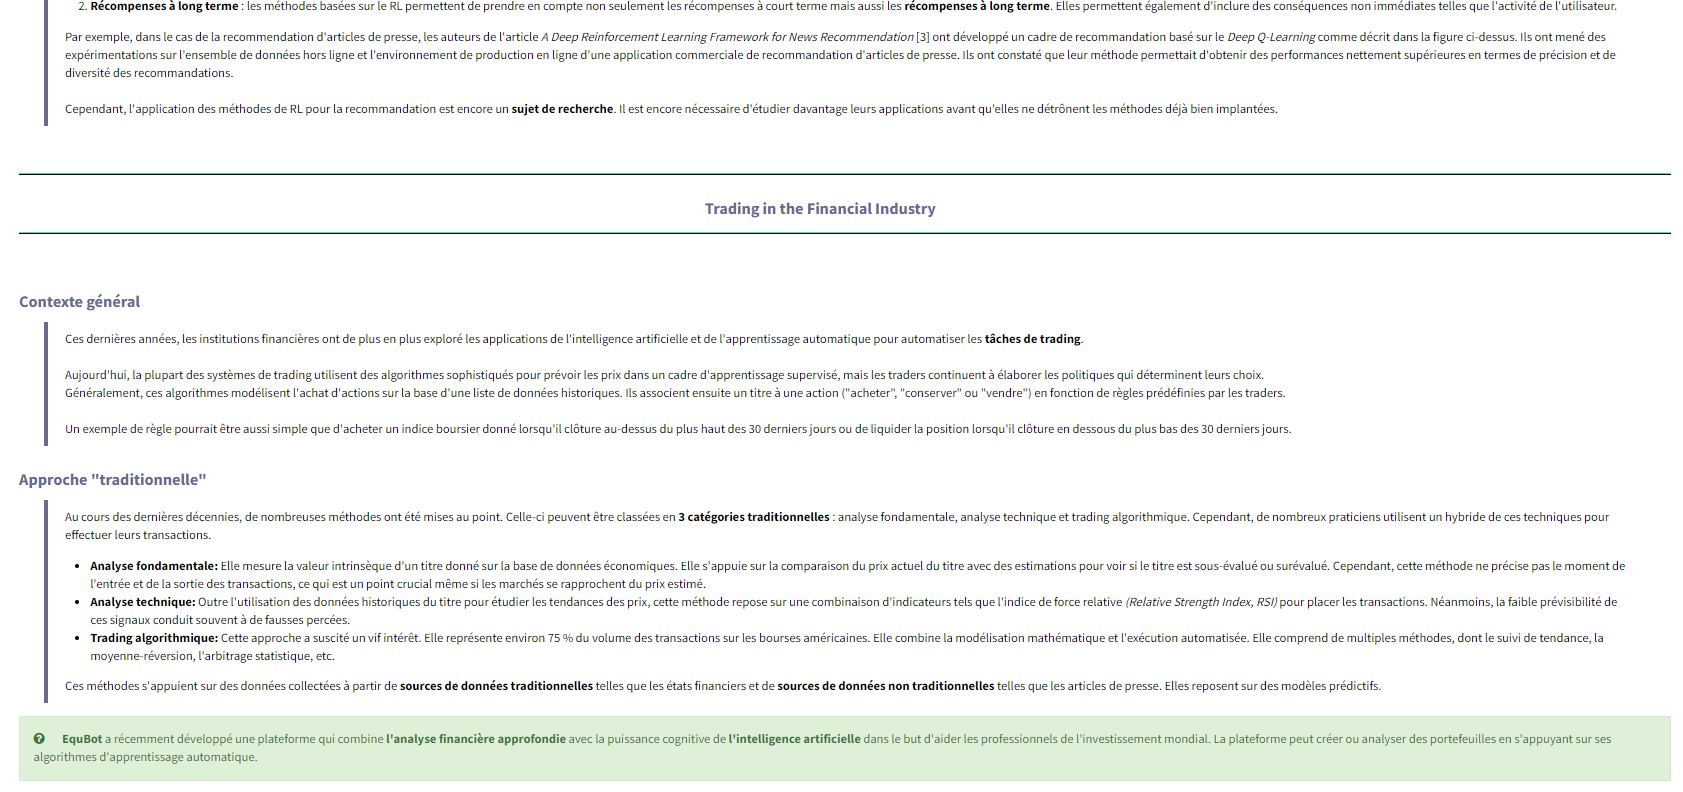

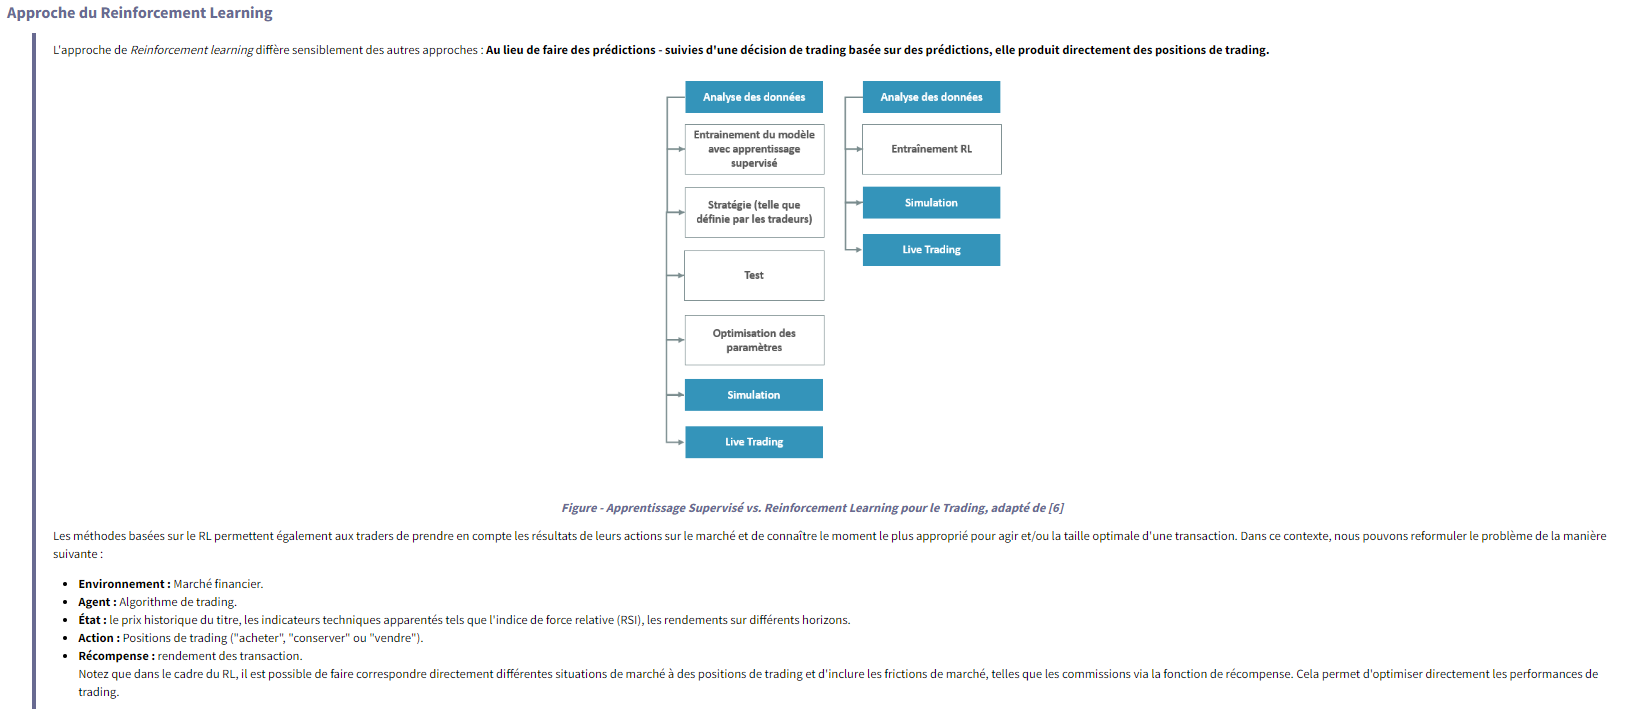

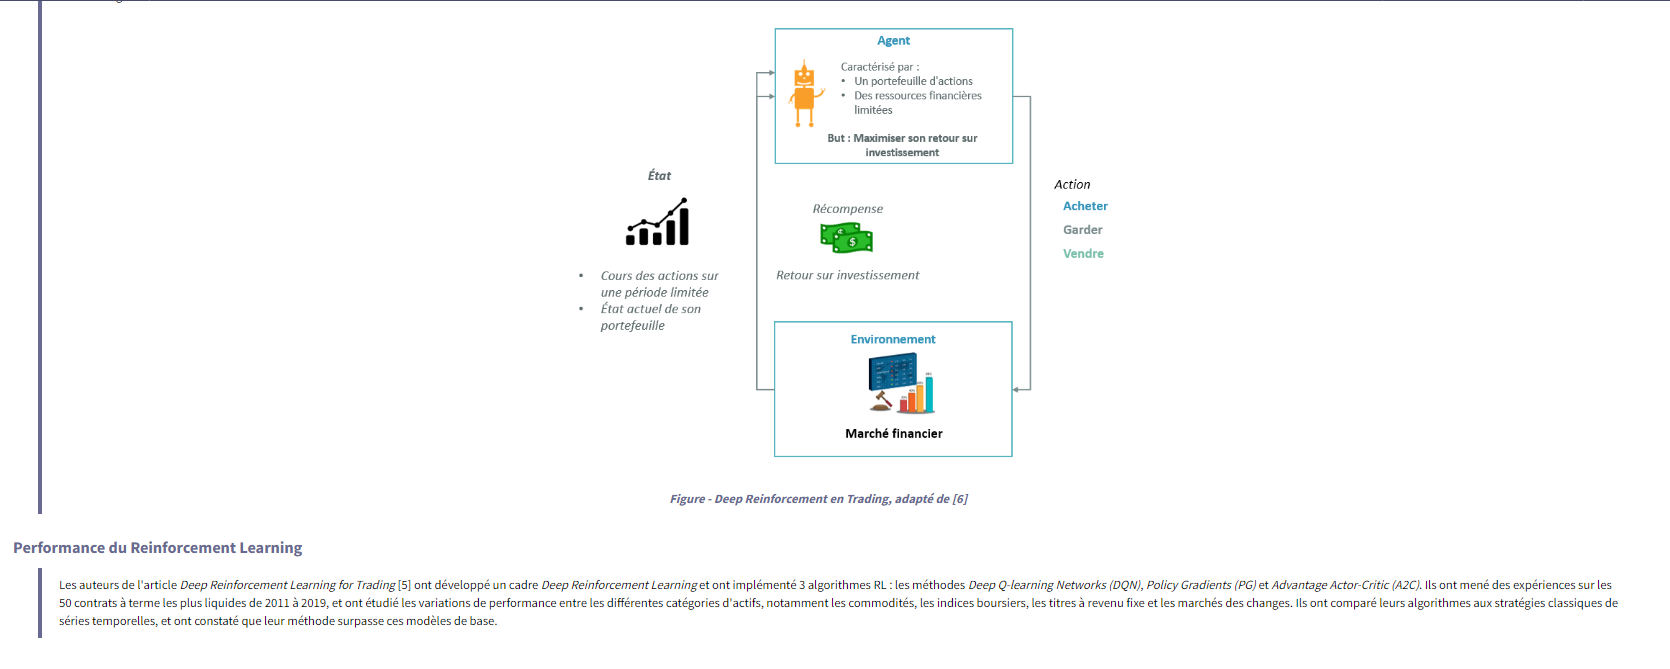

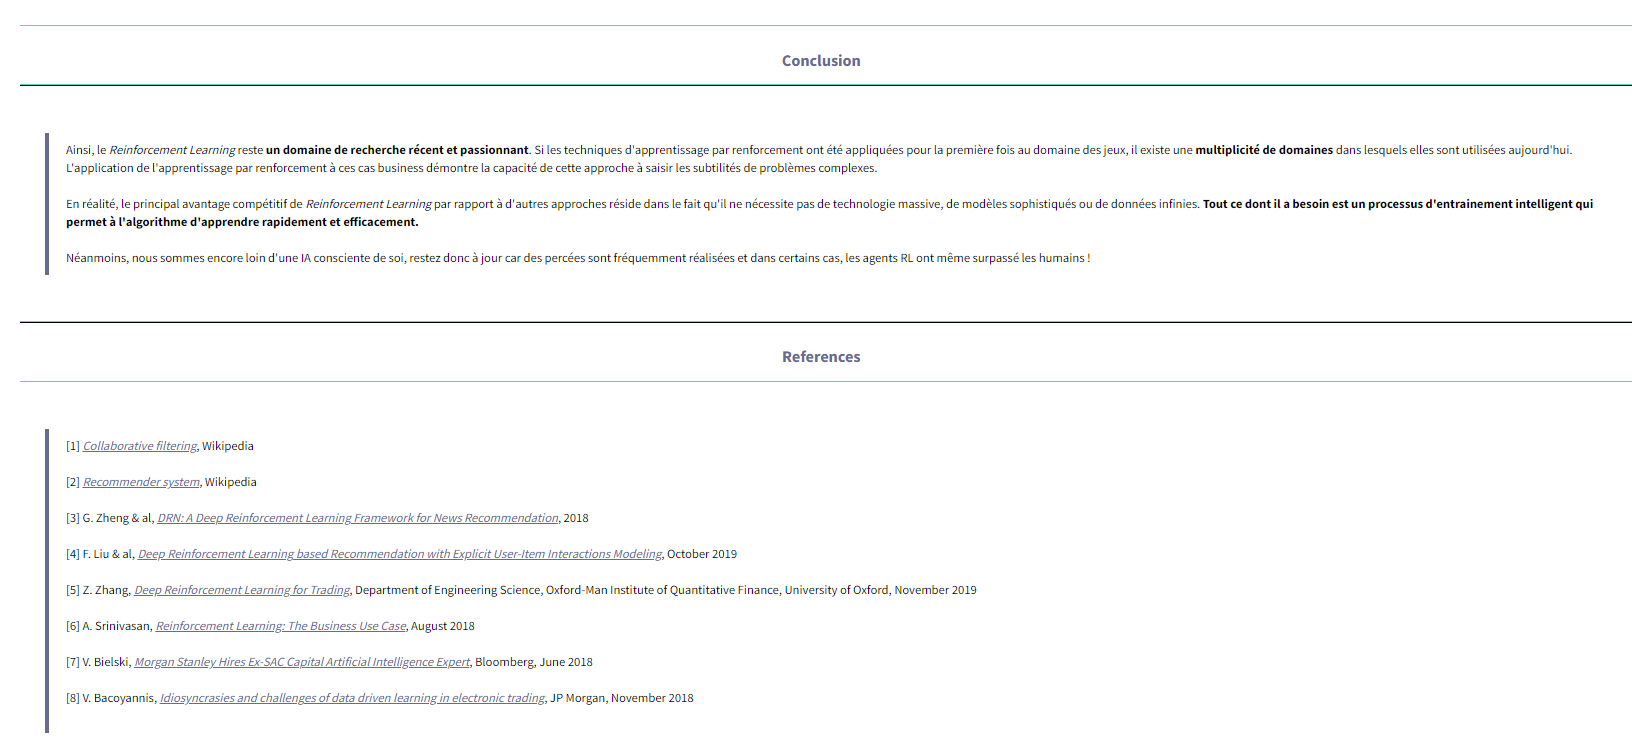

In [ ]:
https://en.wikipedia.org/wiki/Collaborative_filtering
https://en.wikipedia.org/wiki/Recommender_system
http://www.personal.psu.edu/~gjz5038/paper/www2018_reinforceRec/www2018_reinforceRec.pdf  -> not found
https://arxiv.org/pdf/1810.12027.pdf
https://arxiv.org/pdf/1911.10107.pdf
https://www.bloomberg.com/news/articles/2018-06-26/morgan-stanley-hires-michael-kearns-to-lead-ai-research-effort
https://arxiv.org/pdf/1811.09549.pdf